In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
# from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from scipy import signal as sg
from s3fs import S3FileSystem, S3Map
import scipy
from scipy import stats
from scipy.special import kv as K_nu
from scipy.special import gamma
from scipy.optimize import minimize
# mle function import
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\21924032\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [25, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

# Import raw observation data and PSD processing

The raw observation data is extracted from IMOS open access ocean data at Australia NWS 400km offshore

In [3]:
# Login to the s3 bucket and list the deep water mooring (DWM) folders
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data/IMOS/DWM/')
for item in aodn:
    print(item)

imos-data/IMOS/DWM/ASFS
imos-data/IMOS/DWM/DA
imos-data/IMOS/DWM/SOTS


- P1: 2010-06
- P2: 2011-01
- P3: 2011-06
- P4: 2012-01
- P5: 2012-07
- P6: 2012-12
- P7: 2013-06
- P8: 2014-01
- P9: 2014-09
- P10: 2015-02
- P11: 2015-08
- P12: 2016-02
- P13: 2016-08
- P14: 2017-02
- P15: 2017-07
- P16: 2018-02
- P17: 2018-08

In [4]:
## Australia NWS
ITFTIS_temp_ncfiles_P1 = [
# 'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100630T033000Z_ITFTIS_FV01_ITFTIS-1006-SensusUltra-13_END-20110107T003000Z_C-20131112T002040Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T102500Z_ITFTIS_FV01_ITFTIS-1006-TR-1060-128.3_END-20110107T022400Z_C-20171113T024502Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T103500Z_ITFTIS_FV01_ITFTIS-1006-TR-1060-178.3_END-20101214T090400Z_C-20171113T024459Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T104200Z_ITFTIS_FV01_ITFTIS-1006-TR-1060-198.3_END-20110107T045100Z_C-20171113T024456Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T105600Z_ITFTIS_FV01_ITFTIS-1006-TR-1060-461.8_END-20110107T050400Z_C-20171113T024436Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T110300Z_ITFTIS_FV01_ITFTIS-1006-TR-1060-298.3_END-20110107T035700Z_C-20171113T024453Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T111000Z_ITFTIS_FV01_ITFTIS-1006-TR-1060-398.3_END-20110107T034800Z_C-20171113T024450Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20100629T111724Z_ITFTIS_FV01_ITFTIS-1006-TDR-2050-21.8_END-20110107T053224Z_C-20171113T024513Z.nc',
]

In [5]:
## Australia NWS
ITFTIS_temp_ncfiles_P2 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110104T082000Z_ITFTIS_FV01_ITFTIS-1101-TDR-2050-80_END-20110527T013400Z_C-20171109T035611Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T040000Z_ITFTIS_FV01_ITFTIS-1101-TR-1060-130_END-20110527T015700Z_C-20171109T035604Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T043000Z_ITFTIS_FV01_ITFTIS-1101-TR-1060-270_END-20110527T023500Z_C-20171109T035558Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T053000Z_ITFTIS_FV01_ITFTIS-1101-TR-1060-170_END-20110527T021700Z_C-20171109T035601Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T060000Z_ITFTIS_FV01_ITFTIS-1101-TDR-2050-20_END-20110527T014900Z_C-20171109T035622Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T060000Z_ITFTIS_FV01_ITFTIS-1101-TR-1060-370_END-20110527T022900Z_C-20171109T035555Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T060000Z_ITFTIS_FV01_ITFTIS-1101-TR-1060-461_END-20110527T024800Z_C-20171109T035541Z.nc',
# 'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110107T202750Z_ITFTIS_FV01_ITFTIS-1101-SensusUltra-9_END-20110527T143925Z_C-20171109T035626Z.nc',
]

In [6]:
ITFTIS_temp_ncfiles_P3 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-SBE39-110.7_END-20120111T044320Z_C-20171113T072606Z.nc',
# too short'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-SBE39-125.7_END-20111101T003500Z_C-20171113T072603Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-SBE39-150.7_END-20120111T041500Z_C-20171113T072600Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-SBE39-175.7_END-20120111T093138Z_C-20171113T072557Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-SBE39-195.7_END-20120111T053638Z_C-20171113T072554Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-SBE39-45.7_END-20120111T050320Z_C-20171113T072623Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-TR-1060-245.7_END-20120111T061230Z_C-20171113T072551Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-TR-1060-295.7_END-20120111T071755Z_C-20171113T072548Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-TR-1060-395.7_END-20120110T210255Z_C-20171113T072545Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T120000Z_ITFTIS_FV01_ITFTIS-1105-TR-1060-456.7_END-20120111T073230Z_C-20171113T072532Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110529T134127Z_ITFTIS_FV01_ITFTIS-1105-SBE39-65.7_END-20120111T090308Z_C-20171113T072616Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110530T120000Z_ITFTIS_FV01_ITFTIS-1105-TDR-2050-15.7_END-20120111T051115Z_C-20171113T072634Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20110530T120000Z_ITFTIS_FV01_ITFTIS-1105-TDR-2050-25.7_END-20120111T053435Z_C-20171113T072630Z.nc',
]

In [7]:
ITFTIS_temp_ncfiles_P4 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120106T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE39-17_END-20120722T232140Z_C-20180111T082050Z.nc',
# 'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120106T050213Z_ITFTIS_FV01_ITFTIS-1201-SensusUltra-5_END-20120724T071713Z_C-20180111T082053Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120107T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-112_END-20120722T230459Z_C-20180111T082024Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120107T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-152_END-20120722T210959Z_C-20180111T082018Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120107T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-47_END-20120722T233229Z_C-20180111T082040Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120107T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-67_END-20120722T234044Z_C-20180111T082034Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-127_END-20120723T000909Z_C-20180111T082021Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-177_END-20120722T211819Z_C-20180111T082015Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-197_END-20120723T001959Z_C-20180111T082012Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-247_END-20120722T235409Z_C-20180111T082009Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-27_END-20120722T204228Z_C-20180111T082047Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-297_END-20120723T001459Z_C-20180111T082006Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-347_END-20120723T002909Z_C-20180111T082003Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120109T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-397_END-20120722T232549Z_C-20180111T082000Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120110T000000Z_ITFTIS_FV01_ITFTIS-1201-SBE56-456_END-20120722T210104Z_C-20180111T081948Z.nc',
]

In [8]:
ITFTIS_temp_ncfiles_P5 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T000000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-110.5_END-20121214T060459Z_C-20180117T055159Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T000000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-150.5_END-20121214T062048Z_C-20180117T055152Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T000000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-25.5_END-20121214T053138Z_C-20180117T055223Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T000000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-395.5_END-20121214T071617Z_C-20180117T055133Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T000000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-454.5_END-20121214T072958Z_C-20180117T055120Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-125.5_END-20121214T061450Z_C-20180117T055156Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-175.5_END-20121214T062548Z_C-20180117T055149Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-195.5_END-20121214T063145Z_C-20180117T055146Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-245.5_END-20121214T064049Z_C-20180117T055143Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-295.5_END-20121214T070639Z_C-20180117T055140Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-345.5_END-20121214T071135Z_C-20180117T055137Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-45.5_END-20121214T055554Z_C-20180117T055216Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_ITFTIS_FV01_ITFTIS-1207-SBE56-65.5_END-20121214T073459Z_C-20180117T055210Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20120722T000000Z_ITFTIS_FV01_ITFTIS-1207-SBE39-15.5_END-20121214T072459Z_C-20180117T055226Z.nc',


]

In [9]:
ITFTIS_temp_ncfiles_P6 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE39-14.5_END-20130623T220820Z_C-20180122T004027Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE39-24.5_END-20130526T175001Z_C-20180122T004024Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE39-44.5_END-20130623T110957Z_C-20180122T004018Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-109.5_END-20130623T020729Z_C-20180122T004002Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-124.5_END-20130622T235959Z_C-20180122T004000Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-149.5_END-20130623T021813Z_C-20180122T003957Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-179.5_END-20130623T005329Z_C-20180122T003954Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-194.5_END-20130623T010929Z_C-20180122T003951Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-244.5_END-20130623T011559Z_C-20180122T003948Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-294.5_END-20130623T023529Z_C-20180122T003945Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-344.5_END-20130623T032158Z_C-20180122T003942Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-394.5_END-20130623T024429Z_C-20180122T003939Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-455.7_END-20130623T032944Z_C-20180122T003927Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20121213T060000Z_ITFTIS_FV01_ITFTIS-1212-SBE56-64.5_END-20130622T235159Z_C-20180122T004012Z.nc',
]

In [10]:
ITFTIS_temp_ncfiles_P7 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE39-19.5_END-20140114T031500Z_C-20160607T064132Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-114_END-20140113T050459Z_C-20160607T064106Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-129_END-20140113T042559Z_C-20160607T064103Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-154_END-20140113T051859Z_C-20160607T064100Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-179_END-20140113T023229Z_C-20160607T064057Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-199_END-20140113T045929Z_C-20160607T064054Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-252_END-20140113T041929Z_C-20160607T064051Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-299_END-20140113T052359Z_C-20160607T064048Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-29_END-20140113T045329Z_C-20160607T064129Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-349_END-20140113T021559Z_C-20160607T064045Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-399_END-20140113T024759Z_C-20160607T064042Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-460.2_END-20140113T052959Z_C-20160607T064030Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-49_END-20140113T041259Z_C-20160607T064123Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20130620T000000Z_ITFTIS_FV01_ITFTIS-1306-SBE56-69_END-20140113T033559Z_C-20160607T064116Z.nc',
]

In [11]:
ITFTIS_temp_ncfiles_P8 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-112_END-20140909T045829Z_C-20180516T064345Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-127_END-20140909T051459Z_C-20180516T064342Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-152_END-20140909T044759Z_C-20180516T064339Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-177_END-20140909T063529Z_C-20180516T064335Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-197_END-20140909T055859Z_C-20180516T064332Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-250_END-20140909T064629Z_C-20180516T064329Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-27_END-20140909T055329Z_C-20180516T064411Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-297_END-20140909T062229Z_C-20180516T064325Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-347_END-20140909T053929Z_C-20180516T064322Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-397_END-20140909T054159Z_C-20180516T064318Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-458.2_END-20140909T043159Z_C-20180516T064304Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-47_END-20140909T062859Z_C-20180516T064404Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T000000Z_ITFTIS_FV01_ITFTIS-1401-SBE56-67_END-20140909T041129Z_C-20180516T064357Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140109T120000Z_ITFTIS_FV01_ITFTIS-1401-SBE39-17.5_END-20140909T063000Z_C-20180516T064414Z.nc',
]

In [12]:
ITFTIS_temp_ncfiles_P9 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140907T063947Z_ITFTIS_FV01_ITFTIS-1409-SBE39-94_END-20150207T065000Z_C-20180516T032113Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE39-344_END-20150207T074500Z_C-20180516T032046Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-109_END-20150207T050759Z_C-20180516T032110Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-124_END-20150207T051359Z_C-20180516T032107Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-174_END-20150207T052329Z_C-20180516T032100Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-194_END-20150207T053459Z_C-20180516T032057Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-24_END-20150207T042659Z_C-20180516T032134Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-294_END-20150207T054659Z_C-20180516T032049Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-394_END-20150207T055659Z_C-20180516T032043Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-44_END-20150207T044059Z_C-20180516T032127Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-455.2_END-20150207T061059Z_C-20180516T032029Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-54_END-20150207T045059Z_C-20180516T032124Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20140908T000000Z_ITFTIS_FV01_ITFTIS-1409-SBE56-74_END-20150207T045959Z_C-20180516T032117Z.nc',
]

In [13]:
ITFTIS_temp_ncfiles_P10 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150204T231500Z_ITFTIS_FV01_ITFTIS-1502-SBE39-79.9_END-20150812T070000Z_C-20180515T071645Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-114.9_END-20150812T015859Z_C-20180515T071638Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-129.9_END-20150812T042059Z_C-20180515T071635Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-179.9_END-20150812T055005Z_C-20180515T071628Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-192.9_END-20150812T034159Z_C-20180515T071625Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-29.9_END-20150812T044959Z_C-20180515T071703Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-299.9_END-20150812T023559Z_C-20180515T071618Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-399.9_END-20150812T025529Z_C-20180515T071611Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-461.1_END-20150812T020629Z_C-20180515T071557Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-49.9_END-20150812T050359Z_C-20180515T071656Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-59.9_END-20150812T043359Z_C-20180515T071652Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150205T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE56-99.9_END-20150812T045929Z_C-20180515T071642Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150206T000000Z_ITFTIS_FV01_ITFTIS-1502-SBE39-349.9_END-20150812T064500Z_C-20180515T071614Z.nc',
]

In [14]:
ITFTIS_temp_ncfiles_P11 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-105_END-20160209T225659Z_C-20180509T034823Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-115_END-20160209T230159Z_C-20180509T034820Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-145_END-20160209T230659Z_C-20180509T034817Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-185_END-20160209T231359Z_C-20180509T034810Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-35_END-20160209T223359Z_C-20180509T034842Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-405_END-20160209T232059Z_C-20180509T034753Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-465.5_END-20160209T232559Z_C-20180509T034740Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-55_END-20160209T224559Z_C-20180509T034836Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T000000Z_ITFTIS_FV01_ITFTIS-1508-SBE56-65_END-20160209T225059Z_C-20180509T034833Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T120000Z_ITFTIS_FV01_ITFTIS-1508-SBE39-205_END-20160208T033400Z_C-20180509T034806Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T120000Z_ITFTIS_FV01_ITFTIS-1508-SBE39-305_END-20160209T224600Z_C-20180509T034759Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T120000Z_ITFTIS_FV01_ITFTIS-1508-SBE39-355_END-20160209T230200Z_C-20180509T034756Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20150807T120000Z_ITFTIS_FV01_ITFTIS-1508-SBE39-85_END-20160209T222800Z_C-20180509T034826Z.nc',
]

In [15]:
ITFTIS_temp_ncfiles_P12 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE39-296.3_END-20160801T041500Z_C-20180502T045004Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE39-346.3_END-20160801T023500Z_C-20180502T045000Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE39-76.3_END-20160801T022000Z_C-20180502T045031Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-111.3_END-20160731T062819Z_C-20180502T045025Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-126.3_END-20160731T053918Z_C-20180502T045022Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-176.3_END-20160731T061605Z_C-20180502T045015Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-26.3_END-20160731T070259Z_C-20180502T045049Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-396.3_END-20160731T071959Z_C-20180502T044957Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-455.8_END-20160731T100359Z_C-20180502T044943Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-46.3_END-20160731T051941Z_C-20180502T045042Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-56.3_END-20160731T073859Z_C-20180502T045039Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T000000Z_ITFTIS_FV01_ITFTIS-1602-SBE56-96.3_END-20160731T075129Z_C-20180502T045028Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160208T050000Z_ITFTIS_FV01_ITFTIS-1602-SBE39-196.3_END-20160801T025400Z_C-20180502T045011Z.nc',
]

In [16]:
ITFTIS_temp_ncfiles_P13 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160727T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE39-196_END-20170214T035000Z_C-20180502T023638Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160727T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE39-296_END-20170214T034500Z_C-20180502T023630Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160727T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE39-76_END-20170214T035500Z_C-20180502T023657Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-111_END-20170214T000329Z_C-20180502T023651Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-126_END-20170214T000829Z_C-20180502T023648Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-176_END-20170214T002229Z_C-20180502T023641Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-26_END-20170213T233159Z_C-20180502T023715Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-398_END-20170214T010429Z_C-20180502T023624Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-455.5_END-20170214T003629Z_C-20180502T023610Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-46_END-20170213T233829Z_C-20180502T023708Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-56_END-20170213T234559Z_C-20180502T023705Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000000Z_ITFTIS_FV01_ITFTIS-1607-SBE56-96_END-20170213T235529Z_C-20180502T023654Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20160729T000001Z_ITFTIS_FV01_ITFTIS-1607-SBE39plus-346_END-20170214T043600Z_C-20180502T023627Z.nc',
]

In [17]:
ITFTIS_temp_ncfiles_P14 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T000000Z_ITFTIS_FV01_ITFTIS-1702-SBE39-113.6_END-20170721T023000Z_C-20180430T014604Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T000000Z_ITFTIS_FV01_ITFTIS-1702-SBE39-198.6_END-20170721T034500Z_C-20180430T014551Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T000000Z_ITFTIS_FV01_ITFTIS-1702-SBE39-298.6_END-20170721T041000Z_C-20180430T014545Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T000000Z_ITFTIS_FV01_ITFTIS-1702-SBE39-348.6_END-20170721T045000Z_C-20180430T014541Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-128.6_END-20170721T014759Z_C-20180430T014601Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-178.6_END-20170721T020059Z_C-20180430T014554Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-28.6_END-20170721T013459Z_C-20180430T014626Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-398.6_END-20170721T012259Z_C-20180430T014538Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-458.1_END-20170721T014359Z_C-20180430T014526Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-48.6_END-20170721T013859Z_C-20180430T014620Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-58.6_END-20170721T015259Z_C-20180430T014617Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-78.6_END-20170721T012959Z_C-20180430T014610Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170207T120000Z_ITFTIS_FV01_ITFTIS-1702-SBE56-98.6_END-20170721T015659Z_C-20180430T014607Z.nc',
]

In [18]:
ITFTIS_temp_ncfiles_P15 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170715T043658Z_ITFTIS_FV01_ITFTIS-1707-SBE56-397_END-20180213T064058Z_C-20180227T061353Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170715T052603Z_ITFTIS_FV01_ITFTIS-1707-SBE56-27_END-20180213T061603Z_C-20180227T061442Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-RBRsolo-177_END-20180213T071500Z_C-20180227T061410Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-RBRsolo-456_END-20180213T070200Z_C-20180227T061341Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-RBRsolo-57_END-20180213T063300Z_C-20180227T061432Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-SBE56-112_END-20180213T065559Z_C-20180227T061419Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-SBE56-127_END-20180213T064759Z_C-20180227T061416Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-SBE56-47_END-20180213T055659Z_C-20180227T061435Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170716T000000Z_ITFTIS_FV01_ITFTIS-1707-SBE56-77_END-20180213T062859Z_C-20180227T061426Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170717T000000Z_ITFTIS_FV01_ITFTIS-1707-SBE39-347_END-20180213T035000Z_C-20180227T061356Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170717T000000Z_ITFTIS_FV01_ITFTIS-1707-SBE39-97_END-20180213T034000Z_C-20180227T061422Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170717T000001Z_ITFTIS_FV01_ITFTIS-1707-SBE39plus-197_END-20180213T043200Z_C-20180227T061407Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20170717T000001Z_ITFTIS_FV01_ITFTIS-1707-SBE39plus-297_END-20180213T042601Z_C-20180227T061400Z.nc',
]

In [19]:
ITFTIS_temp_ncfiles_P16 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE39-101_END-20180804T075000Z_C-20181102T025132Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-116_END-20180804T063059Z_C-20181102T025128Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-131_END-20180804T073959Z_C-20181102T025124Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-181_END-20180804T064059Z_C-20181102T025116Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-31_END-20180804T052159Z_C-20181102T025156Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-401_END-20180804T050759Z_C-20181102T025056Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-461.5_END-20180804T074659Z_C-20181102T025040Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-51_END-20180804T064659Z_C-20181102T025148Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-61_END-20180804T072059Z_C-20181102T025144Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180209T120000Z_ITFTIS_FV01_ITFTIS-1802-SBE56-81_END-20180804T073159Z_C-20181102T025136Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180212T000001Z_ITFTIS_FV01_ITFTIS-1802-SBE39plus-202_END-20180804T052729Z_C-20181102T025112Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180212T000001Z_ITFTIS_FV01_ITFTIS-1802-SBE39plus-301_END-20180804T071901Z_C-20181102T025104Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180212T000001Z_ITFTIS_FV01_ITFTIS-1802-SBE39plus-351_END-20180804T064700Z_C-20181102T025100Z.nc',
]

In [20]:
ITFTIS_temp_ncfiles_P17 = [
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE39-96.5_END-20190220T021000Z_C-20190401T041237Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-126.5_END-20190219T065239Z_C-20190401T041233Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-131.5_END-20190219T062949Z_C-20190401T041229Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-176.5_END-20190219T082749Z_C-20190401T041220Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-396.5_END-20190219T085149Z_C-20190401T041202Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-457.3_END-20190219T044719Z_C-20190401T041145Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-46.5_END-20190219T055919Z_C-20190401T041254Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-56.5_END-20190219T061659Z_C-20190401T041250Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000000Z_ITFTIS_FV01_ITFTIS-1807-SBE56-76.5_END-20190219T053829Z_C-20190401T041241Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000001Z_ITFTIS_FV01_ITFTIS-1807-SBE39plus-296.5_END-20190220T041100Z_C-20190401T041211Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Temperature/IMOS_ANMN-QLD_TZ_20180802T000001Z_ITFTIS_FV01_ITFTIS-1807-SBE39plus-346.5_END-20190220T034430Z_C-20190401T041206Z.nc',
]

In [21]:
from functions import Processing
from speccy import sick_tricks as gary

In [22]:
sitename = 'ITFTIS'
# for example: choose a depth to perform analysis
example_ds = Processing.Open_file_nocache(ITFTIS_temp_ncfiles_P7[5], fs)
example_ds.load()
example_ds.TIME

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'TIME' (TIME: 596760)>
array(['2013-06-20T00:00:00.000000000', '2013-06-20T00:00:29.999998208',
       '2013-06-20T00:00:59.999996416', ..., '2014-01-13T04:58:29.000004096',
       '2014-01-13T04:58:59.000002304', '2014-01-13T04:59:29.000000512'],
      dtype='datetime64[ns]')
Coordinates:
  * TIME           (TIME) datetime64[ns] 2013-06-20 ... 2014-01-13T04:59:29.0...
    LATITUDE       float64 -9.818
    LONGITUDE      float64 127.6
    NOMINAL_DEPTH  float32 199.0
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    valid_min:      0.0
    valid_max:      90000.0

In [23]:
obs_time = example_ds.TIME.values
obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
obs_sample_interval_days = obs_sample_interval/86400 # second to day 
obs_sample_interval # second

29.999998208

In [24]:
for i in ITFTIS_temp_ncfiles_P7:
    ds = Processing.Open_file_nocache(i, fs)
    obs_time =ds.TIME.values
    obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
    print(obs_sample_interval) # second

300.000002304
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208
29.999998208


In [25]:
# Find the water depth
instrument_nominal_depth = example_ds.instrument_nominal_depth
total_depth = example_ds.site_depth_at_deployment
instrument_nominal_depth,total_depth

(199.0, 467.0)

In [26]:
# Calculate the Coriolis frequency
lat = example_ds.LATITUDE.values
lon = example_ds.LONGITUDE.values
f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_coriolis_cpd = np.abs(f_coriolis*86400/(2*np.pi))
print('Coriolis frequency is',f_coriolis_cpd, 'cpd')
print(lat,lon)
#Principal lunar semidiurnal
M2_freq = 0.0805*24 #cpd
M4_freq = 2*M2_freq
#Lunar elliptic semidiurnal
N2_freq = 0.0790*24 #cpd

#Princinpal lunar diurnal
O1_freq = 0.0387*24 #cpd

#Lunisolar diurnal
K1_freq = 0.0418*24 #cpd

#Principal solar semidiurnal
S2_freq = 0.0833*24 #cpd

xcoords = [f_coriolis_cpd,  K1_freq,O1_freq,M2_freq,S2_freq]
xcoords_label = ['Coriolis_freq', 'K1', 'O1','M2','S2']
xcoords_color = ['orange', 'c', 'm','r','b','g']

Coriolis frequency is 0.3410266664423999 cpd
-9.8176666667 127.5539


Remove the depth average velocity (barotropic) and left "baoclinic) velocity

Remove the time average velocity and left zero mean data

Replace the bad quality data with 0

## Grid and Windowing the temp data 

In [27]:
window_days =80

# Period 1
Time_P1, Depths_P1, Temp_data_P1, Temp_data_P1_no_mean, Temp_badidx_P1 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P1)

Window_idx_List             = Processing.Find_window_idx(Time_P1,window_days=window_days)
Time_P1_Window              = Processing.Windowing(Time_P1,Window_idx_List )
Temp_data_P1_Window         = Processing.Windowing(Temp_data_P1,Window_idx_List )
Temp_data_P1_Window_no_mean = Processing.Windowing(Temp_data_P1_no_mean,Window_idx_List )
Temp_badidx_P1_Window       = Processing.Windowing(Temp_badidx_P1,Window_idx_List )

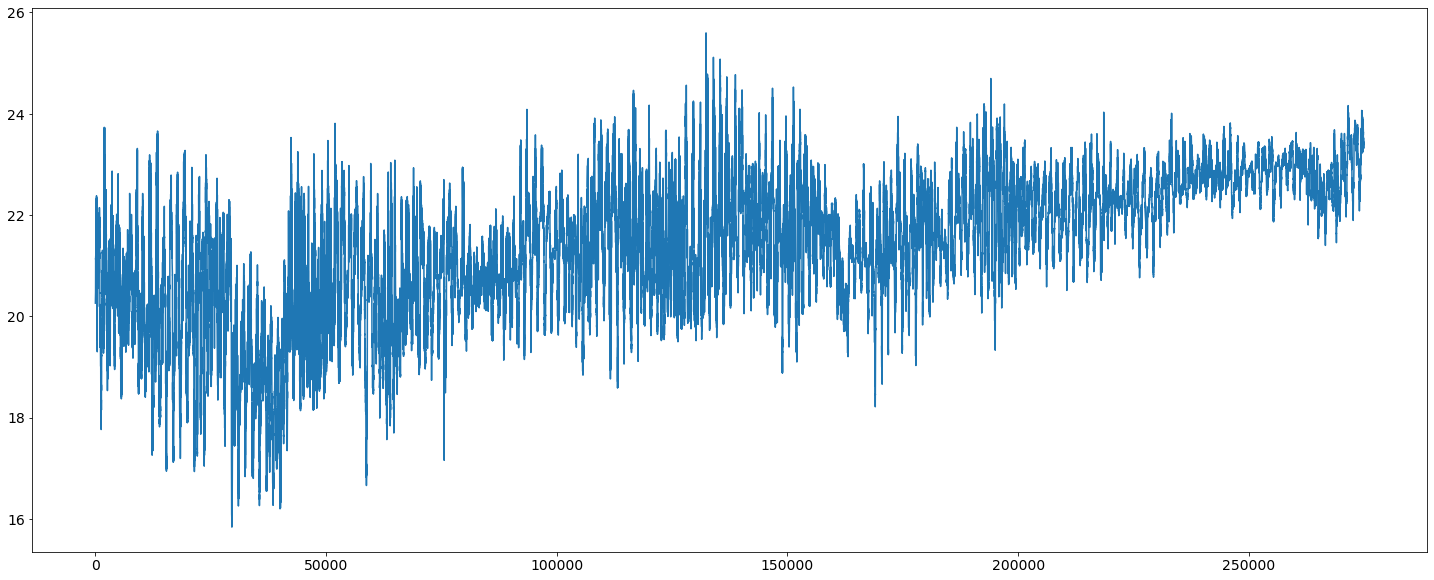

In [28]:
plt.plot(Temp_data_P1[0])

In [29]:
# Period 2
Time_P2, Depths_P2, Temp_data_P2, Temp_data_P2_no_mean, Temp_badidx_P2 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P2)

Window_idx_List             = Processing.Find_window_idx(Time_P2,window_days=window_days)
Time_P2_Window              = Processing.Windowing(Time_P2,Window_idx_List )
Temp_data_P2_Window         = Processing.Windowing(Temp_data_P2,Window_idx_List )
Temp_data_P2_Window_no_mean = Processing.Windowing(Temp_data_P2_no_mean,Window_idx_List )
Temp_badidx_P2_Window       = Processing.Windowing(Temp_badidx_P2,Window_idx_List )

In [ ]:
# Period 3
Time_P3, Depths_P3, Temp_data_P3, Temp_data_P3_no_mean, Temp_badidx_P3 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P3)

Window_idx_List             = Processing.Find_window_idx(Time_P3,window_days=window_days)
Time_P3_Window              = Processing.Windowing(Time_P3,Window_idx_List )
Temp_data_P3_Window         = Processing.Windowing(Temp_data_P3,Window_idx_List )
Temp_data_P3_Window_no_mean = Processing.Windowing(Temp_data_P3_no_mean,Window_idx_List )
Temp_badidx_P3_Window       = Processing.Windowing(Temp_badidx_P3,Window_idx_List )

In [ ]:
Time_P3_Window   

In [ ]:
# Period 4
Time_P4, Depths_P4, Temp_data_P4, Temp_data_P4_no_mean, Temp_badidx_P4 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P4)

Window_idx_List             = Processing.Find_window_idx(Time_P4,window_days=window_days)
Time_P4_Window              = Processing.Windowing(Time_P4,Window_idx_List )
Temp_data_P4_Window         = Processing.Windowing(Temp_data_P4,Window_idx_List )
Temp_data_P4_Window_no_mean = Processing.Windowing(Temp_data_P4_no_mean,Window_idx_List )
Temp_badidx_P4_Window       = Processing.Windowing(Temp_badidx_P4,Window_idx_List )

In [ ]:
# Period 5
Time_P5, Depths_P5, Temp_data_P5, Temp_data_P5_no_mean, Temp_badidx_P5 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P5)

Window_idx_List             = Processing.Find_window_idx(Time_P5,window_days=window_days)
Time_P5_Window              = Processing.Windowing(Time_P5,Window_idx_List )
Temp_data_P5_Window         = Processing.Windowing(Temp_data_P5,Window_idx_List )
Temp_data_P5_Window_no_mean = Processing.Windowing(Temp_data_P5_no_mean,Window_idx_List )
Temp_badidx_P5_Window       = Processing.Windowing(Temp_badidx_P5,Window_idx_List )

In [ ]:
# Period 6
Time_P6, Depths_P6, Temp_data_P6, Temp_data_P6_no_mean, Temp_badidx_P6 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P6)

Window_idx_List             = Processing.Find_window_idx(Time_P6,window_days=window_days)
Time_P6_Window              = Processing.Windowing(Time_P6,Window_idx_List )
Temp_data_P6_Window         = Processing.Windowing(Temp_data_P6,Window_idx_List )
Temp_data_P6_Window_no_mean = Processing.Windowing(Temp_data_P6_no_mean,Window_idx_List )
Temp_badidx_P6_Window       = Processing.Windowing(Temp_badidx_P6,Window_idx_List )

In [ ]:
# Period 7
Time_P7, Depths_P7, Temp_data_P7, Temp_data_P7_no_mean, Temp_badidx_P7 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P7)

Window_idx_List             = Processing.Find_window_idx(Time_P7,window_days=window_days)
Time_P7_Window              = Processing.Windowing(Time_P7,Window_idx_List )
Temp_data_P7_Window         = Processing.Windowing(Temp_data_P7,Window_idx_List )
Temp_data_P7_Window_no_mean = Processing.Windowing(Temp_data_P7_no_mean,Window_idx_List )
Temp_badidx_P7_Window       = Processing.Windowing(Temp_badidx_P7,Window_idx_List )

In [ ]:
# Period 8
Time_P8, Depths_P8, Temp_data_P8, Temp_data_P8_no_mean, Temp_badidx_P8 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P8)

Window_idx_List             = Processing.Find_window_idx(Time_P8,window_days=window_days)
Time_P8_Window              = Processing.Windowing(Time_P8,Window_idx_List )
Temp_data_P8_Window         = Processing.Windowing(Temp_data_P8,Window_idx_List )
Temp_data_P8_Window_no_mean = Processing.Windowing(Temp_data_P8_no_mean,Window_idx_List )
Temp_badidx_P8_Window       = Processing.Windowing(Temp_badidx_P8,Window_idx_List )

In [ ]:
# Period 9
Time_P9, Depths_P9, Temp_data_P9, Temp_data_P9_no_mean, Temp_badidx_P9 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P9)

Window_idx_List             = Processing.Find_window_idx(Time_P9,window_days=window_days)
Time_P9_Window              = Processing.Windowing(Time_P9,Window_idx_List )
Temp_data_P9_Window         = Processing.Windowing(Temp_data_P9,Window_idx_List )
Temp_data_P9_Window_no_mean = Processing.Windowing(Temp_data_P9_no_mean,Window_idx_List )
Temp_badidx_P9_Window       = Processing.Windowing(Temp_badidx_P9,Window_idx_List )

In [ ]:
# Period 10
Time_P10, Depths_P10, Temp_data_P10, Temp_data_P10_no_mean, Temp_badidx_P10 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P10)

Window_idx_List             = Processing.Find_window_idx(Time_P10,window_days=window_days)
Time_P10_Window              = Processing.Windowing(Time_P10,Window_idx_List )
Temp_data_P10_Window         = Processing.Windowing(Temp_data_P10,Window_idx_List )
Temp_data_P10_Window_no_mean = Processing.Windowing(Temp_data_P10_no_mean,Window_idx_List )
Temp_badidx_P10_Window       = Processing.Windowing(Temp_badidx_P10,Window_idx_List )

In [ ]:
# Period 11
Time_P11, Depths_P11, Temp_data_P11, Temp_data_P11_no_mean, Temp_badidx_P11 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P11)

Window_idx_List             = Processing.Find_window_idx(Time_P11,window_days=window_days)
Time_P11_Window              = Processing.Windowing(Time_P11,Window_idx_List )
Temp_data_P11_Window         = Processing.Windowing(Temp_data_P11,Window_idx_List )
Temp_data_P11_Window_no_mean = Processing.Windowing(Temp_data_P11_no_mean,Window_idx_List )
Temp_badidx_P11_Window       = Processing.Windowing(Temp_badidx_P11,Window_idx_List )

In [ ]:
# Period 122
Time_P12, Depths_P12, Temp_data_P12, Temp_data_P12_no_mean, Temp_badidx_P12 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P12)

Window_idx_List             = Processing.Find_window_idx(Time_P12,window_days=window_days)
Time_P12_Window              = Processing.Windowing(Time_P12,Window_idx_List )
Temp_data_P12_Window         = Processing.Windowing(Temp_data_P12,Window_idx_List )
Temp_data_P12_Window_no_mean = Processing.Windowing(Temp_data_P12_no_mean,Window_idx_List )
Temp_badidx_P12_Window       = Processing.Windowing(Temp_badidx_P12,Window_idx_List )

In [ ]:
# Period 13
Time_P13, Depths_P13, Temp_data_P13, Temp_data_P13_no_mean, Temp_badidx_P13 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P13)

Window_idx_List             = Processing.Find_window_idx(Time_P13,window_days=window_days)
Time_P13_Window              = Processing.Windowing(Time_P13,Window_idx_List )
Temp_data_P13_Window         = Processing.Windowing(Temp_data_P13,Window_idx_List )
Temp_data_P13_Window_no_mean = Processing.Windowing(Temp_data_P13_no_mean,Window_idx_List )
Temp_badidx_P13_Window       = Processing.Windowing(Temp_badidx_P13,Window_idx_List )

In [ ]:
# Period 14
Time_P14, Depths_P14, Temp_data_P14, Temp_data_P14_no_mean, Temp_badidx_P14 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P14)

Window_idx_List             = Processing.Find_window_idx(Time_P14,window_days=window_days)
Time_P14_Window              = Processing.Windowing(Time_P14,Window_idx_List )
Temp_data_P14_Window         = Processing.Windowing(Temp_data_P14,Window_idx_List )
Temp_data_P14_Window_no_mean = Processing.Windowing(Temp_data_P14_no_mean,Window_idx_List )
Temp_badidx_P14_Window       = Processing.Windowing(Temp_badidx_P14,Window_idx_List )

In [ ]:
# Period 15
Time_P15, Depths_P15, Temp_data_P15, Temp_data_P15_no_mean, Temp_badidx_P15 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P15)

Window_idx_List             = Processing.Find_window_idx(Time_P15,window_days=window_days)
Time_P15_Window              = Processing.Windowing(Time_P15,Window_idx_List )
Temp_data_P15_Window         = Processing.Windowing(Temp_data_P15,Window_idx_List )
Temp_data_P15_Window_no_mean = Processing.Windowing(Temp_data_P15_no_mean,Window_idx_List )
Temp_badidx_P15_Window       = Processing.Windowing(Temp_badidx_P15,Window_idx_List )

In [ ]:
# Period 16
Time_P16, Depths_P16, Temp_data_P16, Temp_data_P16_no_mean, Temp_badidx_P16 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P16)

Window_idx_List             = Processing.Find_window_idx(Time_P16,window_days=window_days)
Time_P16_Window              = Processing.Windowing(Time_P16,Window_idx_List )
Temp_data_P16_Window         = Processing.Windowing(Temp_data_P16,Window_idx_List )
Temp_data_P16_Window_no_mean = Processing.Windowing(Temp_data_P16_no_mean,Window_idx_List )
Temp_badidx_P16_Window       = Processing.Windowing(Temp_badidx_P16,Window_idx_List )

In [ ]:
# Period 17
Time_P17, Depths_P17, Temp_data_P17, Temp_data_P17_no_mean, Temp_badidx_P17 = Processing.Collect_temp(ITFTIS_temp_ncfiles_P17)

Window_idx_List             = Processing.Find_window_idx(Time_P17,window_days=window_days)
Time_P17_Window              = Processing.Windowing(Time_P17,Window_idx_List )
Temp_data_P17_Window         = Processing.Windowing(Temp_data_P17,Window_idx_List )
Temp_data_P17_Window_no_mean = Processing.Windowing(Temp_data_P17_no_mean,Window_idx_List )
Temp_badidx_P17_Window       = Processing.Windowing(Temp_badidx_P17,Window_idx_List )

In [ ]:
for i in range(len(Time_P6_Window[6])):
    plt.plot(Time_P6_Window[6][i],Temp_data_P6_Window[6][i],label='window {}'.format(i+1))
plt.legend()

In [ ]:
year_list_P1, start_date_list_P1, end_date_list_P1  = Processing.Find_window_label(Time_P1_Window)
year_list_P2, start_date_list_P2, end_date_list_P2  = Processing.Find_window_label(Time_P2_Window)
year_list_P3, start_date_list_P3, end_date_list_P3  = Processing.Find_window_label(Time_P3_Window)
year_list_P4, start_date_list_P4, end_date_list_P4  = Processing.Find_window_label(Time_P4_Window)
year_list_P5, start_date_list_P5, end_date_list_P5  = Processing.Find_window_label(Time_P5_Window)
year_list_P6, start_date_list_P6, end_date_list_P6  = Processing.Find_window_label(Time_P6_Window)
year_list_P7, start_date_list_P7, end_date_list_P7  = Processing.Find_window_label(Time_P7_Window)
year_list_P8, start_date_list_P8, end_date_list_P8  = Processing.Find_window_label(Time_P8_Window)
year_list_P9, start_date_list_P9, end_date_list_P9  = Processing.Find_window_label(Time_P9_Window)
year_list_P10,start_date_list_P10,end_date_list_P10 = Processing.Find_window_label(Time_P10_Window)
year_list_P11,start_date_list_P11,end_date_list_P11 = Processing.Find_window_label(Time_P11_Window)
year_list_P12,start_date_list_P12,end_date_list_P12 = Processing.Find_window_label(Time_P12_Window)
year_list_P13,start_date_list_P13,end_date_list_P13 = Processing.Find_window_label(Time_P13_Window)
year_list_P14,start_date_list_P14,end_date_list_P14 = Processing.Find_window_label(Time_P14_Window)
year_list_P15,start_date_list_P15,end_date_list_P15 = Processing.Find_window_label(Time_P15_Window)
year_list_P16,start_date_list_P16,end_date_list_P16 = Processing.Find_window_label(Time_P16_Window)
year_list_P17,start_date_list_P17,end_date_list_P17 = Processing.Find_window_label(Time_P17_Window)

In [ ]:
#set freq for low-pass filter
cutoff_freq = 10  # Cutoff frequency (in Hz)
nyquist_freq = (Time_P1[3][1]-Time_P1[3][0]).astype('float')/1e9  # Nyquist frequency

temp_avg_list_P1  = Processing.Find_mean_temp(Temp_data_P1_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P2  = Processing.Find_mean_temp(Temp_data_P2_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P3  = Processing.Find_mean_temp(Temp_data_P3_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P4  = Processing.Find_mean_temp(Temp_data_P4_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P5  = Processing.Find_mean_temp(Temp_data_P5_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P6  = Processing.Find_mean_temp(Temp_data_P6_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P7  = Processing.Find_mean_temp(Temp_data_P7_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P8  = Processing.Find_mean_temp(Temp_data_P8_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P9  = Processing.Find_mean_temp(Temp_data_P9_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P10 = Processing.Find_mean_temp(Temp_data_P10_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P11 = Processing.Find_mean_temp(Temp_data_P11_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P12 = Processing.Find_mean_temp(Temp_data_P12_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P13 = Processing.Find_mean_temp(Temp_data_P13_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P14 = Processing.Find_mean_temp(Temp_data_P14_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P15 = Processing.Find_mean_temp(Temp_data_P15_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P16 = Processing.Find_mean_temp(Temp_data_P16_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P17 = Processing.Find_mean_temp(Temp_data_P17_Window,cutoff_freq,nyquist_freq)

In [ ]:
#set freq for low-pass filter
cutoff_freq = 10  # Cutoff frequency (in Hz)
nyquist_freq = (Time_P1[3][1]-Time_P1[3][0]).astype('float')/1e9  # Nyquist frequency

temp_avg_list_P1_no_mean  = Processing.Find_mean_temp(Temp_data_P1_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P2_no_mean  = Processing.Find_mean_temp(Temp_data_P2_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P3_no_mean  = Processing.Find_mean_temp(Temp_data_P3_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P4_no_mean  = Processing.Find_mean_temp(Temp_data_P4_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P5_no_mean  = Processing.Find_mean_temp(Temp_data_P5_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P6_no_mean  = Processing.Find_mean_temp(Temp_data_P6_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P7_no_mean  = Processing.Find_mean_temp(Temp_data_P7_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P8_no_mean  = Processing.Find_mean_temp(Temp_data_P8_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P9_no_mean  = Processing.Find_mean_temp(Temp_data_P9_Window_no_mean, cutoff_freq,nyquist_freq)
temp_avg_list_P10_no_mean = Processing.Find_mean_temp(Temp_data_P10_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P11_no_mean = Processing.Find_mean_temp(Temp_data_P11_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P12_no_mean = Processing.Find_mean_temp(Temp_data_P12_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P13_no_mean = Processing.Find_mean_temp(Temp_data_P13_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P14_no_mean = Processing.Find_mean_temp(Temp_data_P14_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P15_no_mean = Processing.Find_mean_temp(Temp_data_P15_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P16_no_mean = Processing.Find_mean_temp(Temp_data_P16_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P17_no_mean = Processing.Find_mean_temp(Temp_data_P17_Window_no_mean,cutoff_freq,nyquist_freq)

## Construct a pd dataframe

In [ ]:
final_P1  = Processing.Create_df(start_date_list_P1, end_date_list_P1, year_list_P1, temp_avg_list_P1, temp_avg_list_P1_no_mean, Depths_P1)
final_P2  = Processing.Create_df(start_date_list_P2, end_date_list_P2, year_list_P2, temp_avg_list_P2, temp_avg_list_P2_no_mean, Depths_P2)
final_P3  = Processing.Create_df(start_date_list_P3, end_date_list_P3, year_list_P3, temp_avg_list_P3, temp_avg_list_P3_no_mean, Depths_P3)
final_P4  = Processing.Create_df(start_date_list_P4, end_date_list_P4, year_list_P4, temp_avg_list_P4, temp_avg_list_P4_no_mean, Depths_P4)
final_P5  = Processing.Create_df(start_date_list_P5, end_date_list_P5, year_list_P5, temp_avg_list_P5, temp_avg_list_P5_no_mean, Depths_P5)
final_P6  = Processing.Create_df(start_date_list_P6, end_date_list_P6, year_list_P6, temp_avg_list_P6, temp_avg_list_P6_no_mean, Depths_P6)
final_P7  = Processing.Create_df(start_date_list_P7, end_date_list_P7, year_list_P7, temp_avg_list_P7, temp_avg_list_P7_no_mean, Depths_P7)
final_P8  = Processing.Create_df(start_date_list_P8, end_date_list_P8, year_list_P8, temp_avg_list_P8, temp_avg_list_P8_no_mean, Depths_P8)
final_P9  = Processing.Create_df(start_date_list_P9, end_date_list_P9, year_list_P9, temp_avg_list_P9, temp_avg_list_P9_no_mean, Depths_P9)
final_P10 = Processing.Create_df(start_date_list_P10,end_date_list_P10,year_list_P10,temp_avg_list_P10,temp_avg_list_P10_no_mean,Depths_P10)
final_P11 = Processing.Create_df(start_date_list_P11,end_date_list_P11,year_list_P11,temp_avg_list_P11,temp_avg_list_P11_no_mean,Depths_P11)
final_P12 = Processing.Create_df(start_date_list_P12,end_date_list_P12,year_list_P12,temp_avg_list_P12,temp_avg_list_P12_no_mean,Depths_P12)
final_P13 = Processing.Create_df(start_date_list_P13,end_date_list_P13,year_list_P13,temp_avg_list_P13,temp_avg_list_P13_no_mean,Depths_P13)
final_P14 = Processing.Create_df(start_date_list_P14,end_date_list_P14,year_list_P14,temp_avg_list_P14,temp_avg_list_P14_no_mean,Depths_P14)
final_P15 = Processing.Create_df(start_date_list_P15,end_date_list_P15,year_list_P15,temp_avg_list_P15,temp_avg_list_P15_no_mean,Depths_P15)
final_P16 = Processing.Create_df(start_date_list_P16,end_date_list_P16,year_list_P16,temp_avg_list_P16,temp_avg_list_P16_no_mean,Depths_P16)
final_P17 = Processing.Create_df(start_date_list_P17,end_date_list_P17,year_list_P17,temp_avg_list_P17,temp_avg_list_P17_no_mean,Depths_P17)



final_df = pd.concat([final_P1,final_P2,final_P3,final_P4,final_P5,
                      final_P6,final_P7,final_P8,final_P9,final_P10,
                      final_P11,final_P12,final_P13,final_P14,final_P15,
                      final_P16,final_P17])

In [ ]:
final_df 

In [ ]:
plt.scatter(final_df['start_date'],final_df['season'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
#plot mean
season = final_df['season'].drop_duplicates()
year = final_df['year'].drop_duplicates()
fig, axs = plt.subplots(2,4, figsize=(25, 13))
fig.text(0.5, 1, 'Mean Temperature profile 2012-2014', ha='center', va='center')    
for i in range(len(season)):   # 4season
    for ii in year:
        selected_df = final_df[(final_df['season']==season.iloc[i]) & (final_df['year']==ii)].sort_index()
        
        axs[0,i].plot(selected_df['mean_temp'],-selected_df.index,)
        axs[0,i].set_title(season.iloc[i])
        axs[0,i].set_ylabel('Depth (m)')
        axs[0,i].set_xlabel('Mean Temp (℃)')
        
        axs[1,i].plot(selected_df['mean_temp_no_mean'],-selected_df.index,)
        axs[1,i].set_title(season.iloc[i])
        axs[1,i].set_ylabel('Depth (m)')
        axs[1,i].set_xlabel('Mean Temp no mean (℃)')

# Using harmonic analysis as the mean function

In [ ]:
from functions import Harmonics

$$
\begin{bmatrix}y_1\\y_2\\y_3\\...\\y_n\end{bmatrix}=\begin{bmatrix}\cos(2\pi*p_1x_1)&\cos(2\pi*p_2x_1)&\cos(2\pi*p_3x_1)&\cos(2\pi*p_4x_1)&sin(2\pi*p_1x_1)&\sin(2\pi*p_2*x_1)&\sin(2\pi*p_3x_1)&\sin(2\pi*p_4x_1)\\\cos(2\pi*p_1x_2)&\cos(2\pi*p_2x_2)&\cos(2\pi*p_3x_2)&sin(2\pi*p_1x_2)&\sin(2\pi*p_2*x_2)&\sin(2\pi*p_3x_2)&\cos(2\pi*p_4x_2)&\sin(2\pi*p_4x_2)\\\cos(2\pi*p_1x_3)&sin(2\pi*p_1x_3)&\cos(2\pi*p_2x_3)&\sin(2\pi*p_2*x_3)&\cos(2\pi*p_3x_3)&\sin(2\pi*p_3x_3)&\cos(2\pi*p_4x_3)&\sin(2\pi*p_4x_3)\\...\\\cos(2\pi*p_1x_n)&sin(2\pi*p_1x_n)&\cos(2\pi*p_2x_n)&\sin(2\pi*p_2*x_n)&\cos(2\pi*p_3x_n)&\sin(2\pi*p_3x_n)&\cos(2\pi*p_4x_n)&\sin(2\pi*p_4x_n)\end{bmatrix}\begin{bmatrix}a_1\\a_2\\a_3\\a_4\\b_1\\b_2\\b_3\\b_4\end{bmatrix}+\epsilon
$$ 

$$
 \underline{y}=X \underline{\beta}+ \underline{\epsilon}
$$

From Gauss–Markov theorem:
$$
	\hat{\beta}=(X^TX)^{-1}X^Ty
$$

In [ ]:
Depths_P1

In [ ]:
# total depth is ~400m
interest_depth = 198.3
idx = Depths_P1.index(interest_depth)
y = Temp_data_P1_Window[idx][0] #remove the depth avg velocity
obs_time = Time_P1_Window[idx][0]
obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
obs_sample_interval_days = obs_sample_interval/86400 # second to day 

N = len(y)
time_length = len(y)
x  = np.linspace(0,obs_sample_interval_days*N,N)#[:,None]
Xd = Harmonics.Mean_X(x)
mean_params = Harmonics.OLS(Xd,y)
yd_mean = Harmonics.Prior_mean_function(x,mean_params)
ϵ =  y - yd_mean #residual

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x,y,label='real')
plt.plot(x,ϵ,label = 'residual')
plt.plot(x,yd_mean,label='mean')
plt.legend()
plt.xlabel('days')
plt.ylabel('temp (℃)')
plt.grid(b=True,ls=':')
plt.title('harmonic analysis at depth of {}'.format(interest_depth))

plt.subplot(2, 1, 2)
idx = 60000
plt.plot(x[30000:idx],y[30000:idx],label='real')
plt.plot(x[30000:idx],ϵ[30000:idx],label = 'residual')
plt.plot(x[30000:idx],yd_mean[30000:idx],label='mean')
plt.legend()

plt.xlabel('days')
plt.ylabel('temp (℃)')
plt.grid(b=True,ls=':')

In [ ]:
f_mean, Puu_mean= Processing.Welch(yd_mean,obs_sample_interval_days)
f_ϵ,Puu_ϵ= Processing.Welch(ϵ,obs_sample_interval_days)
f_obs_w,pvv_obs_w = Processing.Welch(y,obs_sample_interval_days)

# f_mean, Puu_mean= processing.periodogram(yd_mean,obs_sample_interval_days)
# f_ϵ,Puu_ϵ= processing.periodogram(ϵ,obs_sample_interval_days)
# f_obs_w,pvv_obs_w = processing.periodogram(y,obs_sample_interval_days)

# plt.plot(f_mean, Puu_mean,label='mean',lw=2)
plt.plot(f_obs_w,pvv_obs_w,label='whole')
plt.plot(f_ϵ,Puu_ϵ,label='residual')

plt.xscale("log")
plt.yscale("log")

plt.xlabel('f_mean[cycles per day]')
plt.ylabel('Puu_mean')
plt.grid(b=True,ls=':')
plt.legend(loc="lower left")

# plt.xlim(0.1,5)
plt.ylim(1e-9, 1e1)

In [ ]:
# remove mean is added into the cal_harmonics_spectrum_depth_profile function
Mean_params_P1, Mean_func_P1, F_p_P1,  P_p_P1_raw,  F_w_P1, P_w_P1_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P1_Window, Depths_P1, Temp_data_P1_Window )
Mean_params_P2, Mean_func_P2, F_p_P2,  P_p_P2_raw,  F_w_P2, P_w_P2_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P2_Window, Depths_P2, Temp_data_P2_Window )
Mean_params_P3, Mean_func_P3, F_p_P3,  P_p_P3_raw,  F_w_P3, P_w_P3_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P3_Window, Depths_P3, Temp_data_P3_Window )
Mean_params_P4, Mean_func_P4, F_p_P4,  P_p_P4_raw,  F_w_P4, P_w_P4_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P4_Window, Depths_P4, Temp_data_P4_Window )
Mean_params_P5, Mean_func_P5, F_p_P5,  P_p_P5_raw,  F_w_P5, P_w_P5_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P5_Window, Depths_P5, Temp_data_P5_Window )
Mean_params_P6, Mean_func_P6, F_p_P6,  P_p_P6_raw,  F_w_P6, P_w_P6_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P6_Window, Depths_P6, Temp_data_P6_Window )
Mean_params_P7, Mean_func_P7, F_p_P7,  P_p_P7_raw,  F_w_P7, P_w_P7_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P7_Window, Depths_P7, Temp_data_P7_Window )
Mean_params_P8, Mean_func_P8, F_p_P8,  P_p_P8_raw,  F_w_P8, P_w_P8_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P8_Window, Depths_P8, Temp_data_P8_Window )
Mean_params_P9, Mean_func_P9, F_p_P9,  P_p_P9_raw,  F_w_P9, P_w_P9_raw  = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P9_Window, Depths_P9, Temp_data_P9_Window )
Mean_params_P10,Mean_func_P10,F_p_P10, P_p_P10_raw, F_w_P10,P_w_P10_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P10_Window,Depths_P10,Temp_data_P10_Window )
Mean_params_P11,Mean_func_P11,F_p_P11, P_p_P11_raw, F_w_P11,P_w_P11_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P11_Window,Depths_P11,Temp_data_P11_Window )
Mean_params_P12,Mean_func_P12,F_p_P12, P_p_P12_raw, F_w_P12,P_w_P12_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P12_Window,Depths_P12,Temp_data_P12_Window )
Mean_params_P13,Mean_func_P13,F_p_P13, P_p_P13_raw, F_w_P13,P_w_P13_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P13_Window,Depths_P13,Temp_data_P13_Window )
Mean_params_P14,Mean_func_P14,F_p_P14, P_p_P14_raw, F_w_P14,P_w_P14_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P14_Window,Depths_P14,Temp_data_P14_Window )
Mean_params_P15,Mean_func_P15,F_p_P15, P_p_P15_raw, F_w_P15,P_w_P15_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P15_Window,Depths_P15,Temp_data_P15_Window )
Mean_params_P16,Mean_func_P16,F_p_P16, P_p_P16_raw, F_w_P16,P_w_P16_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P16_Window,Depths_P16,Temp_data_P16_Window )
Mean_params_P17,Mean_func_P17,F_p_P17, P_p_P17_raw, F_w_P17,P_w_P17_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P17_Window,Depths_P17,Temp_data_P17_Window )

In [ ]:
def cal_THVF(mean_func,temp_data_window):
    
    THVF_list = []
    for i in range(len(mean_func)):
        for ii in range(len(mean_func[i])):
            THVF_list.append(mean_func[i][ii].var()/temp_data_window[i][ii].var())
            
    return np.mean(THVF_list)

def cal_var(temp_data_window):
    
    var_list = []
    for i in range(len(temp_data_window)):
        for ii in range(len(temp_data_window[i])):
            var_list.append(temp_data_window[i][ii].var())
            
    return np.mean(var_list)

print('Avg var at this site is ', np.mean([cal_var(Temp_data_P1_Window_no_mean),
                                           cal_var(Temp_data_P2_Window_no_mean),
                                           cal_var(Temp_data_P3_Window_no_mean),
                                           cal_var(Temp_data_P4_Window_no_mean),
                                           cal_var(Temp_data_P5_Window_no_mean),
                                           cal_var(Temp_data_P6_Window_no_mean),
                                           cal_var(Temp_data_P7_Window_no_mean),
                                           cal_var(Temp_data_P8_Window_no_mean),
                                           cal_var(Temp_data_P9_Window_no_mean),
                                           cal_var(Temp_data_P10_Window_no_mean),
                                           cal_var(Temp_data_P11_Window_no_mean),
                                           cal_var(Temp_data_P12_Window_no_mean),
                                           cal_var(Temp_data_P13_Window_no_mean),
                                           cal_var(Temp_data_P14_Window_no_mean),
                                           cal_var(Temp_data_P15_Window_no_mean),
                                           cal_var(Temp_data_P16_Window_no_mean),
                                           cal_var(Temp_data_P17_Window_no_mean),]))

print('Avg THVF at this site is ', np.mean([cal_THVF(Mean_func_P1,Temp_data_P1_Window_no_mean),
                                            cal_THVF(Mean_func_P2,Temp_data_P2_Window_no_mean),
                                            cal_THVF(Mean_func_P3,Temp_data_P3_Window_no_mean),
                                            cal_THVF(Mean_func_P4,Temp_data_P4_Window_no_mean),
                                            cal_THVF(Mean_func_P5,Temp_data_P5_Window_no_mean),
                                            cal_THVF(Mean_func_P6,Temp_data_P6_Window_no_mean),
                                            cal_THVF(Mean_func_P7,Temp_data_P7_Window_no_mean),
                                            cal_THVF(Mean_func_P8,Temp_data_P8_Window_no_mean),
                                            cal_THVF(Mean_func_P9,Temp_data_P9_Window_no_mean),
                                            cal_THVF(Mean_func_P10,Temp_data_P10_Window_no_mean),
                                            cal_THVF(Mean_func_P11,Temp_data_P11_Window_no_mean),
                                            cal_THVF(Mean_func_P12,Temp_data_P12_Window_no_mean),
                                            cal_THVF(Mean_func_P13,Temp_data_P13_Window_no_mean),
                                            cal_THVF(Mean_func_P14,Temp_data_P14_Window_no_mean),
                                            cal_THVF(Mean_func_P15,Temp_data_P15_Window_no_mean),
                                            cal_THVF(Mean_func_P16,Temp_data_P16_Window_no_mean),
                                            cal_THVF(Mean_func_P17,Temp_data_P17_Window_no_mean),]))

In [ ]:
for i in range(len(F_w_P1[0])):
    plt.loglog(F_w_P1[0][i],P_w_P1_raw[0][i],label='window {}'.format(i+1))
plt.legend()
plt.ylim(1e-7,10)

## Scaling the periodogram similar to Parzen1996

In [ ]:
P_p_P1  = Processing.Scale_periodogram(P_p_P1_raw, Temp_badidx_P1_Window)
P_p_P2  = Processing.Scale_periodogram(P_p_P2_raw, Temp_badidx_P2_Window)
P_p_P3  = Processing.Scale_periodogram(P_p_P3_raw, Temp_badidx_P3_Window)
P_p_P4  = Processing.Scale_periodogram(P_p_P4_raw, Temp_badidx_P4_Window)
P_p_P5  = Processing.Scale_periodogram(P_p_P5_raw, Temp_badidx_P5_Window)
P_p_P6  = Processing.Scale_periodogram(P_p_P6_raw, Temp_badidx_P6_Window)
P_p_P7  = Processing.Scale_periodogram(P_p_P7_raw, Temp_badidx_P7_Window)
P_p_P8  = Processing.Scale_periodogram(P_p_P8_raw, Temp_badidx_P8_Window)
P_p_P9  = Processing.Scale_periodogram(P_p_P9_raw, Temp_badidx_P9_Window)
P_p_P10 = Processing.Scale_periodogram(P_p_P10_raw,Temp_badidx_P10_Window)
P_p_P11 = Processing.Scale_periodogram(P_p_P11_raw,Temp_badidx_P11_Window)
P_p_P12 = Processing.Scale_periodogram(P_p_P12_raw,Temp_badidx_P12_Window)
P_p_P13 = Processing.Scale_periodogram(P_p_P13_raw,Temp_badidx_P13_Window)
P_p_P14 = Processing.Scale_periodogram(P_p_P14_raw,Temp_badidx_P14_Window)
P_p_P15 = Processing.Scale_periodogram(P_p_P15_raw,Temp_badidx_P15_Window)
P_p_P16 = Processing.Scale_periodogram(P_p_P16_raw,Temp_badidx_P16_Window)
P_p_P17 = Processing.Scale_periodogram(P_p_P17_raw,Temp_badidx_P17_Window)


In [ ]:
P_w_P1 = Processing.Scale_periodogram(P_w_P1_raw,Temp_badidx_P1_Window)
P_w_P2 = Processing.Scale_periodogram(P_w_P2_raw,Temp_badidx_P2_Window)
P_w_P3 = Processing.Scale_periodogram(P_w_P3_raw,Temp_badidx_P3_Window)
P_w_P4 = Processing.Scale_periodogram(P_w_P4_raw,Temp_badidx_P4_Window)
P_w_P5 = Processing.Scale_periodogram(P_w_P5_raw,Temp_badidx_P5_Window)
P_w_P6 = Processing.Scale_periodogram(P_w_P6_raw,Temp_badidx_P6_Window)
P_w_P7 = Processing.Scale_periodogram(P_w_P7_raw,Temp_badidx_P7_Window)
P_w_P8 = Processing.Scale_periodogram(P_w_P8_raw,Temp_badidx_P8_Window)
P_w_P9 = Processing.Scale_periodogram(P_w_P9_raw,Temp_badidx_P9_Window)
P_w_P10 = Processing.Scale_periodogram(P_w_P10_raw,Temp_badidx_P10_Window)
P_w_P11 = Processing.Scale_periodogram(P_w_P11_raw,Temp_badidx_P11_Window)
P_w_P12 = Processing.Scale_periodogram(P_w_P12_raw,Temp_badidx_P12_Window)
P_w_P13 = Processing.Scale_periodogram(P_w_P13_raw,Temp_badidx_P13_Window)
P_w_P14 = Processing.Scale_periodogram(P_w_P14_raw,Temp_badidx_P14_Window)
P_w_P15 = Processing.Scale_periodogram(P_w_P15_raw,Temp_badidx_P15_Window)
P_w_P16 = Processing.Scale_periodogram(P_w_P16_raw,Temp_badidx_P16_Window)
P_w_P17 = Processing.Scale_periodogram(P_w_P17_raw,Temp_badidx_P17_Window)

In [ ]:
idx = Depths_P1.index(interest_depth)
# plt.plot(F_residual_p[idx],P_residual_p_raw[idx],'-',label='Raw Obs Residual')
# plt.plot(F_residual_p[idx],P_residual_p[idx],'-.',label='Scaled Residual Periodogram')

plt.plot(F_w_P1[idx][1],P_w_P1_raw[idx][1],'-',label='Raw Obs Residual welch')
plt.plot(F_w_P1[idx][1],P_w_P1[idx][1],'-.',label='Scaled Residual welch')

# for j in range(len(xcoords)):
#     plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j])
plt.ylim(1e-9, 1e1)
plt.legend(ncol=3)
#     plt.xlim(0.1, 10)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Comparisoon of Raw and Scalled periodogram at {}m'.format(interest_depth))

Therefore, the following analysis will be conducted from depth of 30m towards the seabed.

# Specify the horizontal domain, bathymetry section and vertical density profile

In [ ]:
from functions import Bathmetry

In [ ]:
#bathy_params = [H, h0, x0, lt]  # See the depth_tanh function for the mean

# bathy_params = [600, 450, 75e3, 70e3]  #set 1
#bathy_params = [300, 200,75e3,70e3] #set 2
bathy_params = [400,200,75e3, 70e3] #set 3

N = 16000  # Number of grid points
dx = 25.  # horizontal grid spacing

# The horizontal domain
x = np.arange(0, N * dx, dx)

# The depth
h = Bathmetry.Depth_tanh(bathy_params, x)

In [ ]:
# See the references above for the mean of the,
#set 1
rho_params =[1025.66780468, # Mean density,             beta0
     1.5, # Density jump,                        beta1
     150,# Depth of the second pycnocline      beta4
     50, # Width of the second pycnocline     beta5
        ]
# Number of vertical levels
Nz = 40
#z = np.linspace(-H,0,Nz)
# z = np.linspace(-bathy_params[0],0,Nz) #bathy_params[0]=H
z = np.arange(-400,1,10)
# rhoz = rho_double_tanh(rho_params,z)
rhoz = Bathmetry.Single_tanh(z,rho_params)
# rhoz = constant_N(rho_params,z)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -h)  #negative bc depth
ax1.set_title('KdV model bathymetry')
ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('x [m]')
#plt.ylim(-H, 0)
ax1.set_ylim(-bathy_params[0], 0)
ax1.set_xlim(0, dx * N)

ax2.plot(rhoz, z)
# plt.xticks(np.arange(min(rhoz), max(rhoz), 0.5))
# ax2.set_ylabel('Depth [m]')
ax2.set_xlabel('Density [kg m$^{-3}$]')
ax2.set_title('Stratification')
# ax2.xaxis.tick_top()

## From the vertical density profile to find the vertical structure

In [ ]:
import iwaves
WaveModes = iwaves.IWaveModes(rhoz,z,density_func='single_tanh_rho')
zmax = -np.max(np.abs(z))
dz = z[1]-z[0]
phi_1, c1, h_e, Z = WaveModes(zmax,dz,mode=0)  # mode 1
iwaves.IWaveModes.plot_modes(WaveModes)
phi_1, c1, h_e,Z

In [ ]:
phi_depth_profile = xr.DataArray(phi_1, coords={'depth': Z}, dims=['depth'])

## Garret-Munk Spectral Model

In [ ]:
# Garret-Munk 
from functions import GM81 as gm
# Coriolis frequency
f = f_coriolis_cpd/86400 #hz
# buoyancy frequency 
buoyancy_freq = 200
N = buoyancy_freq/86400  #hz
# surface-extrapolated buoyancy frequency
N0 = np.sqrt(WaveModes.N2)[0] #hz
# e-folding scale of N(z) # how long N(z) take to increase by e
b = 35000 #m
# frequency
omg = np.linspace(1.01*f, N, len(F_p_P1[0][0]))
# mode number
j = np.arange(1, 100)
# reshape to allow multiplication into 2D array
Omg = np.reshape(omg, (omg.size,1))
J = np.reshape(j, (1,j.size))
# frequency spectra (KE and PE)
K_omg_j = gm.K_omg_j(Omg, J, f, N, N0, b)
P_omg_j = gm.P_omg_j(Omg, J, f, N, N0, b)
# sum over modes
K_omg = np.sum(K_omg_j, axis=1)
P_omg = np.sum(P_omg_j, axis=1)
GM_spectrum = P_omg  #(m^2/s^2/cps)
P_omg

# Optimizing params for the residual function -- Whittle likelihood

Fitting in frequency domain using Whittle likelihood

$$
ℓ_W(\theta) = -\sum\limits _{\omega\in\Omega}\begin{Bmatrix}\log\hat{f}(\omega;\theta)+\frac{I(\omega)}{\hat{f}(\omega;\theta)}\end{Bmatrix}  
$$

where $\hat{f}(\omega;\theta)$ is the continuous-time process spectral density (what we expected)  and $I(\omega)$ is the periodogram (what we observed)

In [ ]:
f_coriolis_cpd

# Workflow on the Residual

Parametric 

In [ ]:
from functions import Cov
from functions import Optimisation

## Define the boundary and initial guess

In [ ]:
#Initia guess
IG_noise = 1.5e-5

IG_η_matern = 0.5
IG_α_matern = 1 #impact the slope

IG_eta = 0.5
IG_ℓ_exp = 20 #impact how wide the brodening of peak 1 is (proportional)  

In [ ]:
##bounds
bound_noise = [0,1]

bound_η_matern = [0.01,10]
bound_α_matern = [0.5,3.5] #impact the slope                  # from matern 7/2 to matern 1/2 to matern 0

# K1_freq,O1_freq,M2_freq,S2_freq
bound_eta = [0.1,10]     # K1 peak

bound_ℓ_exp = [0.01,100]  #impact how wide the brodening of peak 1 is (reverse proportional)  peak 1 is designed to be broader than peak 2

## Select Frequency range to omit the influence of inertial and M4 peak 

Generally, the Whittle likelihood is applied to optimize the parameters for the whole frequency band of the observed periodogram (an estimation of the true spectrum). However, in our case, we selected a range of frequencies (from coriolis frequency to buoyancy frequency) to perform the optimization because the internal tide behaviors appear in this bandwidth. In addition, since the inertial and M4 peak are not the characteristics of the internal tides, they are omitted in our optimization using Whittle likelihood.

In [ ]:
subset_p_P1  = Processing.Subset_IT(F_p_P1,f_coriolis_cpd)
subset_w_P1  = Processing.Subset_IT(F_w_P1,f_coriolis_cpd)

subset_p_P2  = Processing.Subset_IT(F_p_P2,f_coriolis_cpd)
subset_w_P2  = Processing.Subset_IT(F_w_P2,f_coriolis_cpd)

subset_p_P3  = Processing.Subset_IT(F_p_P3,f_coriolis_cpd)
subset_w_P3  = Processing.Subset_IT(F_w_P3,f_coriolis_cpd)

subset_p_P4  = Processing.Subset_IT(F_p_P4,f_coriolis_cpd)
subset_w_P4  = Processing.Subset_IT(F_w_P4,f_coriolis_cpd)

subset_p_P5  = Processing.Subset_IT(F_p_P5,f_coriolis_cpd)
subset_w_P5  = Processing.Subset_IT(F_w_P5,f_coriolis_cpd)

subset_p_P6  = Processing.Subset_IT(F_p_P6,f_coriolis_cpd)
subset_w_P6  = Processing.Subset_IT(F_w_P6,f_coriolis_cpd)

subset_p_P7  = Processing.Subset_IT(F_p_P7,f_coriolis_cpd)
subset_w_P7  = Processing.Subset_IT(F_w_P7,f_coriolis_cpd)

subset_p_P8  = Processing.Subset_IT(F_p_P8,f_coriolis_cpd)
subset_w_P8  = Processing.Subset_IT(F_w_P8,f_coriolis_cpd)

subset_p_P9  = Processing.Subset_IT(F_p_P9,f_coriolis_cpd)
subset_w_P9  = Processing.Subset_IT(F_w_P9,f_coriolis_cpd)

subset_p_P10 = Processing.Subset_IT(F_p_P10,f_coriolis_cpd)
subset_w_P10 = Processing.Subset_IT(F_w_P10,f_coriolis_cpd)

subset_p_P11 = Processing.Subset_IT(F_p_P11,f_coriolis_cpd)
subset_w_P11 = Processing.Subset_IT(F_w_P11,f_coriolis_cpd)

subset_p_P12 = Processing.Subset_IT(F_p_P12,f_coriolis_cpd)
subset_w_P12 = Processing.Subset_IT(F_w_P12,f_coriolis_cpd)

subset_p_P13 = Processing.Subset_IT(F_p_P13,f_coriolis_cpd)
subset_w_P13 = Processing.Subset_IT(F_w_P13,f_coriolis_cpd)

subset_p_P14 = Processing.Subset_IT(F_p_P14,f_coriolis_cpd)
subset_w_P14 = Processing.Subset_IT(F_w_P14,f_coriolis_cpd)

subset_p_P15 = Processing.Subset_IT(F_p_P15,f_coriolis_cpd)
subset_w_P15 = Processing.Subset_IT(F_w_P15,f_coriolis_cpd)

subset_p_P16 = Processing.Subset_IT(F_p_P16,f_coriolis_cpd)
subset_w_P16 = Processing.Subset_IT(F_w_P16,f_coriolis_cpd)

subset_p_P17 = Processing.Subset_IT(F_p_P17,f_coriolis_cpd)
subset_w_P17 = Processing.Subset_IT(F_w_P17,f_coriolis_cpd)

In [ ]:
F_p_P1_modulated  = Processing.Select_frequency(F_p_P1, subset_p_P1)
P_p_P1_modulated  = Processing.Select_frequency(P_p_P1, subset_p_P1)

F_p_P2_modulated  = Processing.Select_frequency(F_p_P2, subset_p_P2)
P_p_P2_modulated  = Processing.Select_frequency(P_p_P2, subset_p_P2) 

F_p_P3_modulated  = Processing.Select_frequency(F_p_P3, subset_p_P3)
P_p_P3_modulated  = Processing.Select_frequency(P_p_P3, subset_p_P3) 

F_p_P4_modulated  = Processing.Select_frequency(F_p_P4, subset_p_P4) 
P_p_P4_modulated  = Processing.Select_frequency(P_p_P4, subset_p_P4)

F_p_P5_modulated  = Processing.Select_frequency(F_p_P5, subset_p_P5) 
P_p_P5_modulated  = Processing.Select_frequency(P_p_P5, subset_p_P5) 

F_p_P6_modulated  = Processing.Select_frequency(F_p_P6, subset_p_P6)
P_p_P6_modulated  = Processing.Select_frequency(P_p_P6, subset_p_P6)

F_p_P7_modulated  = Processing.Select_frequency(F_p_P7, subset_p_P7)
P_p_P7_modulated  = Processing.Select_frequency(P_p_P7, subset_p_P7) 

F_p_P8_modulated  = Processing.Select_frequency(F_p_P8, subset_p_P8)
P_p_P8_modulated  = Processing.Select_frequency(P_p_P8, subset_p_P8) 

F_p_P9_modulated  = Processing.Select_frequency(F_p_P9, subset_p_P9) 
P_p_P9_modulated  = Processing.Select_frequency(P_p_P9, subset_p_P9)

F_p_P10_modulated = Processing.Select_frequency(F_p_P10,subset_p_P10) 
P_p_P10_modulated = Processing.Select_frequency(P_p_P10,subset_p_P10) 

F_p_P11_modulated = Processing.Select_frequency(F_p_P11,subset_p_P11)
P_p_P11_modulated = Processing.Select_frequency(P_p_P11,subset_p_P11)

F_p_P12_modulated = Processing.Select_frequency(F_p_P12,subset_p_P12)
P_p_P12_modulated = Processing.Select_frequency(P_p_P12,subset_p_P12) 

F_p_P13_modulated = Processing.Select_frequency(F_p_P13,subset_p_P13)
P_p_P13_modulated = Processing.Select_frequency(P_p_P13,subset_p_P13) 

F_p_P14_modulated = Processing.Select_frequency(F_p_P14,subset_p_P14) 
P_p_P14_modulated = Processing.Select_frequency(P_p_P14,subset_p_P14)

F_p_P15_modulated = Processing.Select_frequency(F_p_P15,subset_p_P15) 
P_p_P15_modulated = Processing.Select_frequency(P_p_P15,subset_p_P15) 

F_p_P16_modulated = Processing.Select_frequency(F_p_P16,subset_p_P16) 
P_p_P16_modulated = Processing.Select_frequency(P_p_P16,subset_p_P16)

F_p_P17_modulated = Processing.Select_frequency(F_p_P17,subset_p_P17) 
P_p_P17_modulated = Processing.Select_frequency(P_p_P17,subset_p_P17) 

In [ ]:
# # total depth is ~400m
idx = Depths_P1.index(interest_depth)
# y = Temp_profile.temperature.sel(depth=depth_below_surface[idx]) #remove the depth avg velocity

plt.plot(F_p_P3[idx][0],P_p_P3_raw[idx][0],label='Raw Obs Residual P')
plt.plot(F_p_P3[idx][0],P_p_P3[idx][0],'-.',label='Scaled Residual P')
plt.plot(F_p_P3_modulated[idx][0],P_p_P3_modulated[idx][0],'-.',label='Processed & scaled Residual P')

for j in range(len(xcoords)):
    plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j],alpha=0.35)

# plt.plot(F_residual_w[idx],P_residual_w_raw[idx],label='Raw Obs Residual W')
# plt.plot(F_residual_w[idx],P_residual_w[idx],'-.',label='Scaled Residual W')
# plt.plot(F_residual_w_Modulated[idx],P_residual_w_Modulated[idx],'-.',label='Processed & scaled Residual W')
plt.plot(omg*86400,GM_spectrum/86400,label = 'GM81')
plt.legend()
plt.ylim(1e-9, 1e1)
# plt.xlim(0, 5)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Comparison of temp residual spectrum at {}m'.format(interest_depth))

## M1L2 Kernal

In [ ]:
def M1L2(dx,params):
    
    noise_var = params[0]
    η_matern1 = params[1]
    α_matern1 = params[2]
    eta1      = params[3]
    ℓ_exp1    = params[4]
    eta2      = params[5]
    ℓ_exp2    = params[6]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=1/((O1_freq+K1_freq)/2))
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=1/((S2_freq+N2_freq)/2))
    noise = Cov.white_noise(dx,noise_var)
    COV = matern1 + peak1 + peak2 + noise
    return COV

In [80]:
def M1L2_no_noise(dx,params):
    
#     noise_var = params[0]
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta1      = params[2]
    ℓ_exp1    = params[3]
    eta2      = params[4]
    ℓ_exp2    = params[5]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=1/((O1_freq+K1_freq)/2))
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=1/((S2_freq+N2_freq)/2))
    COV = matern1 + peak1 + peak2 #+ noise
    return COV

In [81]:
#Initia guess
M1L2_covparams_ic = [ 
#                     IG_noise,
                    IG_η_matern,
                    IG_α_matern,
                    IG_eta,
                    IG_ℓ_exp,         
                    IG_eta,
                    IG_ℓ_exp,
                     ]#Semi-Diurnal frequency
#Boundary
M1L2_bounds_parameter = [
#     bound_noise,
                    bound_η_matern,
                    bound_α_matern,
                    bound_eta,
                    bound_ℓ_exp,
                    bound_eta,
                    bound_ℓ_exp,                     
]#Semi-Diurnal frequency

M1L2_parameter_name = [
#     'noise',
                    'η_matern1',
                    'ν_matern1',
                    'η_peak1',
                    'ℓ_peak1',
                    'η_peak2',
                    'ℓ_peak2', ]

In [82]:
# #normalise the whittle parameter
# whittle_parameter_1 = whittle_parameter_1 * (len(F_analytical_result_2[0])/len(F_analytical_result_1[0])) # N_small/N_big

Run Model/

In [83]:
F_model_fit_list_P1_M1L2, P_model_fit_list_P1_M1L2, Soln_model_fit_list_P1_M1L2, Whittle_list_P1_M1L2 = Optimisation.Model_fit(P_p_P1, Time_P1_Window, subset_p_P1,
                                                                                                           M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                                                           M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))
C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:113: RuntimeWarning: divide by zero encountered in power
  K *= np.power(np.abs(lmbda * dx), nu)


In [84]:
F_model_fit_list_P2_M1L2, P_model_fit_list_P2_M1L2, Soln_model_fit_list_P2_M1L2, Whittle_list_P2_M1L2 = Optimisation.Model_fit(P_p_P2, Time_P2_Window, subset_p_P2,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [85]:
F_model_fit_list_P3_M1L2, P_model_fit_list_P3_M1L2, Soln_model_fit_list_P3_M1L2, Whittle_list_P3_M1L2 = Optimisation.Model_fit(P_p_P3, Time_P3_Window, subset_p_P3,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [86]:
F_model_fit_list_P4_M1L2, P_model_fit_list_P4_M1L2, Soln_model_fit_list_P4_M1L2, Whittle_list_P4_M1L2 = Optimisation.Model_fit(P_p_P4, Time_P4_Window, subset_p_P4,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [87]:
F_model_fit_list_P5_M1L2, P_model_fit_list_P5_M1L2, Soln_model_fit_list_P5_M1L2, Whittle_list_P5_M1L2 = Optimisation.Model_fit(P_p_P5, Time_P5_Window, subset_p_P5,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [88]:
F_model_fit_list_P6_M1L2, P_model_fit_list_P6_M1L2, Soln_model_fit_list_P6_M1L2, Whittle_list_P6_M1L2 = Optimisation.Model_fit(P_p_P6, Time_P6_Window, subset_p_P6,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [89]:
F_model_fit_list_P7_M1L2, P_model_fit_list_P7_M1L2, Soln_model_fit_list_P7_M1L2, Whittle_list_P7_M1L2 = Optimisation.Model_fit(P_p_P7, Time_P7_Window, subset_p_P7,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [90]:
F_model_fit_list_P8_M1L2, P_model_fit_list_P8_M1L2, Soln_model_fit_list_P8_M1L2, Whittle_list_P8_M1L2 = Optimisation.Model_fit(P_p_P8, Time_P8_Window, subset_p_P8,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [91]:
F_model_fit_list_P9_M1L2, P_model_fit_list_P9_M1L2, Soln_model_fit_list_P9_M1L2, Whittle_list_P9_M1L2 = Optimisation.Model_fit(P_p_P9, Time_P9_Window, subset_p_P9,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [92]:
F_model_fit_list_P10_M1L2, P_model_fit_list_P10_M1L2, Soln_model_fit_list_P10_M1L2, Whittle_list_P10_M1L2 = Optimisation.Model_fit(P_p_P10, Time_P10_Window, subset_p_P10,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [93]:
F_model_fit_list_P11_M1L2, P_model_fit_list_P11_M1L2, Soln_model_fit_list_P11_M1L2, Whittle_list_P11_M1L2 = Optimisation.Model_fit(P_p_P11, Time_P11_Window, subset_p_P11,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [94]:
F_model_fit_list_P12_M1L2, P_model_fit_list_P12_M1L2, Soln_model_fit_list_P12_M1L2, Whittle_list_P12_M1L2 = Optimisation.Model_fit(P_p_P12, Time_P12_Window, subset_p_P12,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [95]:
F_model_fit_list_P13_M1L2, P_model_fit_list_P13_M1L2, Soln_model_fit_list_P13_M1L2, Whittle_list_P13_M1L2 = Optimisation.Model_fit(P_p_P13, Time_P13_Window, subset_p_P13,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [96]:
F_model_fit_list_P14_M1L2, P_model_fit_list_P14_M1L2, Soln_model_fit_list_P14_M1L2, Whittle_list_P14_M1L2 = Optimisation.Model_fit(P_p_P14, Time_P14_Window, subset_p_P14,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [97]:
F_model_fit_list_P15_M1L2, P_model_fit_list_P15_M1L2, Soln_model_fit_list_P15_M1L2, Whittle_list_P15_M1L2 = Optimisation.Model_fit(P_p_P15, Time_P15_Window, subset_p_P15,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [98]:
F_model_fit_list_P16_M1L2, P_model_fit_list_P16_M1L2, Soln_model_fit_list_P16_M1L2, Whittle_list_P16_M1L2 = Optimisation.Model_fit(P_p_P16, Time_P16_Window, subset_p_P16,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [99]:
F_model_fit_list_P17_M1L2, P_model_fit_list_P17_M1L2, Soln_model_fit_list_P17_M1L2, Whittle_list_P17_M1L2 = Optimisation.Model_fit(P_p_P17, Time_P17_Window, subset_p_P17,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

## M1L1

In [100]:
def M1L1_no_noise(dx,params):
    
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta2      = params[2]
    ℓ_exp2    = params[3]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=20,sigma=1e-6)              #background energy continuum  
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=1/((S2_freq+N2_freq)/2))
    COV = matern1 + peak2
    return COV

In [101]:
#Initia guess
M1L1_covparams_ic = [ 
#                     IG_noise,
                    IG_η_matern,
                    IG_α_matern,
                    IG_eta,
                    IG_ℓ_exp,         
                     ]#Semi-Diurnal frequency
#Boundary
M1L1_bounds_parameter = [
#     bound_noise,
                    bound_η_matern,
                    bound_α_matern,
                    bound_eta,
                    bound_ℓ_exp,                
]#Semi-Diurnal frequency

M1L1_parameter_name = [
#     'noise',
                    'η_matern1',
                    'α_matern1',
                    'eta2',
                    'ℓ_exp2', ]

Run M1L1 kernel

In [102]:
F_model_fit_list_P1_M1L1, P_model_fit_list_P1_M1L1, Soln_model_fit_list_P1_M1L1, Whittle_list_P1_M1L1 = Optimisation.Model_fit(P_p_P1, Time_P1_Window, subset_p_P1,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [103]:
F_model_fit_list_P2_M1L1, P_model_fit_list_P2_M1L1, Soln_model_fit_list_P2_M1L1, Whittle_list_P2_M1L1 = Optimisation.Model_fit(P_p_P2, Time_P2_Window, subset_p_P2,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [104]:
F_model_fit_list_P3_M1L1, P_model_fit_list_P3_M1L1, Soln_model_fit_list_P3_M1L1, Whittle_list_P3_M1L1 = Optimisation.Model_fit(P_p_P3, Time_P3_Window, subset_p_P3,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [105]:
F_model_fit_list_P4_M1L1, P_model_fit_list_P4_M1L1, Soln_model_fit_list_P4_M1L1, Whittle_list_P4_M1L1 = Optimisation.Model_fit(P_p_P4, Time_P4_Window, subset_p_P4,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [106]:
F_model_fit_list_P5_M1L1, P_model_fit_list_P5_M1L1, Soln_model_fit_list_P5_M1L1, Whittle_list_P5_M1L1 = Optimisation.Model_fit(P_p_P5, Time_P5_Window, subset_p_P5,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [107]:
F_model_fit_list_P6_M1L1, P_model_fit_list_P6_M1L1, Soln_model_fit_list_P6_M1L1, Whittle_list_P6_M1L1 = Optimisation.Model_fit(P_p_P6, Time_P6_Window, subset_p_P6,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [108]:
F_model_fit_list_P7_M1L1, P_model_fit_list_P7_M1L1, Soln_model_fit_list_P7_M1L1, Whittle_list_P7_M1L1 = Optimisation.Model_fit(P_p_P7, Time_P7_Window, subset_p_P7,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [109]:
F_model_fit_list_P8_M1L1, P_model_fit_list_P8_M1L1, Soln_model_fit_list_P8_M1L1, Whittle_list_P8_M1L1 = Optimisation.Model_fit(P_p_P8, Time_P8_Window, subset_p_P8,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [110]:
F_model_fit_list_P9_M1L1, P_model_fit_list_P9_M1L1, Soln_model_fit_list_P9_M1L1, Whittle_list_P9_M1L1 = Optimisation.Model_fit(P_p_P9, Time_P9_Window, subset_p_P9,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [111]:
F_model_fit_list_P10_M1L1, P_model_fit_list_P10_M1L1, Soln_model_fit_list_P10_M1L1, Whittle_list_P10_M1L1 = Optimisation.Model_fit(P_p_P10, Time_P10_Window, subset_p_P10,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [112]:
F_model_fit_list_P11_M1L1, P_model_fit_list_P11_M1L1, Soln_model_fit_list_P11_M1L1, Whittle_list_P11_M1L1 = Optimisation.Model_fit(P_p_P11, Time_P11_Window, subset_p_P11,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [113]:
F_model_fit_list_P12_M1L1, P_model_fit_list_P12_M1L1, Soln_model_fit_list_P12_M1L1, Whittle_list_P12_M1L1 = Optimisation.Model_fit(P_p_P12, Time_P12_Window, subset_p_P12,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [114]:
F_model_fit_list_P13_M1L1, P_model_fit_list_P13_M1L1, Soln_model_fit_list_P13_M1L1, Whittle_list_P13_M1L1 = Optimisation.Model_fit(P_p_P13, Time_P13_Window, subset_p_P13,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [115]:
F_model_fit_list_P14_M1L1, P_model_fit_list_P14_M1L1, Soln_model_fit_list_P14_M1L1, Whittle_list_P14_M1L1 = Optimisation.Model_fit(P_p_P14, Time_P14_Window, subset_p_P14,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [116]:
F_model_fit_list_P15_M1L1, P_model_fit_list_P15_M1L1, Soln_model_fit_list_P15_M1L1, Whittle_list_P15_M1L1 = Optimisation.Model_fit(P_p_P15, Time_P15_Window, subset_p_P15,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [117]:
F_model_fit_list_P16_M1L1, P_model_fit_list_P16_M1L1, Soln_model_fit_list_P16_M1L1, Whittle_list_P16_M1L1 = Optimisation.Model_fit(P_p_P16, Time_P16_Window, subset_p_P16,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [118]:
F_model_fit_list_P17_M1L1, P_model_fit_list_P17_M1L1, Soln_model_fit_list_P17_M1L1, Whittle_list_P17_M1L1 = Optimisation.Model_fit(P_p_P17, Time_P17_Window, subset_p_P17,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

## Model fit results 

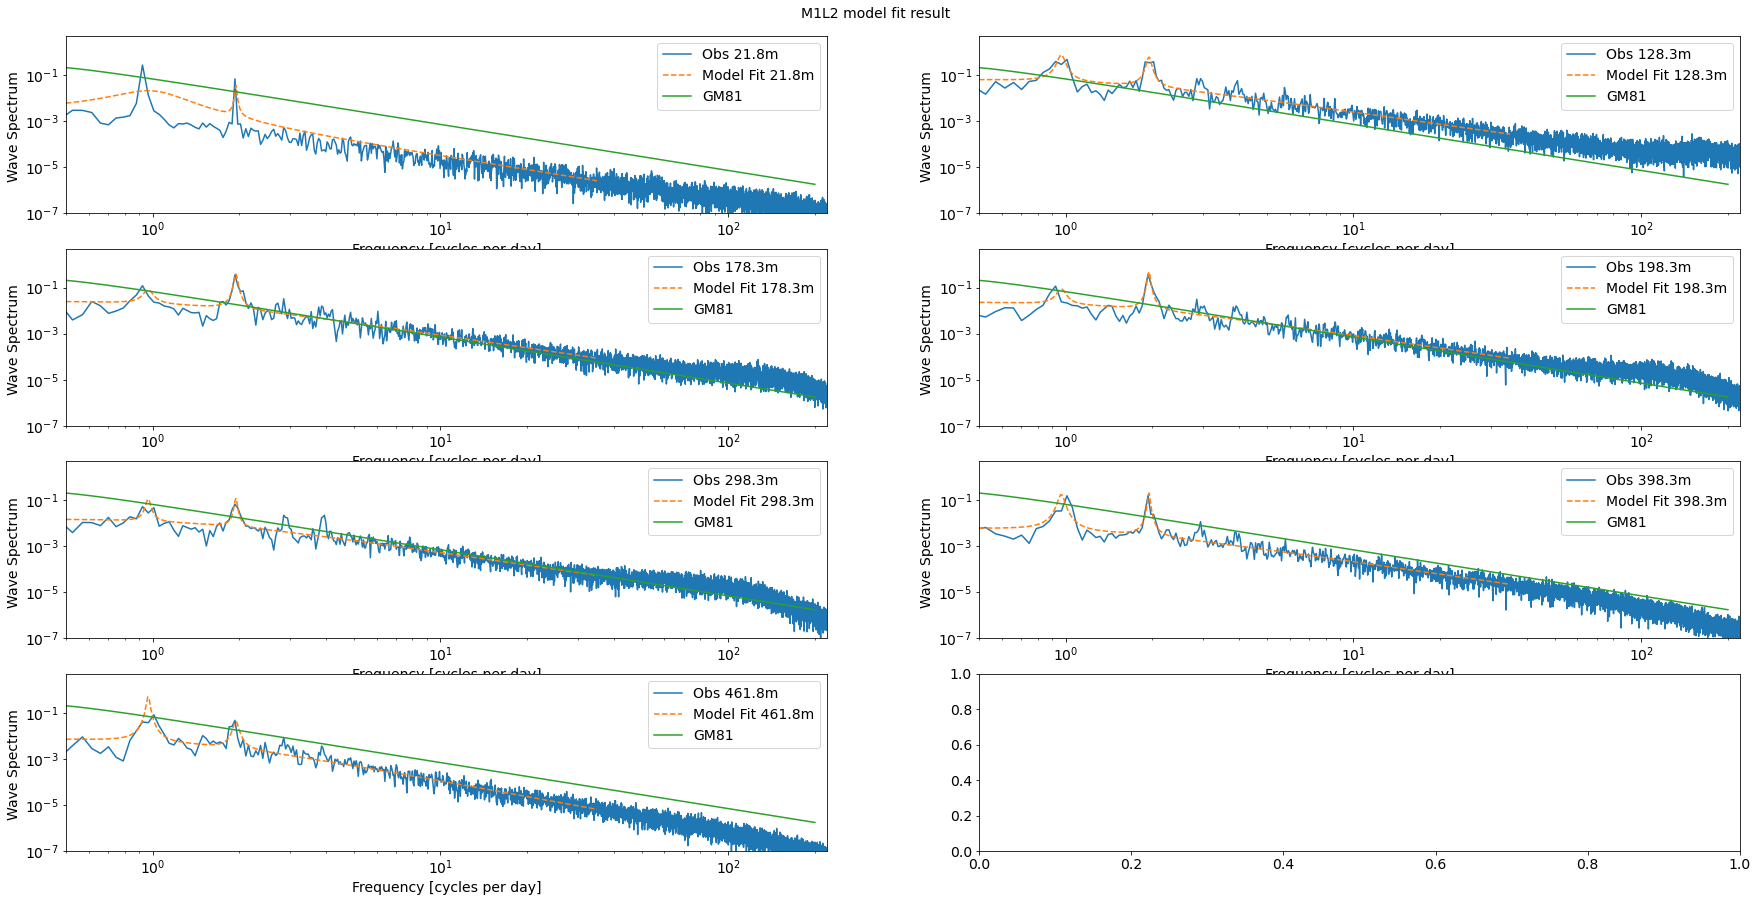

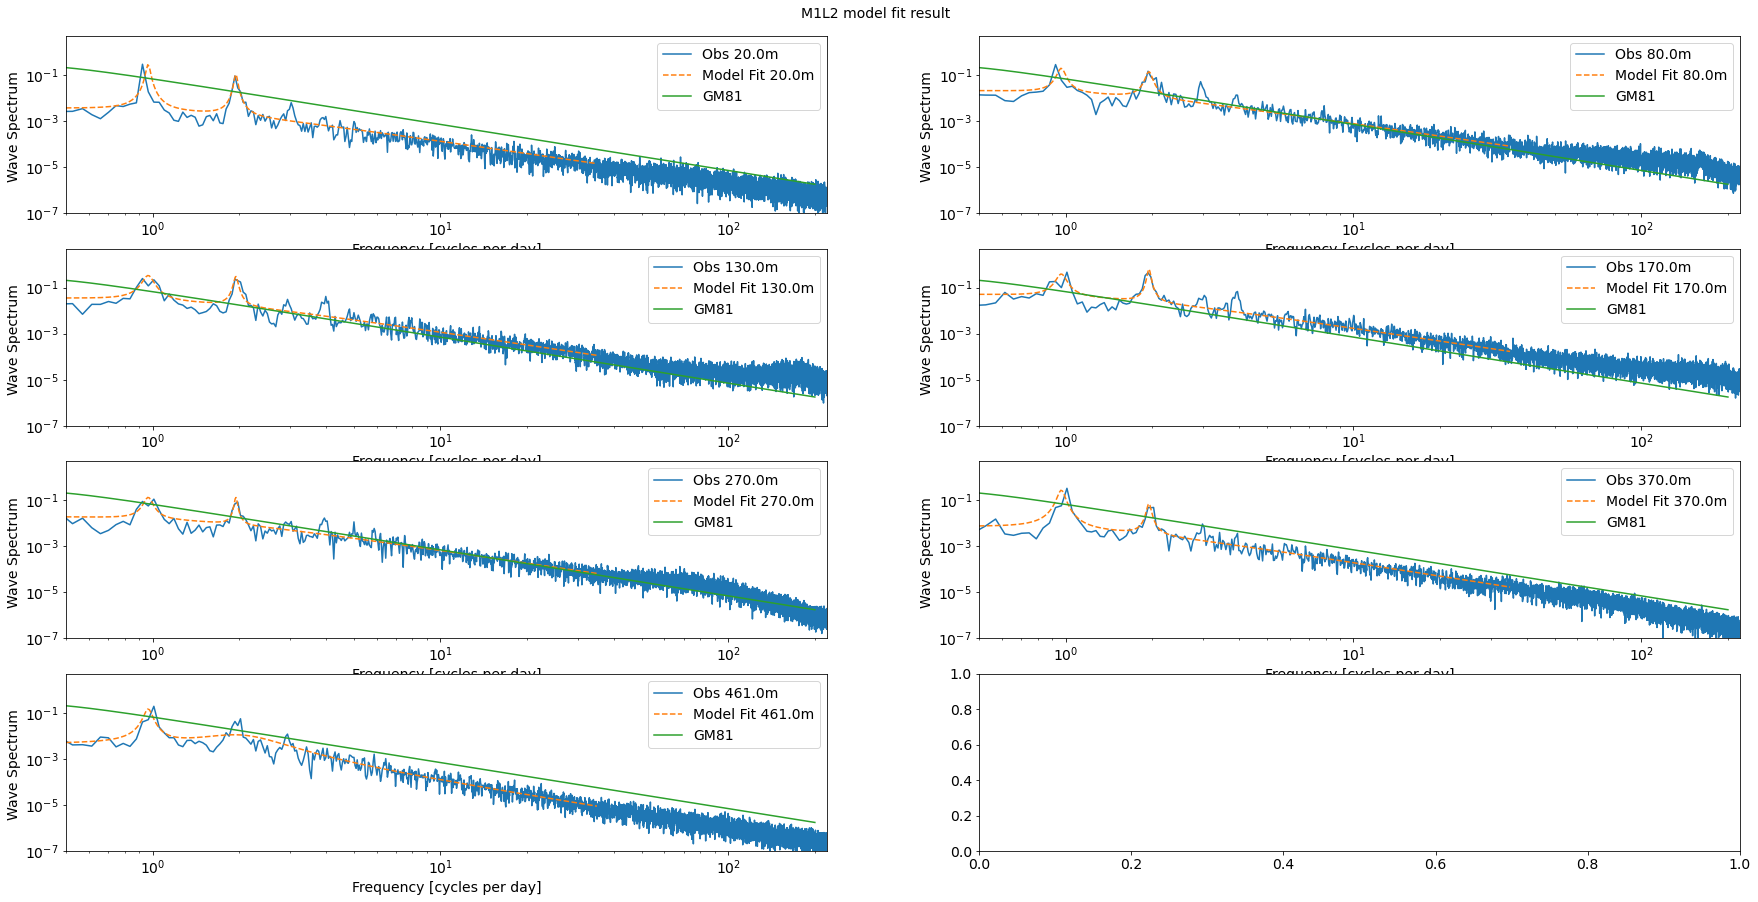

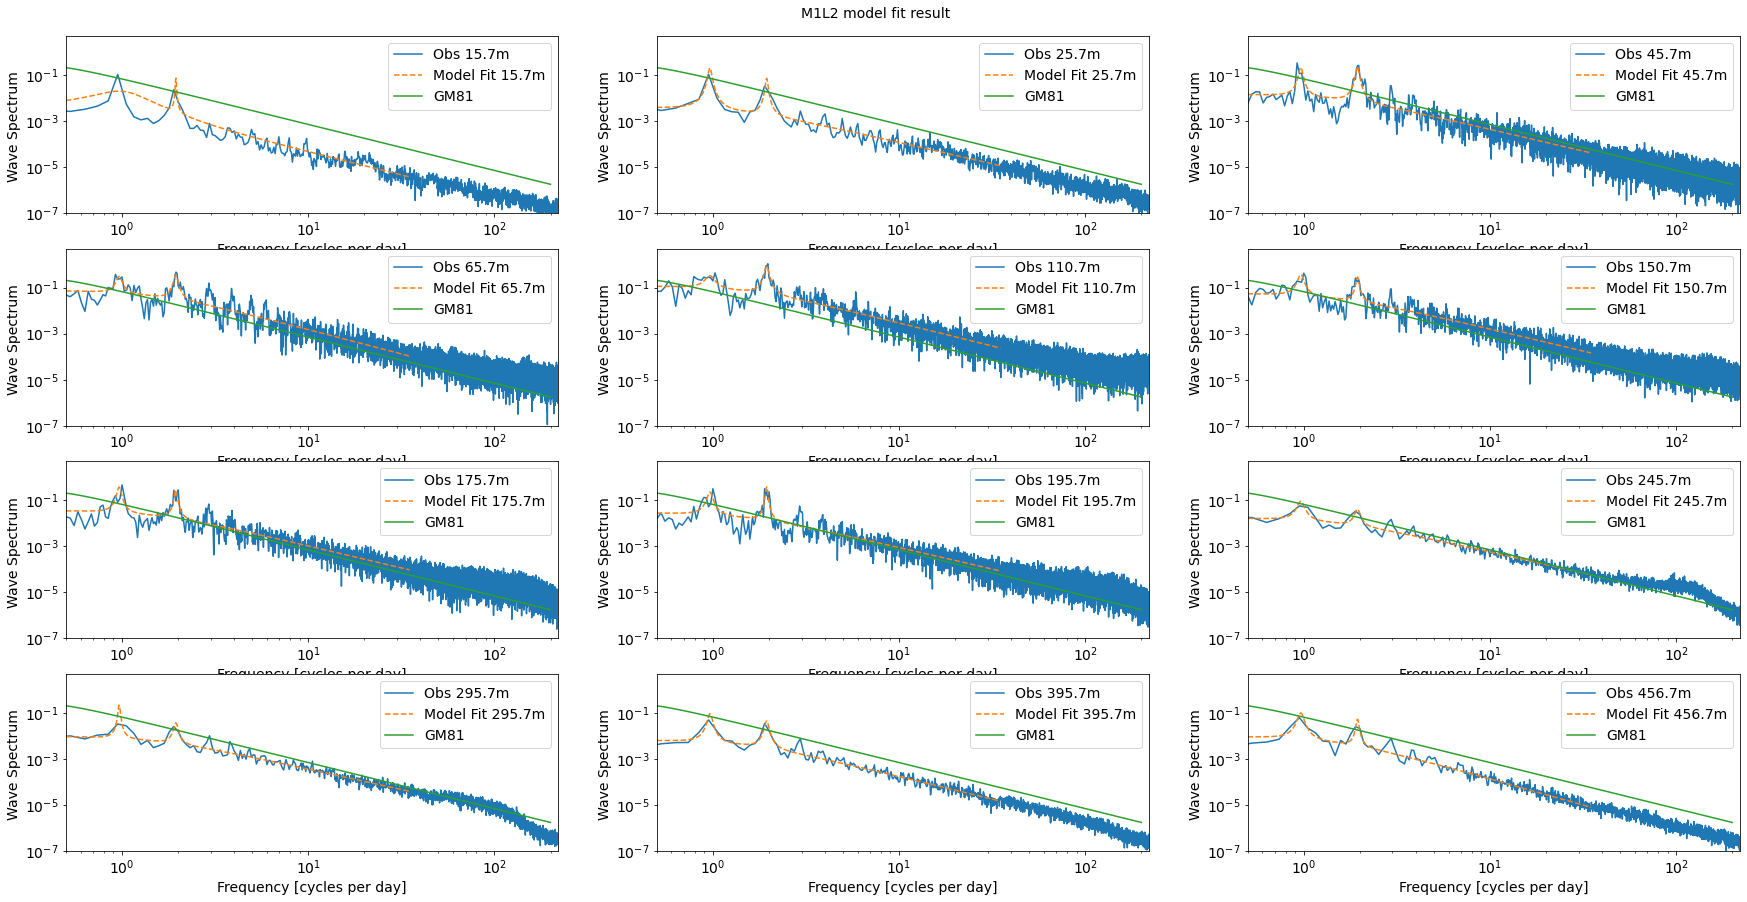

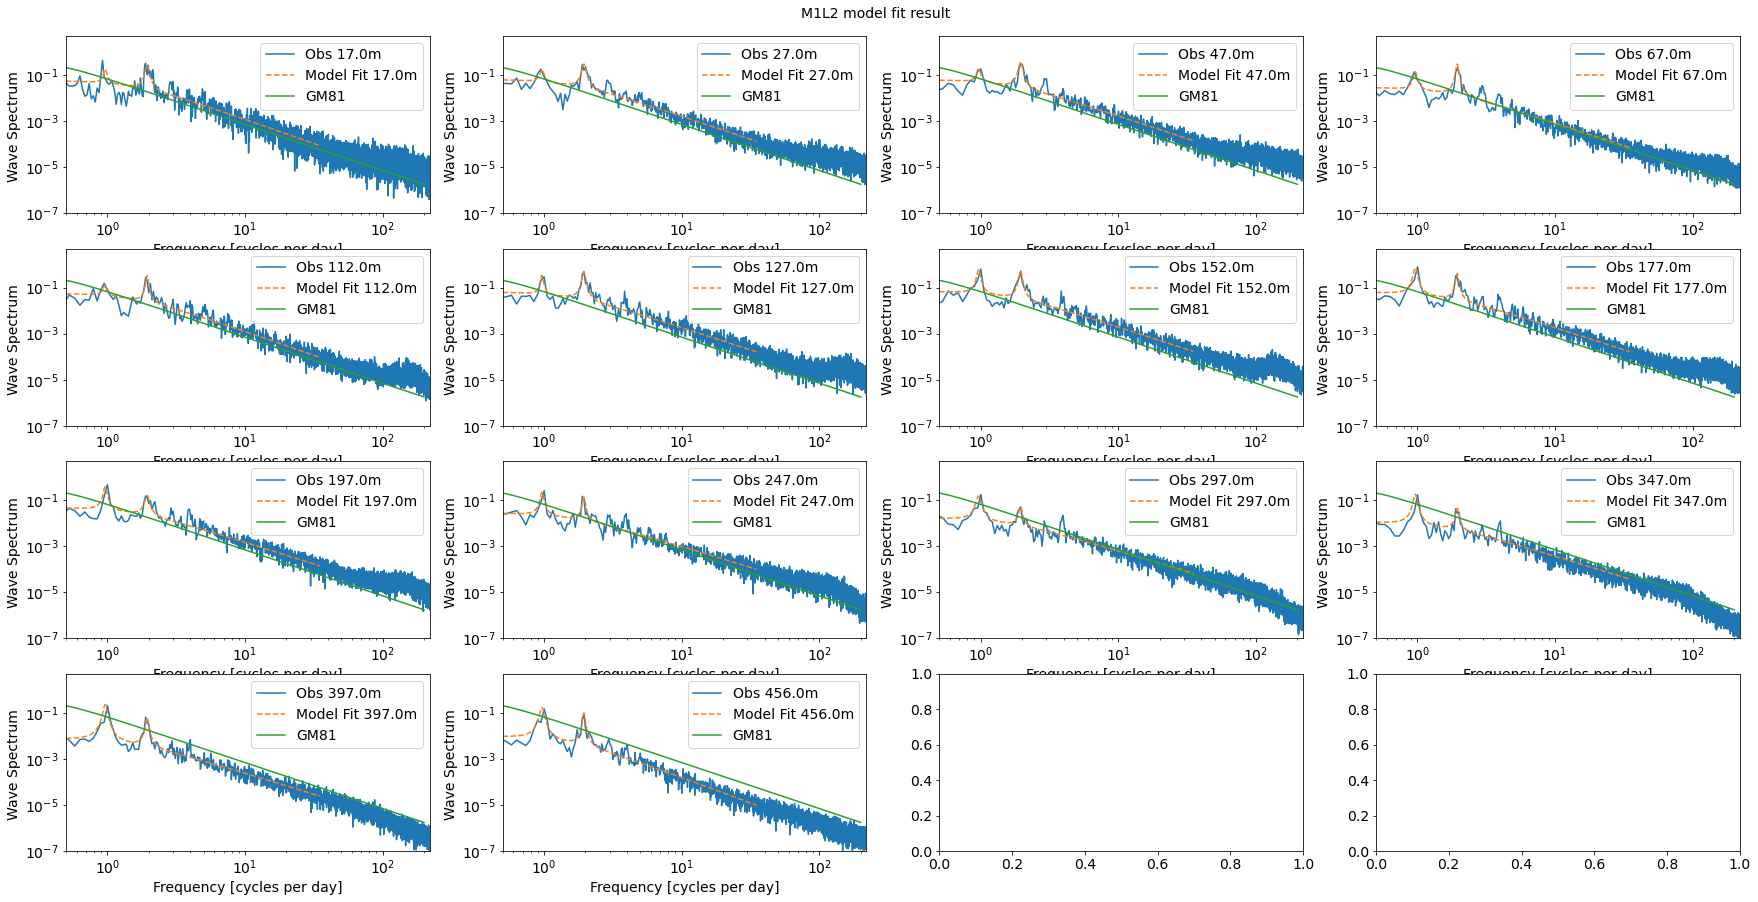

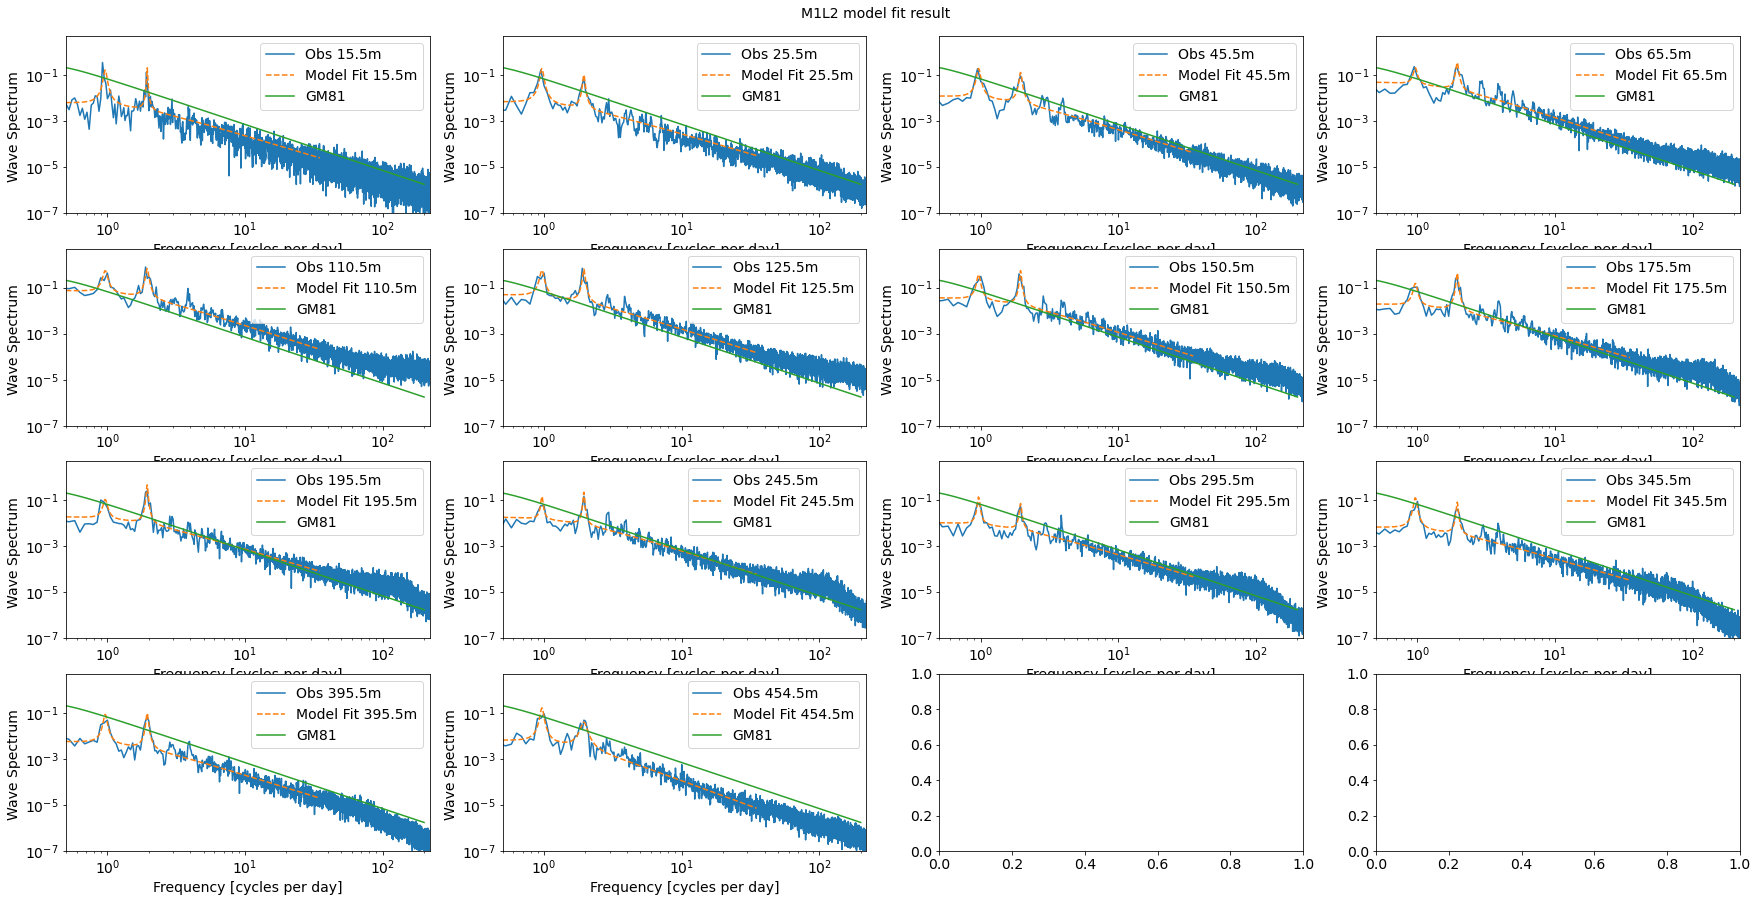

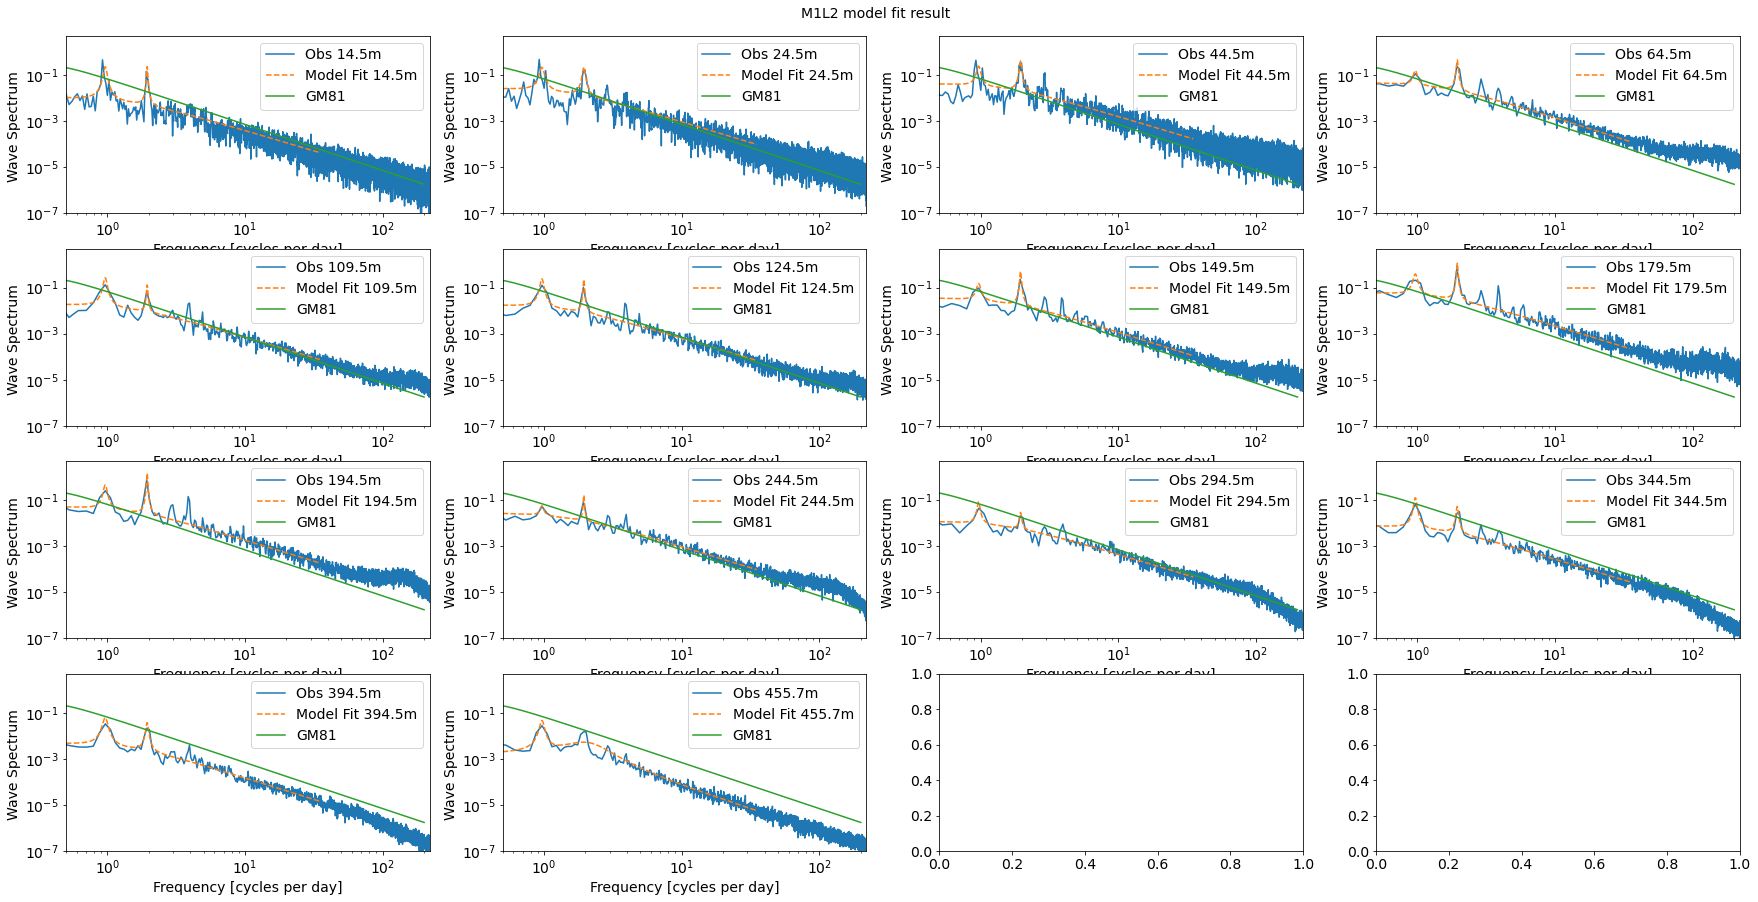

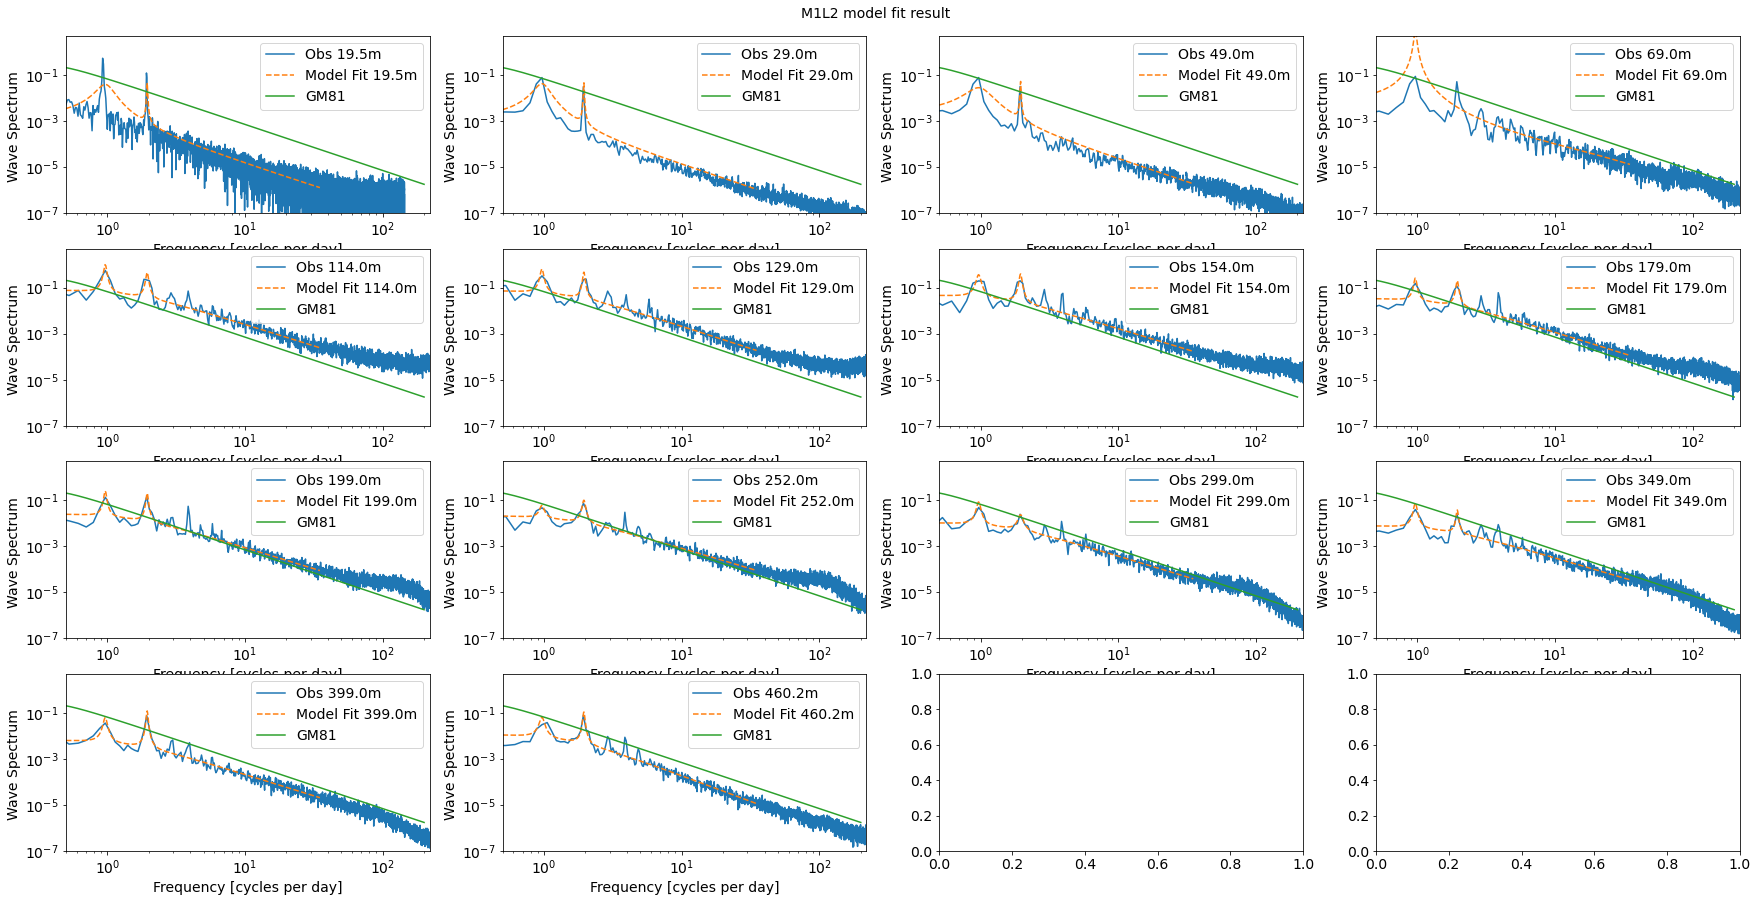

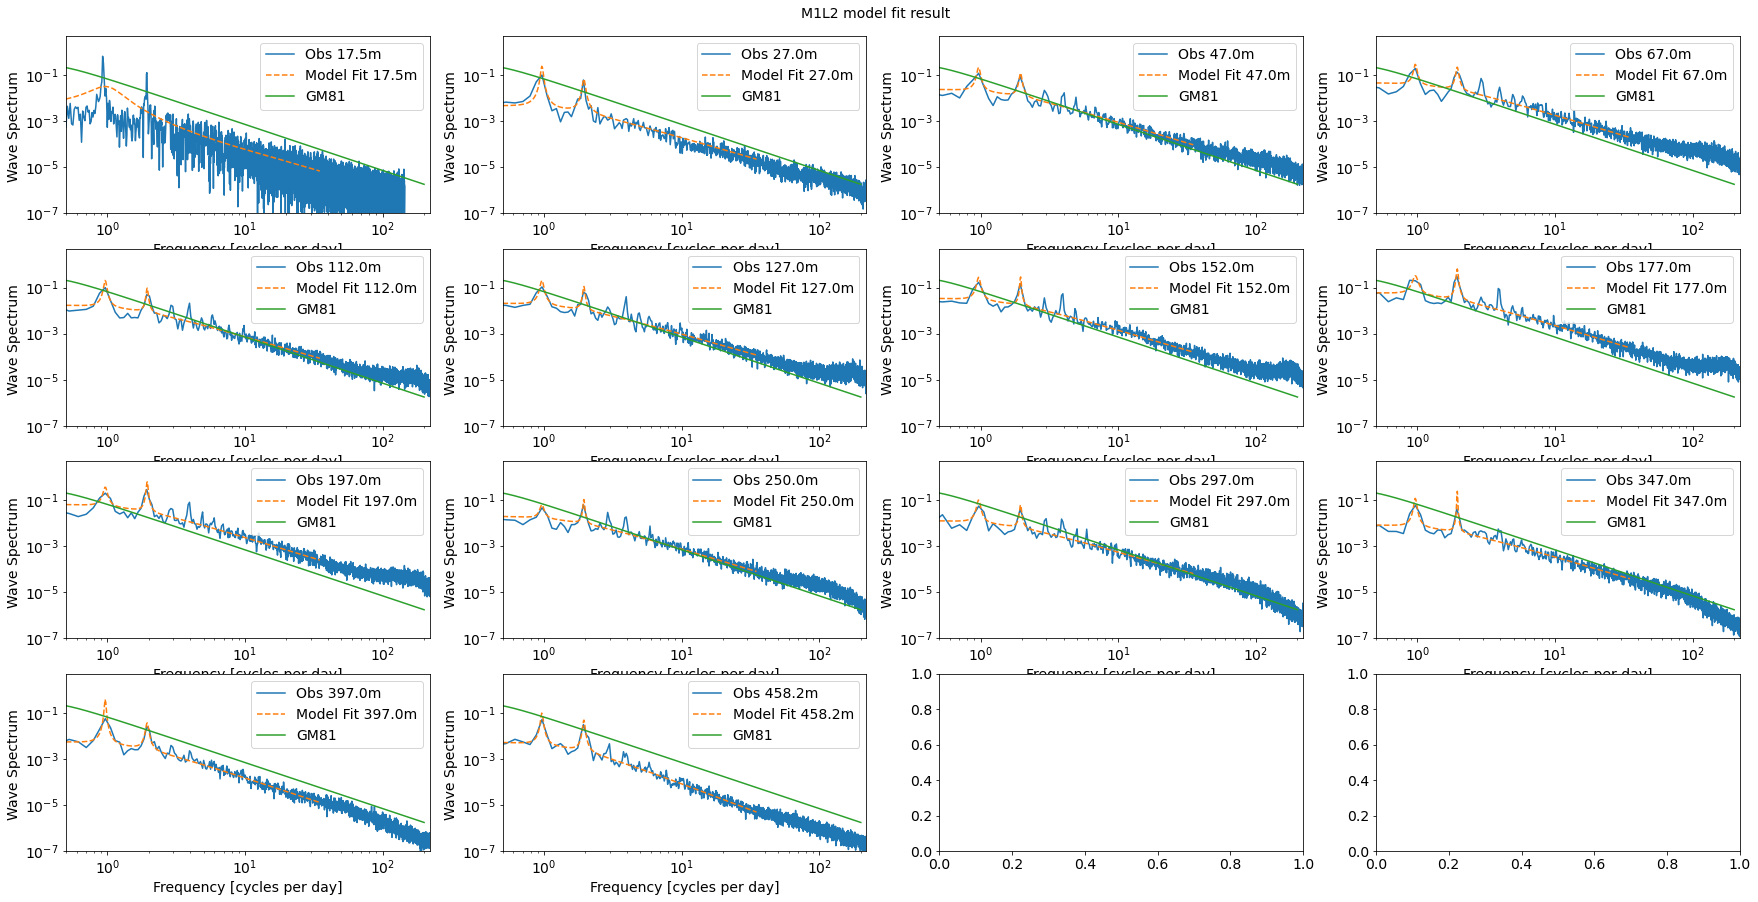

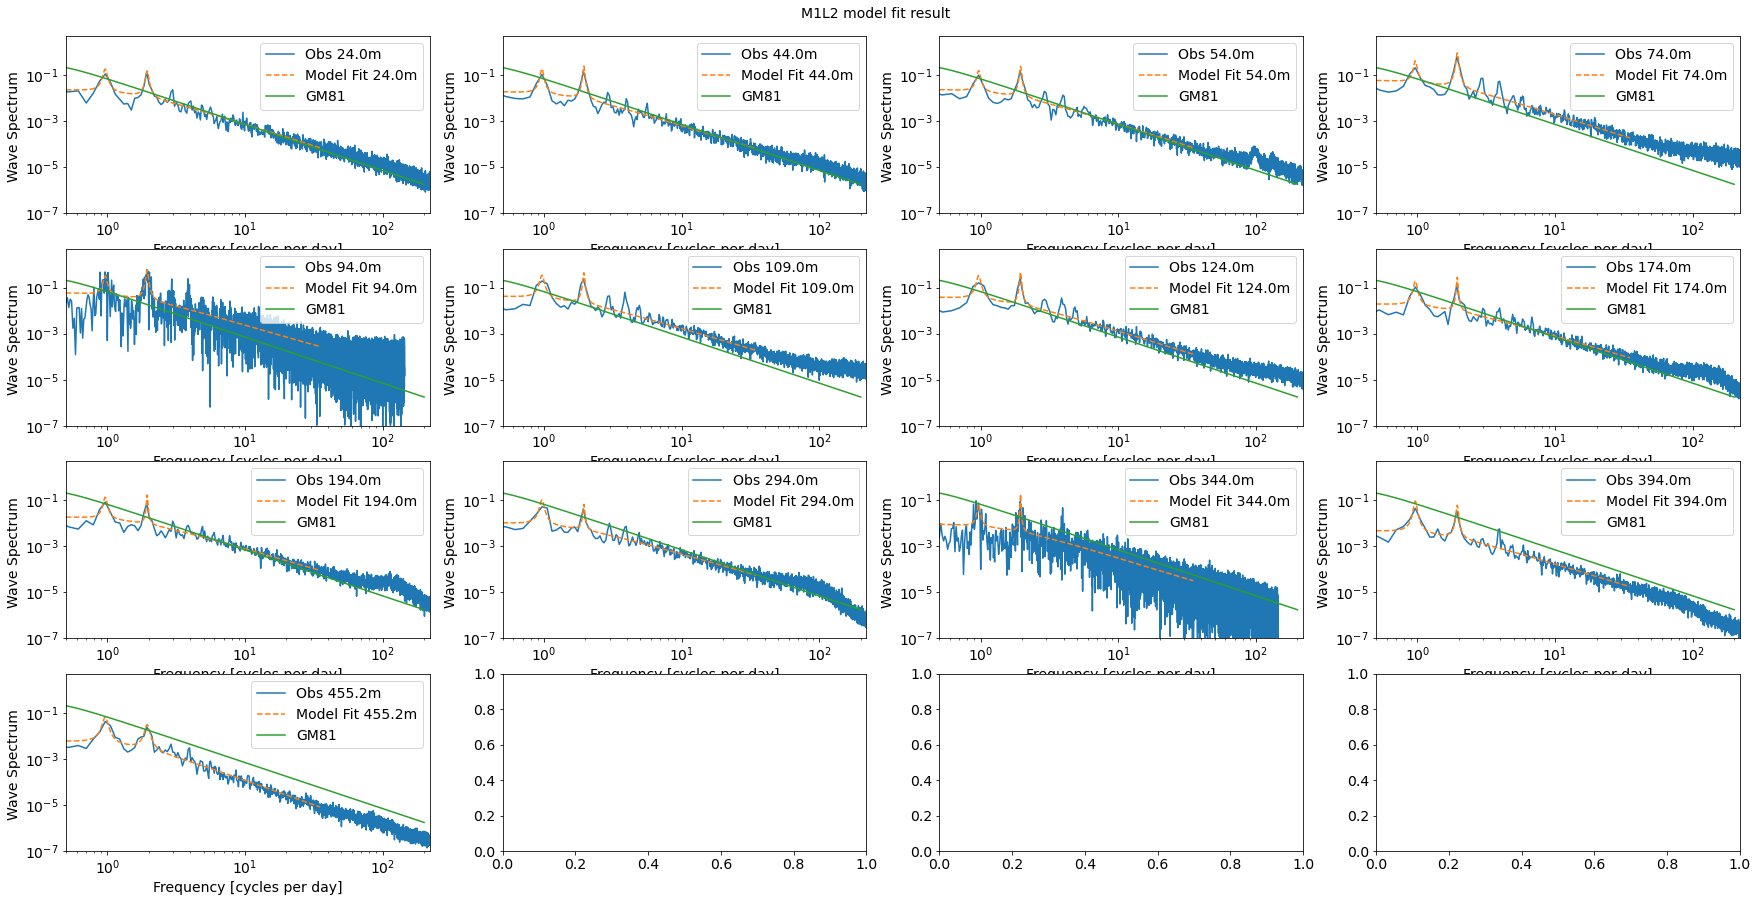

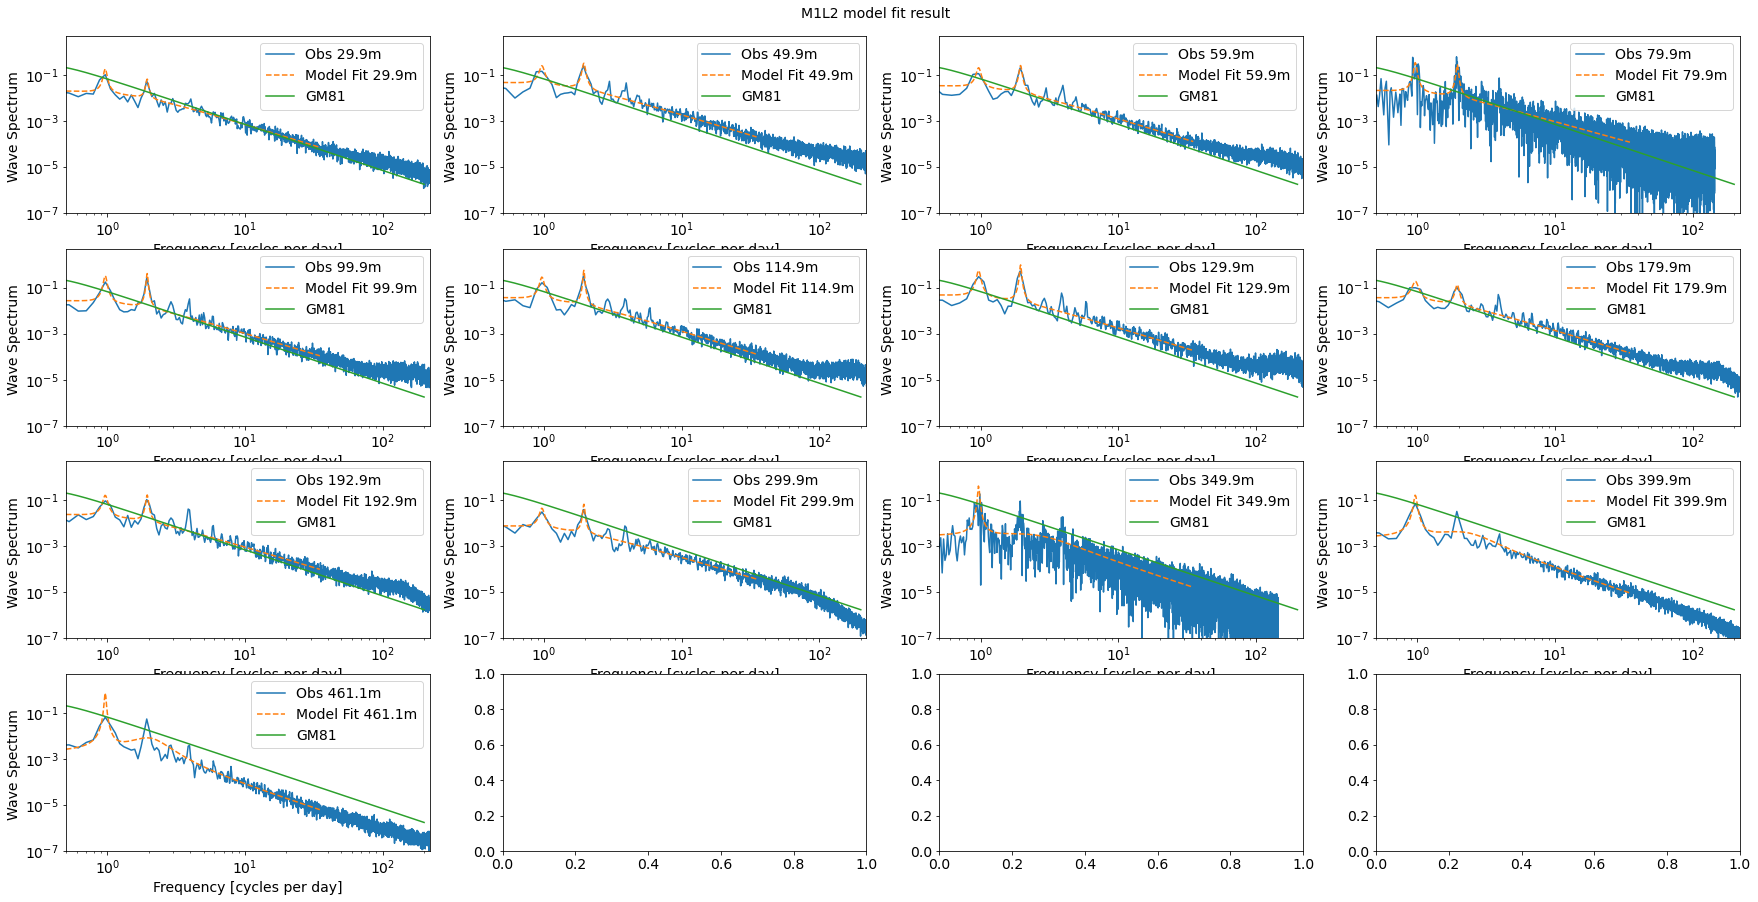

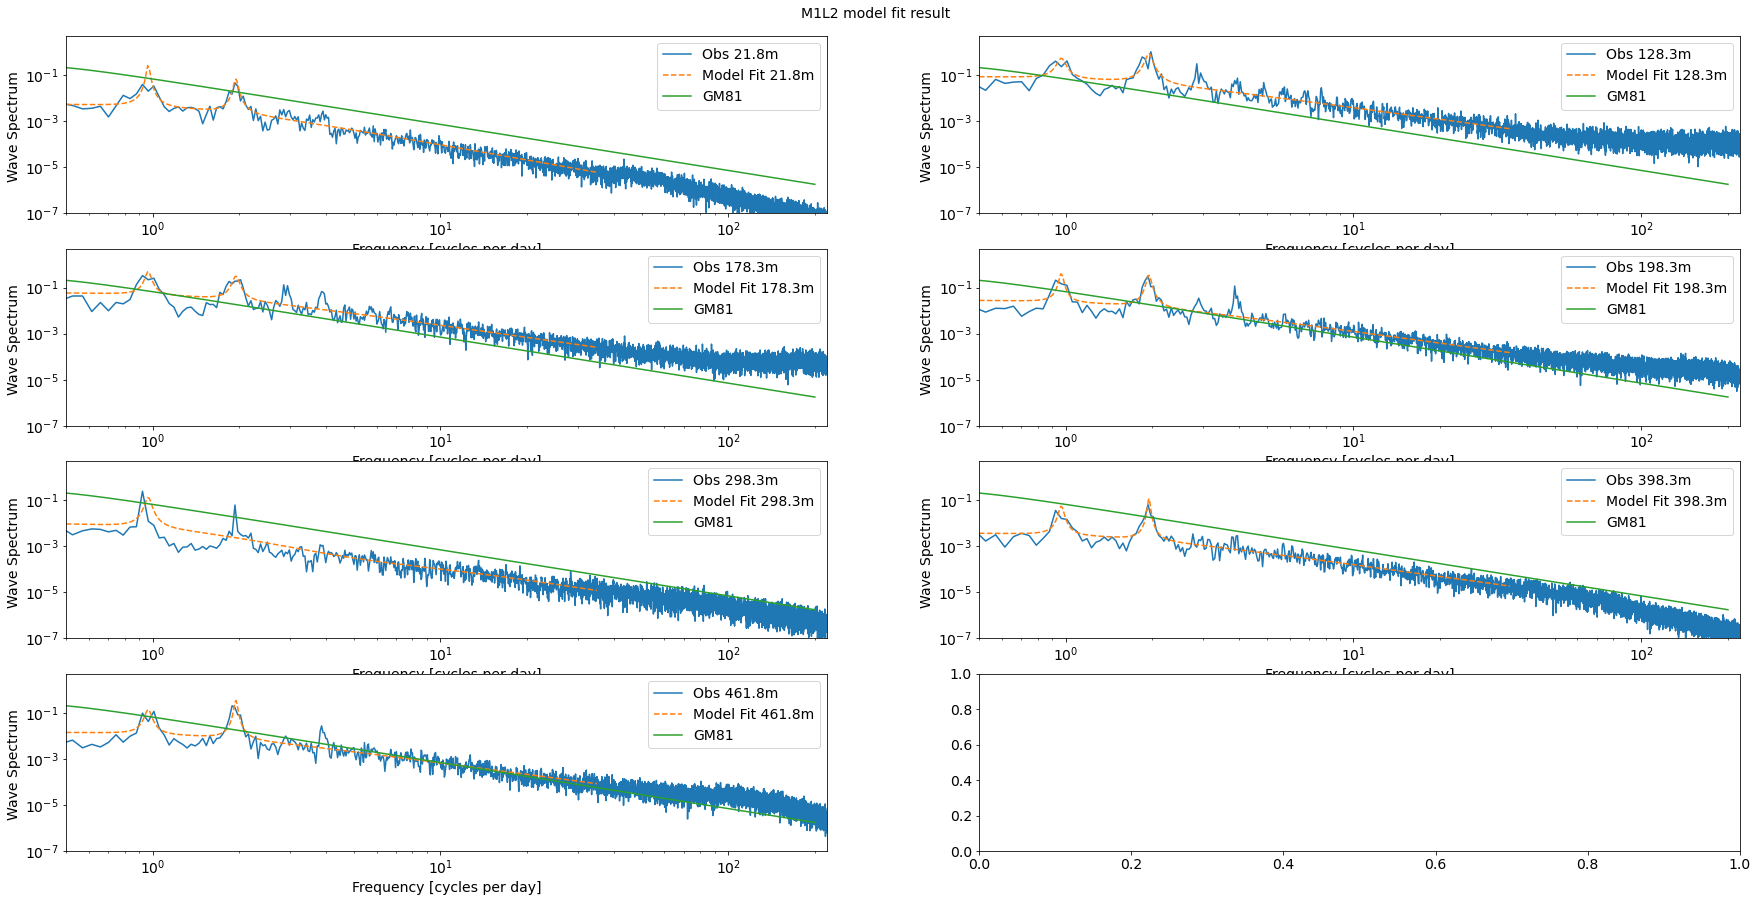

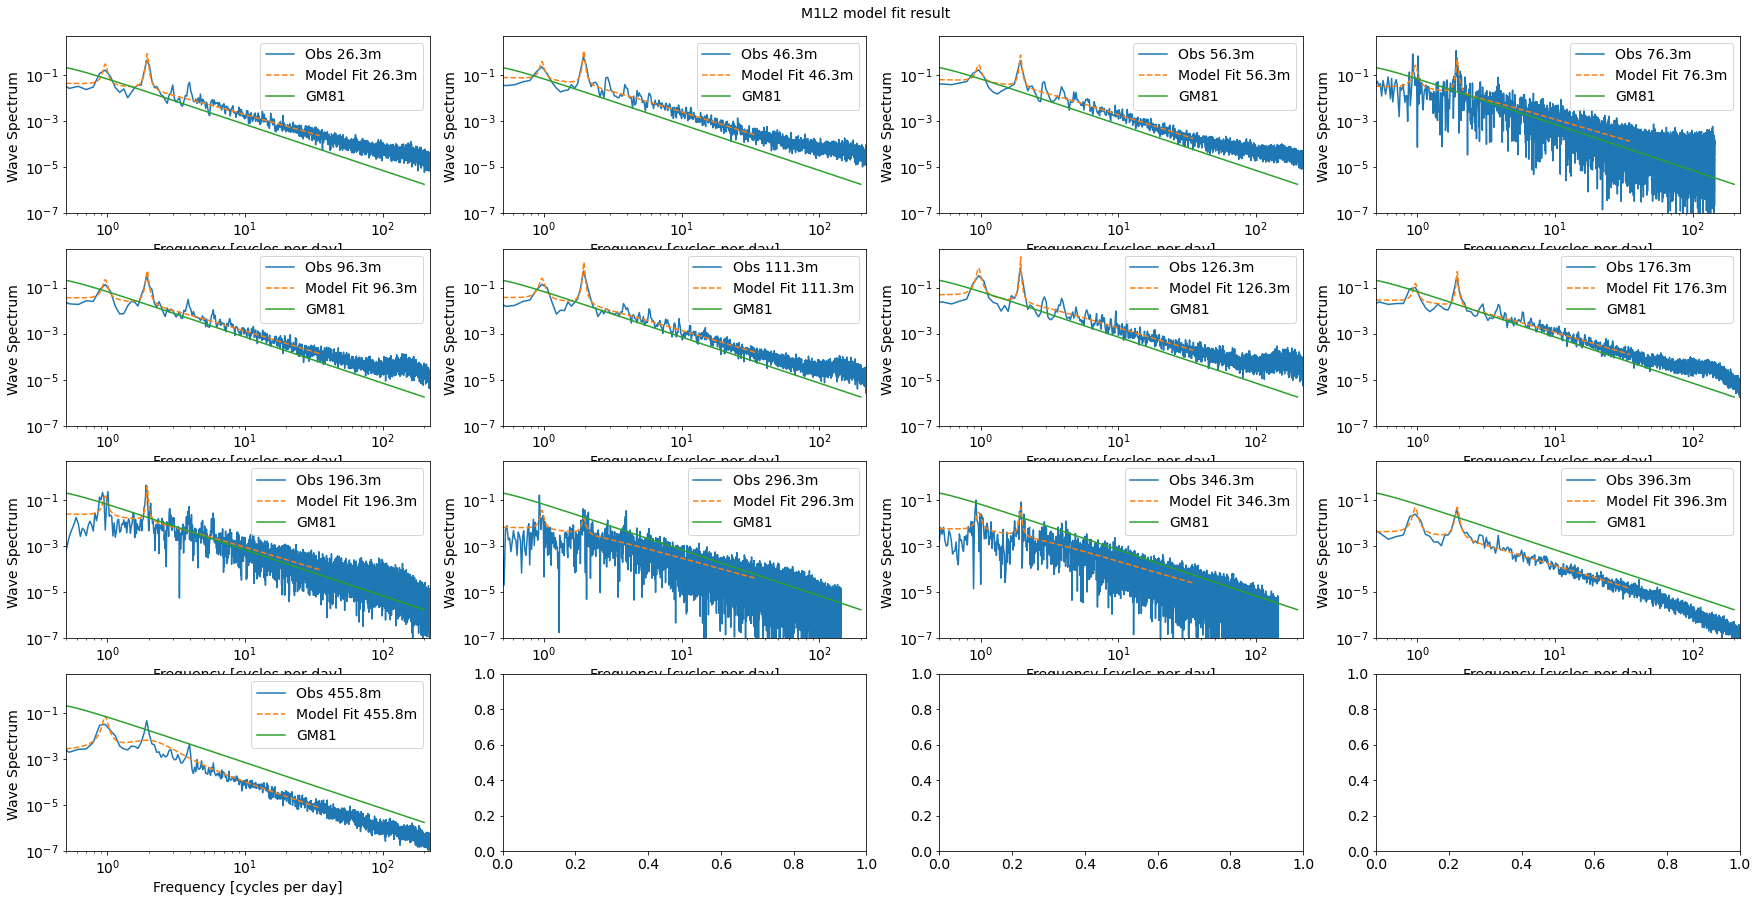

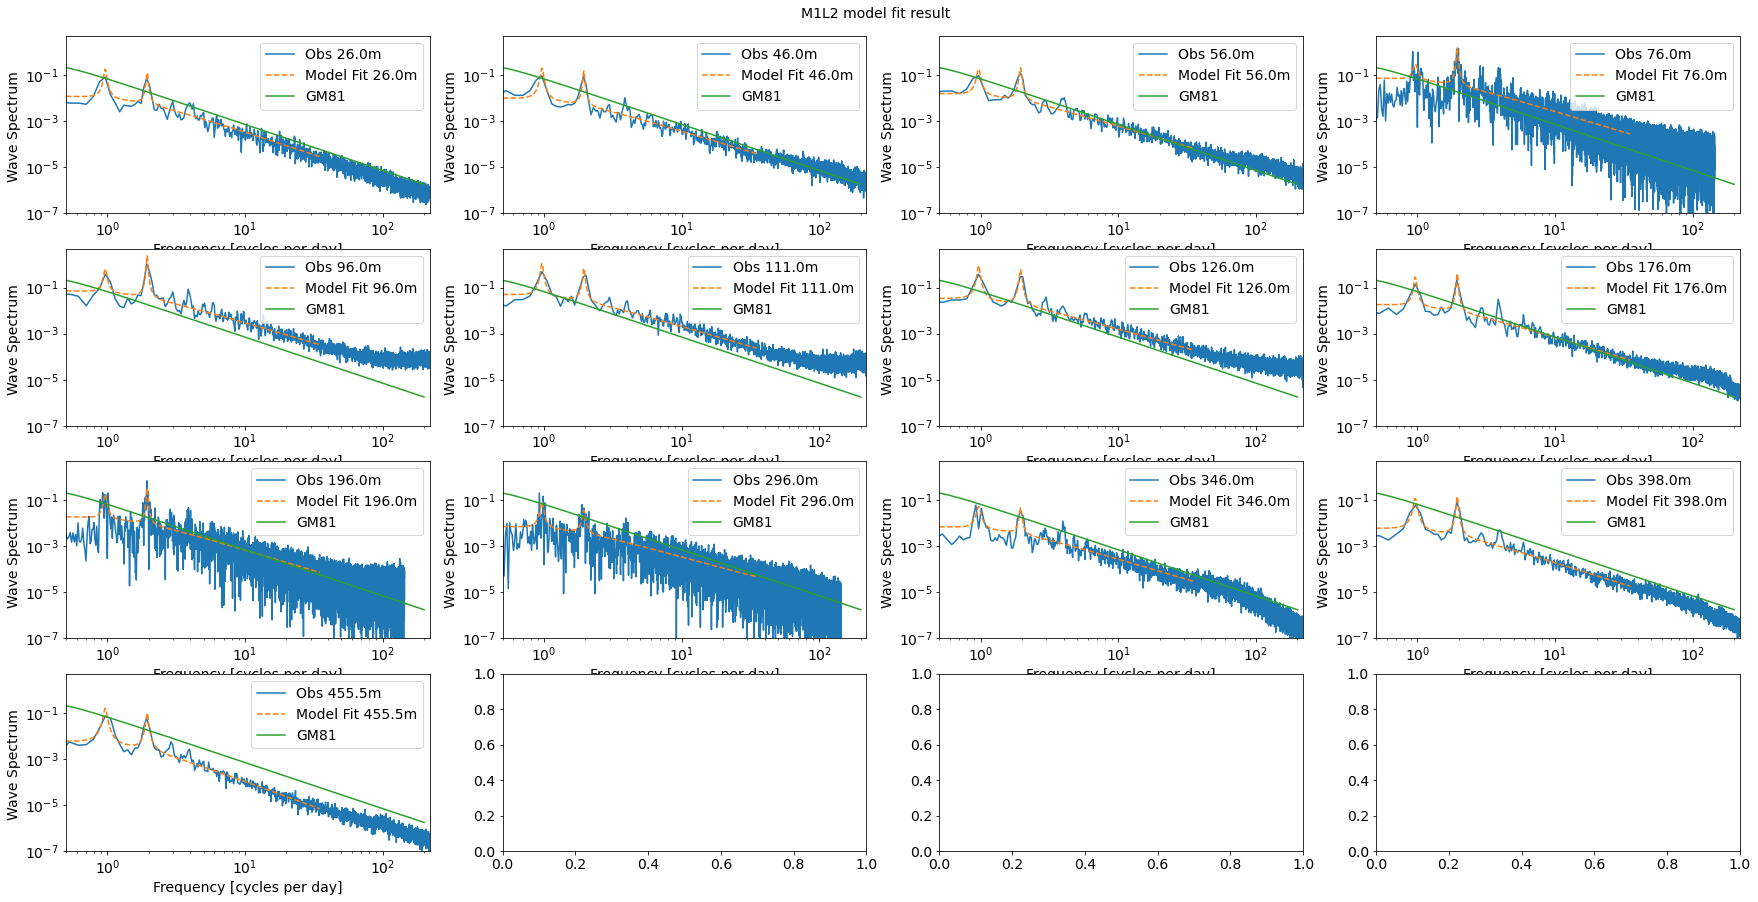

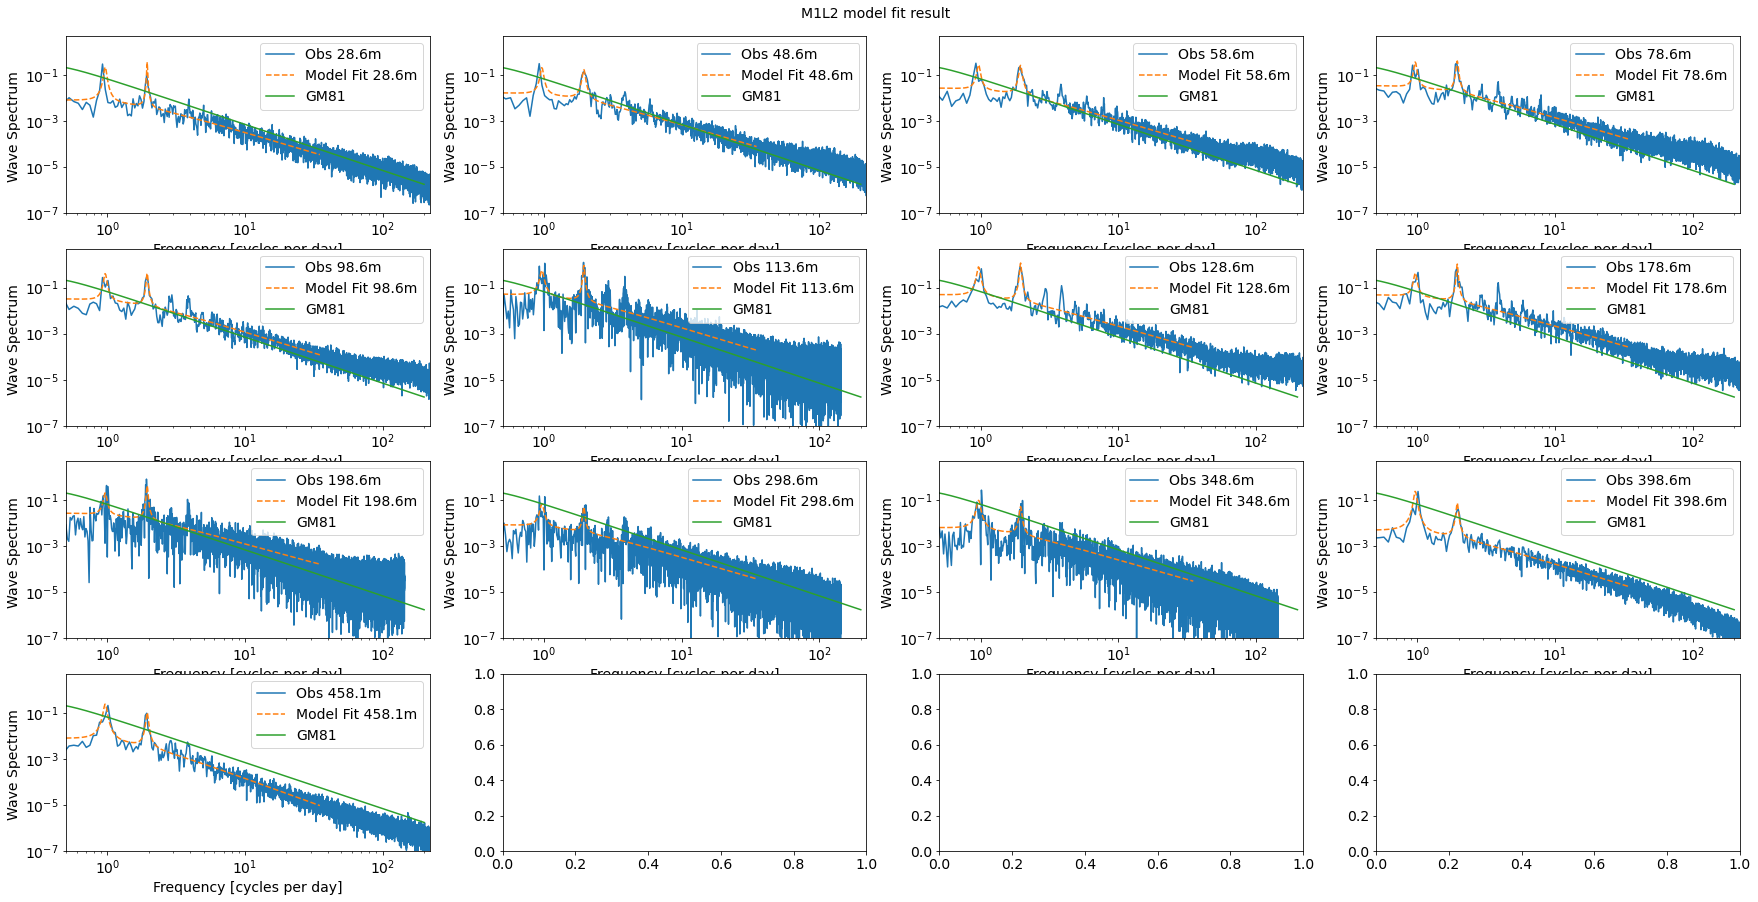

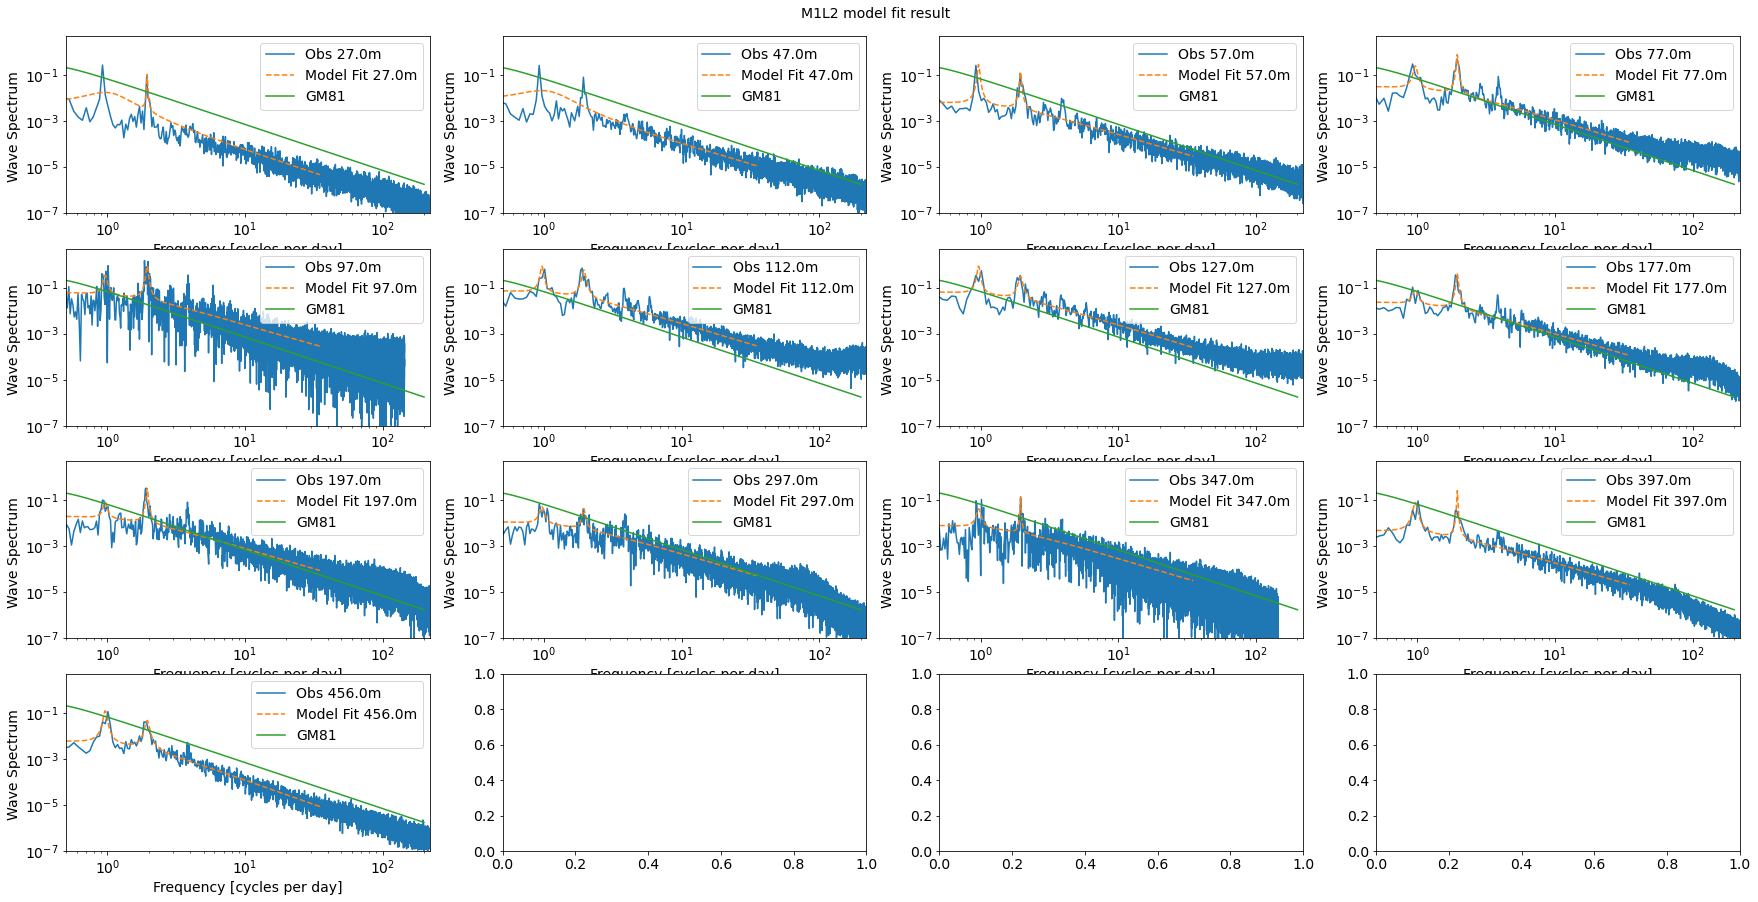

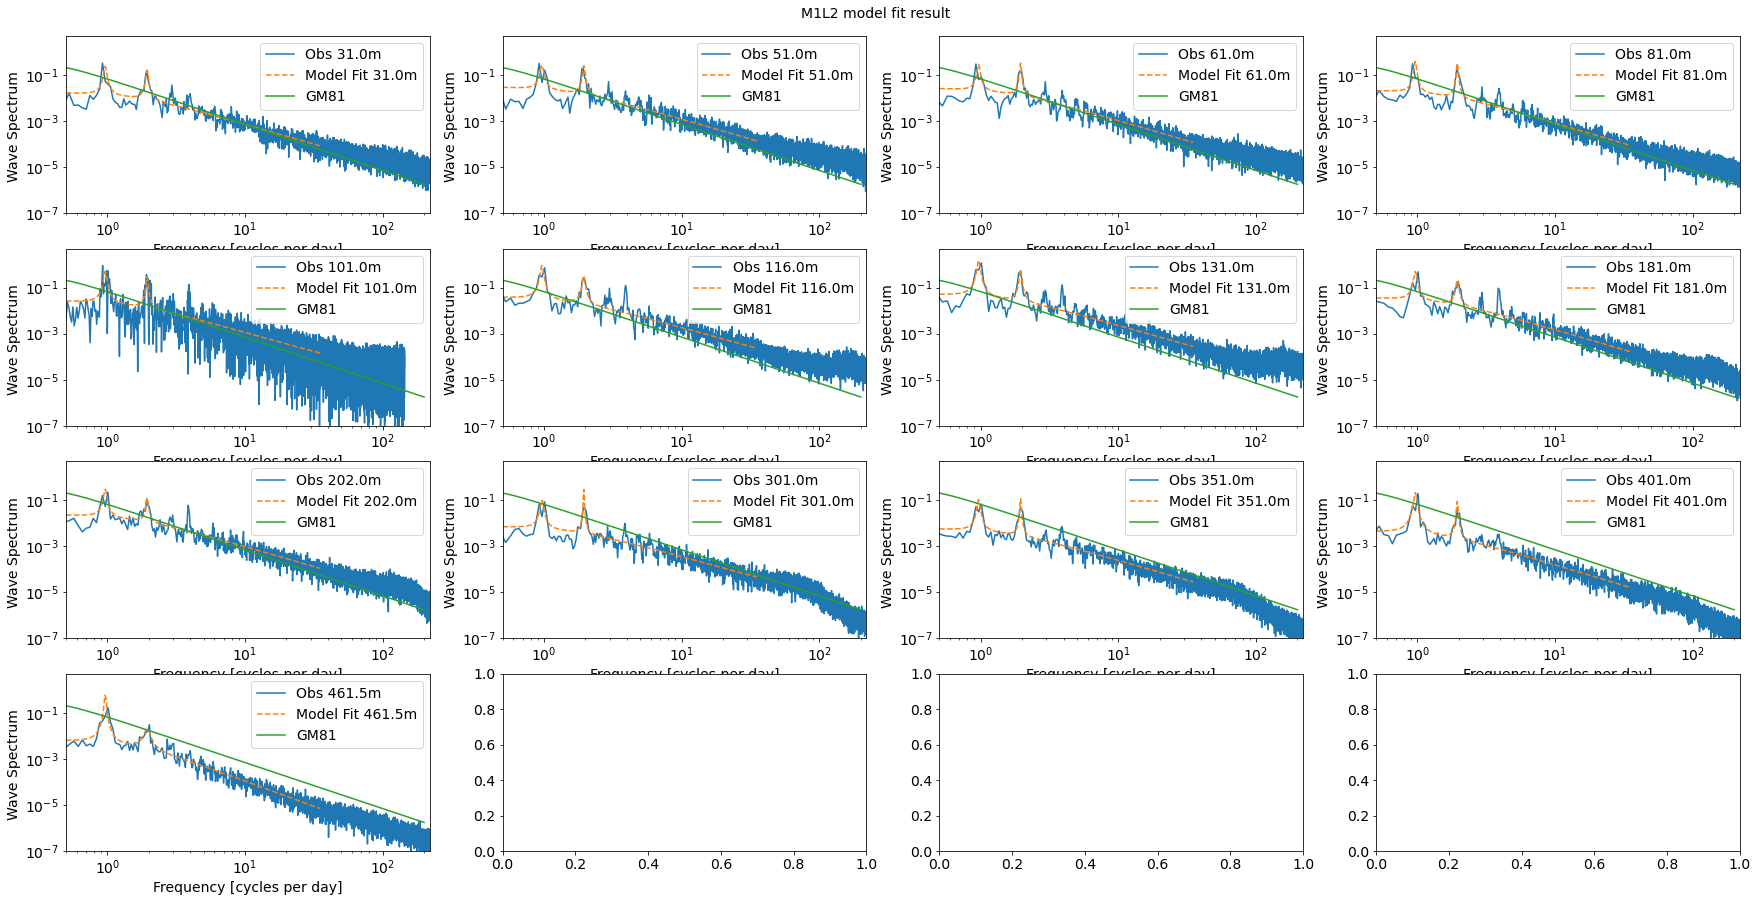

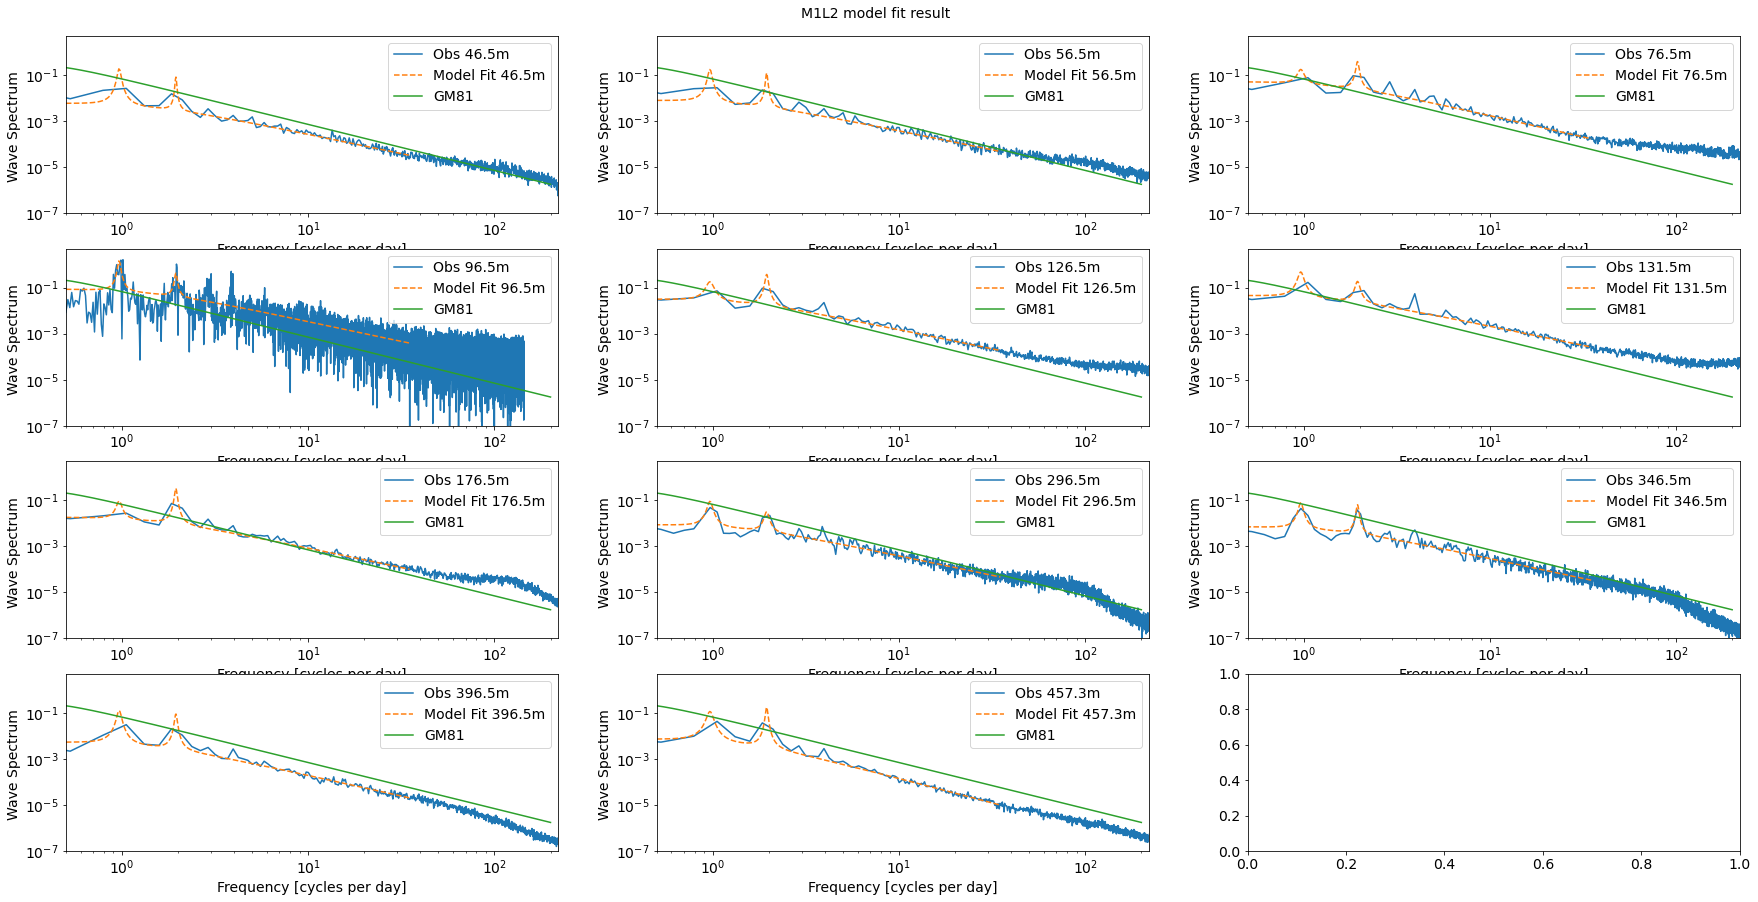

In [119]:
from functions import Plot_figure
#M1L2
Plot_figure.Plot_fit_result_over_depth(Depths_P1, F_w_P1, P_w_P1, 
                                       F_model_fit_list_P1_M1L2,P_model_fit_list_P1_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P2, F_w_P2, P_w_P2, 
                                       F_model_fit_list_P2_M1L2,P_model_fit_list_P2_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P3, F_w_P3, P_w_P3, 
                                       F_model_fit_list_P3_M1L2, P_model_fit_list_P3_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P4, F_w_P4, P_w_P4, 
                                       F_model_fit_list_P4_M1L2, P_model_fit_list_P4_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P5, F_w_P5, P_w_P5, 
                                       F_model_fit_list_P5_M1L2,P_model_fit_list_P5_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P6, F_w_P6, P_w_P6, 
                                       F_model_fit_list_P6_M1L2,P_model_fit_list_P6_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P7, F_w_P7, P_w_P7, 
                                       F_model_fit_list_P7_M1L2,P_model_fit_list_P7_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P8, F_w_P8, P_w_P8, 
                                       F_model_fit_list_P8_M1L2,P_model_fit_list_P8_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P9, F_w_P9, P_w_P9, 
                                       F_model_fit_list_P9_M1L2,P_model_fit_list_P9_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P10, F_w_P10, P_w_P10, 
                                       F_model_fit_list_P10_M1L2,P_model_fit_list_P10_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P1, F_w_P11, P_w_P11, 
                                       F_model_fit_list_P11_M1L2,P_model_fit_list_P11_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P12, F_w_P12, P_w_P12, 
                                       F_model_fit_list_P12_M1L2,P_model_fit_list_P12_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P13, F_w_P13, P_w_P13, 
                                       F_model_fit_list_P13_M1L2,P_model_fit_list_P13_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P14, F_w_P14, P_w_P14, 
                                       F_model_fit_list_P14_M1L2,P_model_fit_list_P14_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P15, F_w_P15, P_w_P15, 
                                       F_model_fit_list_P15_M1L2,P_model_fit_list_P15_M1L2, 
                                       omg*86400, GM_spectrum/86400, 'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P16, F_w_P16, P_w_P16, 
                                       F_model_fit_list_P16_M1L2,P_model_fit_list_P16_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P17, F_w_P17, P_w_P17, 
                                       F_model_fit_list_P17_M1L2,P_model_fit_list_P17_M1L2,
                                       omg*86400, GM_spectrum/86400,'M1L2')

In [120]:
# Plot_figure.Plot_fit_result_over_depth(Depths_P1, F_w_P1, P_w_P1, 
#                                        F_model_fit_list_P1_M1L1,P_model_fit_list_P1_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P2, F_w_P2, P_w_P2, 
#                                        F_model_fit_list_P2_M1L1,P_model_fit_list_P2_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P3, F_w_P3, P_w_P3, 
#                                        F_model_fit_list_P3_M1L1,P_model_fit_list_P3_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P4, F_w_P4, P_w_P4, 
#                                        F_model_fit_list_P4_M1L1,P_model_fit_list_P4_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P5, F_w_P5, P_w_P5, 
#                                        F_model_fit_list_P5_M1L1,P_model_fit_list_P5_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P6, F_w_P6, P_w_P6, 
#                                        F_model_fit_list_P6_M1L1,P_model_fit_list_P6_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P7, F_w_P7, P_w_P7, 
#                                        F_model_fit_list_P7_M1L1,P_model_fit_list_P7_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P8, F_w_P8, P_w_P8, 
#                                        F_model_fit_list_P8_M1L1,P_model_fit_list_P8_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P9, F_w_P9, P_w_P9, 
#                                        F_model_fit_list_P9_M1L1,P_model_fit_list_P9_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P10, F_w_P10, P_w_P10, 
#                                        F_model_fit_list_P10_M1L1,P_model_fit_list_P10_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P11, F_w_P11, P_w_P11, 
#                                        F_model_fit_list_P11_M1L1,P_model_fit_list_P11_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P12, F_w_P12, P_w_P12, 
#                                        F_model_fit_list_P12_M1L1,P_model_fit_list_P12_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P13, F_w_P13, P_w_P13, 
#                                        F_model_fit_list_P13_M1L1,P_model_fit_list_P13_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P14, F_w_P14, P_w_P14, 
#                                        F_model_fit_list_P14_M1L1,P_model_fit_list_P14_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P15, F_w_P15, P_w_P15, 
#                                        F_model_fit_list_P15_M1L1,P_model_fit_list_P15_M1L1, 
#                                        omg*86400, GM_spectrum/86400, 'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P16, F_w_P16, P_w_P16, 
#                                        F_model_fit_list_P16_M1L1,P_model_fit_list_P16_M1L1, 
#                                        omg*86400, GM_spectrum/86400,'M1L1')

# Plot_figure.Plot_fit_result_over_depth(Depths_P17, F_w_P17, P_w_P17, 
#                                        F_model_fit_list_P17_M1L1,P_model_fit_list_P17_M1L1,
#                                        omg*86400, GM_spectrum/86400,'M1L1')

In [121]:
Time_P6_Window[0][1]

array(['2013-03-03T09:59:59.999996672', '2013-03-03T10:01:39.999997440',
       '2013-03-03T10:03:19.999998208', ...,
       '2013-05-22T09:56:39.999995136', '2013-05-22T09:58:19.999995904',
       '2013-05-22T09:59:59.999996672'], dtype='datetime64[ns]')

In [122]:
import pickle
#P6: 2012-12 - 2013-6
Sorted_Depths_P6 = Depths_P6.copy()
Sorted_Depths_P6.sort()
Sorted_Depths_P6 = [Sorted_Depths_P6[3], Sorted_Depths_P6[len(Sorted_Depths_P6)//2], Sorted_Depths_P6[-3]]

idx_list = []
for i in range(len(Sorted_Depths_P6)):
    depth = Sorted_Depths_P6[i]
    idx_list.append(Depths_P6.index(depth))

#for the second half
data = {'Sorted_Depths': Sorted_Depths_P6,
        'F_obs': [F_w_P6[i][1] for i in idx_list],
        'P_obs': [P_w_P6[i][1] for i in idx_list],
        'F_model_fit': [F_model_fit_list_P6_M1L2[i][1] for i in idx_list],
        'P_model_fit': [P_model_fit_list_P6_M1L2[i][1] for i in idx_list],
        'F_gm': omg*86400,
        'P_gm': GM_spectrum/86400,        },


# Save the data
with open('ITFTIS model fit P6.pkl', 'wb') as f:
    pickle.dump(data, f)

# Result Analysis

## Calculate whittle value sequentially

In [123]:
#define diurnal peak freq and bandwidth
diurnal_peak_freq      = 1 #cpd
diurnal_peak_bandwidth = 0.3
#define semidiurnal peak freq and bandwidth
semidiurnal_peak_freq      = 2 #cpd
semidiurnal_peak_bandwidth = 0.5

In [124]:
subset_p_P1_diurnal_peak      = Processing.Subset_peak(F_p_P1,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P1_diurnal_peak      = Processing.Subset_peak(F_w_P1,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P1_semidiurnal_peak  = Processing.Subset_peak(F_p_P1,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P1_semidiurnal_peak  = Processing.Subset_peak(F_w_P1,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P1_residual          = Processing.Subset_residual(subset_p_P1_diurnal_peak,subset_p_P1_semidiurnal_peak,subset_p_P1 )
subset_w_P1_residual          = Processing.Subset_residual(subset_w_P1_diurnal_peak,subset_w_P1_semidiurnal_peak,subset_w_P1 )

F_p_P1_L1_peak  = Processing.Select_frequency(F_p_P1,subset_p_P1_diurnal_peak)
P_p_P1_L1_peak  = Processing.Select_frequency(P_p_P1,subset_p_P1_diurnal_peak )
F_p_P1_L2_peak  = Processing.Select_frequency(F_p_P1,subset_p_P1_semidiurnal_peak  )
P_p_P1_L2_peak  = Processing.Select_frequency(P_p_P1,subset_p_P1_semidiurnal_peak  )
F_p_P1_residual = Processing.Select_frequency(F_p_P1,subset_p_P1_residual )
P_p_P1_residual = Processing.Select_frequency(P_p_P1,subset_p_P1_residual )

In [125]:
subset_p_P2_diurnal_peak      = Processing.Subset_peak(F_p_P2,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P2_diurnal_peak      = Processing.Subset_peak(F_w_P2,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P2_semidiurnal_peak  = Processing.Subset_peak(F_p_P2,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P2_semidiurnal_peak  = Processing.Subset_peak(F_w_P2,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P2_residual          = Processing.Subset_residual(subset_p_P2_diurnal_peak,subset_p_P2_semidiurnal_peak,subset_p_P2 )
subset_w_P2_residual          = Processing.Subset_residual(subset_w_P2_diurnal_peak,subset_w_P2_semidiurnal_peak,subset_w_P2 )

F_p_P2_L1_peak  = Processing.Select_frequency(F_p_P2,subset_p_P2_diurnal_peak)
P_p_P2_L1_peak  = Processing.Select_frequency(P_p_P2,subset_p_P2_diurnal_peak )
F_p_P2_L2_peak  = Processing.Select_frequency(F_p_P2,subset_p_P2_semidiurnal_peak  )
P_p_P2_L2_peak  = Processing.Select_frequency(P_p_P2,subset_p_P2_semidiurnal_peak  )
F_p_P2_residual = Processing.Select_frequency(F_p_P2,subset_p_P2_residual )
P_p_P2_residual = Processing.Select_frequency(P_p_P2,subset_p_P2_residual )

In [126]:
subset_p_P3_diurnal_peak      = Processing.Subset_peak(F_p_P3,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P3_diurnal_peak      = Processing.Subset_peak(F_w_P3,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P3_semidiurnal_peak  = Processing.Subset_peak(F_p_P3,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P3_semidiurnal_peak  = Processing.Subset_peak(F_w_P3,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P3_residual          = Processing.Subset_residual(subset_p_P3_diurnal_peak,subset_p_P3_semidiurnal_peak,subset_p_P3 )
subset_w_P3_residual          = Processing.Subset_residual(subset_w_P3_diurnal_peak,subset_w_P3_semidiurnal_peak,subset_w_P3 )

F_p_P3_L1_peak  = Processing.Select_frequency(F_p_P3,subset_p_P3_diurnal_peak)
P_p_P3_L1_peak  = Processing.Select_frequency(P_p_P3,subset_p_P3_diurnal_peak )
F_p_P3_L2_peak  = Processing.Select_frequency(F_p_P3,subset_p_P3_semidiurnal_peak  )
P_p_P3_L2_peak  = Processing.Select_frequency(P_p_P3,subset_p_P3_semidiurnal_peak  )
F_p_P3_residual = Processing.Select_frequency(F_p_P3,subset_p_P3_residual )
P_p_P3_residual = Processing.Select_frequency(P_p_P3,subset_p_P3_residual )

In [127]:
subset_p_P4_diurnal_peak      = Processing.Subset_peak(F_p_P4,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P4_diurnal_peak      = Processing.Subset_peak(F_w_P4,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P4_semidiurnal_peak  = Processing.Subset_peak(F_p_P4,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P4_semidiurnal_peak  = Processing.Subset_peak(F_w_P4,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P4_residual          = Processing.Subset_residual(subset_p_P4_diurnal_peak,subset_p_P4_semidiurnal_peak,subset_p_P4 )
subset_w_P4_residual          = Processing.Subset_residual(subset_w_P4_diurnal_peak,subset_w_P4_semidiurnal_peak,subset_w_P4 )

F_p_P4_L1_peak  = Processing.Select_frequency(F_p_P4,subset_p_P4_diurnal_peak)
P_p_P4_L1_peak  = Processing.Select_frequency(P_p_P4,subset_p_P4_diurnal_peak )
F_p_P4_L2_peak  = Processing.Select_frequency(F_p_P4,subset_p_P4_semidiurnal_peak  )
P_p_P4_L2_peak  = Processing.Select_frequency(P_p_P4,subset_p_P4_semidiurnal_peak  )
F_p_P4_residual = Processing.Select_frequency(F_p_P4,subset_p_P4_residual )
P_p_P4_residual = Processing.Select_frequency(P_p_P4,subset_p_P4_residual )

In [128]:
subset_p_P5_diurnal_peak      = Processing.Subset_peak(F_p_P5,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P5_diurnal_peak      = Processing.Subset_peak(F_w_P5,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P5_semidiurnal_peak  = Processing.Subset_peak(F_p_P5,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P5_semidiurnal_peak  = Processing.Subset_peak(F_w_P5,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P5_residual          = Processing.Subset_residual(subset_p_P5_diurnal_peak,subset_p_P5_semidiurnal_peak,subset_p_P5 )
subset_w_P5_residual          = Processing.Subset_residual(subset_w_P5_diurnal_peak,subset_w_P5_semidiurnal_peak,subset_w_P5 )

F_p_P5_L1_peak  = Processing.Select_frequency(F_p_P5,subset_p_P5_diurnal_peak)
P_p_P5_L1_peak  = Processing.Select_frequency(P_p_P5,subset_p_P5_diurnal_peak )
F_p_P5_L2_peak  = Processing.Select_frequency(F_p_P5,subset_p_P5_semidiurnal_peak  )
P_p_P5_L2_peak  = Processing.Select_frequency(P_p_P5,subset_p_P5_semidiurnal_peak  )
F_p_P5_residual = Processing.Select_frequency(F_p_P5,subset_p_P5_residual )
P_p_P5_residual = Processing.Select_frequency(P_p_P5,subset_p_P5_residual )

In [129]:
subset_p_P6_diurnal_peak      = Processing.Subset_peak(F_p_P6,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P6_diurnal_peak      = Processing.Subset_peak(F_w_P6,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P6_semidiurnal_peak  = Processing.Subset_peak(F_p_P6,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P6_semidiurnal_peak  = Processing.Subset_peak(F_w_P6,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P6_residual          = Processing.Subset_residual(subset_p_P6_diurnal_peak,subset_p_P6_semidiurnal_peak,subset_p_P6 )
subset_w_P6_residual          = Processing.Subset_residual(subset_w_P6_diurnal_peak,subset_w_P6_semidiurnal_peak,subset_w_P6 )

F_p_P6_L1_peak  = Processing.Select_frequency(F_p_P6,subset_p_P6_diurnal_peak)
P_p_P6_L1_peak  = Processing.Select_frequency(P_p_P6,subset_p_P6_diurnal_peak )
F_p_P6_L2_peak  = Processing.Select_frequency(F_p_P6,subset_p_P6_semidiurnal_peak  )
P_p_P6_L2_peak  = Processing.Select_frequency(P_p_P6,subset_p_P6_semidiurnal_peak  )
F_p_P6_residual = Processing.Select_frequency(F_p_P6,subset_p_P6_residual )
P_p_P6_residual = Processing.Select_frequency(P_p_P6,subset_p_P6_residual )

In [130]:
subset_p_P7_diurnal_peak      = Processing.Subset_peak(F_p_P7,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P7_diurnal_peak      = Processing.Subset_peak(F_w_P7,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P7_semidiurnal_peak  = Processing.Subset_peak(F_p_P7,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P7_semidiurnal_peak  = Processing.Subset_peak(F_w_P7,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P7_residual          = Processing.Subset_residual(subset_p_P7_diurnal_peak,subset_p_P7_semidiurnal_peak,subset_p_P7 )
subset_w_P7_residual          = Processing.Subset_residual(subset_w_P7_diurnal_peak,subset_w_P7_semidiurnal_peak,subset_w_P7 )

F_p_P7_L1_peak  = Processing.Select_frequency(F_p_P7,subset_p_P7_diurnal_peak)
P_p_P7_L1_peak  = Processing.Select_frequency(P_p_P7,subset_p_P7_diurnal_peak )
F_p_P7_L2_peak  = Processing.Select_frequency(F_p_P7,subset_p_P7_semidiurnal_peak  )
P_p_P7_L2_peak  = Processing.Select_frequency(P_p_P7,subset_p_P7_semidiurnal_peak  )
F_p_P7_residual = Processing.Select_frequency(F_p_P7,subset_p_P7_residual )
P_p_P7_residual = Processing.Select_frequency(P_p_P7,subset_p_P7_residual )

In [131]:
subset_p_P8_diurnal_peak      = Processing.Subset_peak(F_p_P8,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P8_diurnal_peak      = Processing.Subset_peak(F_w_P8,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P8_semidiurnal_peak  = Processing.Subset_peak(F_p_P8,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P8_semidiurnal_peak  = Processing.Subset_peak(F_w_P8,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P8_residual          = Processing.Subset_residual(subset_p_P8_diurnal_peak,subset_p_P8_semidiurnal_peak,subset_p_P8 )
subset_w_P8_residual          = Processing.Subset_residual(subset_w_P8_diurnal_peak,subset_w_P8_semidiurnal_peak,subset_w_P8 )

F_p_P8_L1_peak  = Processing.Select_frequency(F_p_P8,subset_p_P8_diurnal_peak)
P_p_P8_L1_peak  = Processing.Select_frequency(P_p_P8,subset_p_P8_diurnal_peak )
F_p_P8_L2_peak  = Processing.Select_frequency(F_p_P8,subset_p_P8_semidiurnal_peak  )
P_p_P8_L2_peak  = Processing.Select_frequency(P_p_P8,subset_p_P8_semidiurnal_peak  )
F_p_P8_residual = Processing.Select_frequency(F_p_P8,subset_p_P8_residual )
P_p_P8_residual = Processing.Select_frequency(P_p_P8,subset_p_P8_residual )

In [132]:
subset_p_P9_diurnal_peak      = Processing.Subset_peak(F_p_P9,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P9_diurnal_peak      = Processing.Subset_peak(F_w_P9,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P9_semidiurnal_peak  = Processing.Subset_peak(F_p_P9,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P9_semidiurnal_peak  = Processing.Subset_peak(F_w_P9,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P9_residual          = Processing.Subset_residual(subset_p_P9_diurnal_peak,subset_p_P9_semidiurnal_peak,subset_p_P9 )
subset_w_P9_residual          = Processing.Subset_residual(subset_w_P9_diurnal_peak,subset_w_P9_semidiurnal_peak,subset_w_P9 )

F_p_P9_L1_peak  = Processing.Select_frequency(F_p_P9,subset_p_P9_diurnal_peak)
P_p_P9_L1_peak  = Processing.Select_frequency(P_p_P9,subset_p_P9_diurnal_peak )
F_p_P9_L2_peak  = Processing.Select_frequency(F_p_P9,subset_p_P9_semidiurnal_peak  )
P_p_P9_L2_peak  = Processing.Select_frequency(P_p_P9,subset_p_P9_semidiurnal_peak  )
F_p_P9_residual = Processing.Select_frequency(F_p_P9,subset_p_P9_residual )
P_p_P9_residual = Processing.Select_frequency(P_p_P9,subset_p_P9_residual )

In [133]:
subset_p_P10_diurnal_peak      = Processing.Subset_peak(F_p_P10,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P10_diurnal_peak      = Processing.Subset_peak(F_w_P10,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P10_semidiurnal_peak  = Processing.Subset_peak(F_p_P10,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P10_semidiurnal_peak  = Processing.Subset_peak(F_w_P10,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P10_residual          = Processing.Subset_residual(subset_p_P10_diurnal_peak,subset_p_P10_semidiurnal_peak,subset_p_P10 )
subset_w_P10_residual          = Processing.Subset_residual(subset_w_P10_diurnal_peak,subset_w_P10_semidiurnal_peak,subset_w_P10 )

F_p_P10_L1_peak  = Processing.Select_frequency(F_p_P10,subset_p_P10_diurnal_peak)
P_p_P10_L1_peak  = Processing.Select_frequency(P_p_P10,subset_p_P10_diurnal_peak )
F_p_P10_L2_peak  = Processing.Select_frequency(F_p_P10,subset_p_P10_semidiurnal_peak  )
P_p_P10_L2_peak  = Processing.Select_frequency(P_p_P10,subset_p_P10_semidiurnal_peak  )
F_p_P10_residual = Processing.Select_frequency(F_p_P10,subset_p_P10_residual )
P_p_P10_residual = Processing.Select_frequency(P_p_P10,subset_p_P10_residual )

In [134]:
subset_p_P11_diurnal_peak      = Processing.Subset_peak(F_p_P11,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P11_diurnal_peak      = Processing.Subset_peak(F_w_P11,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P11_semidiurnal_peak  = Processing.Subset_peak(F_p_P11,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P11_semidiurnal_peak  = Processing.Subset_peak(F_w_P11,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P11_residual          = Processing.Subset_residual(subset_p_P11_diurnal_peak,subset_p_P11_semidiurnal_peak,subset_p_P11 )
subset_w_P11_residual          = Processing.Subset_residual(subset_w_P11_diurnal_peak,subset_w_P11_semidiurnal_peak,subset_w_P11 )

F_p_P11_L1_peak  = Processing.Select_frequency(F_p_P11,subset_p_P11_diurnal_peak)
P_p_P11_L1_peak  = Processing.Select_frequency(P_p_P11,subset_p_P11_diurnal_peak )
F_p_P11_L2_peak  = Processing.Select_frequency(F_p_P11,subset_p_P11_semidiurnal_peak  )
P_p_P11_L2_peak  = Processing.Select_frequency(P_p_P11,subset_p_P11_semidiurnal_peak  )
F_p_P11_residual = Processing.Select_frequency(F_p_P11,subset_p_P11_residual )
P_p_P11_residual = Processing.Select_frequency(P_p_P11,subset_p_P11_residual )

In [135]:
subset_p_P12_diurnal_peak      = Processing.Subset_peak(F_p_P12,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P12_diurnal_peak      = Processing.Subset_peak(F_w_P12,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P12_semidiurnal_peak  = Processing.Subset_peak(F_p_P12,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P12_semidiurnal_peak  = Processing.Subset_peak(F_w_P12,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P12_residual          = Processing.Subset_residual(subset_p_P12_diurnal_peak,subset_p_P12_semidiurnal_peak,subset_p_P12 )
subset_w_P12_residual          = Processing.Subset_residual(subset_w_P12_diurnal_peak,subset_w_P12_semidiurnal_peak,subset_w_P12 )

F_p_P12_L1_peak  = Processing.Select_frequency(F_p_P12,subset_p_P12_diurnal_peak)
P_p_P12_L1_peak  = Processing.Select_frequency(P_p_P12,subset_p_P12_diurnal_peak )
F_p_P12_L2_peak  = Processing.Select_frequency(F_p_P12,subset_p_P12_semidiurnal_peak  )
P_p_P12_L2_peak  = Processing.Select_frequency(P_p_P12,subset_p_P12_semidiurnal_peak  )
F_p_P12_residual = Processing.Select_frequency(F_p_P12,subset_p_P12_residual )
P_p_P12_residual = Processing.Select_frequency(P_p_P12,subset_p_P12_residual )

In [136]:
subset_p_P13_diurnal_peak      = Processing.Subset_peak(F_p_P13,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P13_diurnal_peak      = Processing.Subset_peak(F_w_P13,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P13_semidiurnal_peak  = Processing.Subset_peak(F_p_P13,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P13_semidiurnal_peak  = Processing.Subset_peak(F_w_P13,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P13_residual          = Processing.Subset_residual(subset_p_P13_diurnal_peak,subset_p_P13_semidiurnal_peak,subset_p_P13 )
subset_w_P13_residual          = Processing.Subset_residual(subset_w_P13_diurnal_peak,subset_w_P13_semidiurnal_peak,subset_w_P13 )

F_p_P13_L1_peak  = Processing.Select_frequency(F_p_P13,subset_p_P13_diurnal_peak)
P_p_P13_L1_peak  = Processing.Select_frequency(P_p_P13,subset_p_P13_diurnal_peak )
F_p_P13_L2_peak  = Processing.Select_frequency(F_p_P13,subset_p_P13_semidiurnal_peak  )
P_p_P13_L2_peak  = Processing.Select_frequency(P_p_P13,subset_p_P13_semidiurnal_peak  )
F_p_P13_residual = Processing.Select_frequency(F_p_P13,subset_p_P13_residual )
P_p_P13_residual = Processing.Select_frequency(P_p_P13,subset_p_P13_residual )

In [137]:
subset_p_P14_diurnal_peak      = Processing.Subset_peak(F_p_P14,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P14_diurnal_peak      = Processing.Subset_peak(F_w_P14,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P14_semidiurnal_peak  = Processing.Subset_peak(F_p_P14,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P14_semidiurnal_peak  = Processing.Subset_peak(F_w_P14,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P14_residual          = Processing.Subset_residual(subset_p_P14_diurnal_peak,subset_p_P14_semidiurnal_peak,subset_p_P14 )
subset_w_P14_residual          = Processing.Subset_residual(subset_w_P14_diurnal_peak,subset_w_P14_semidiurnal_peak,subset_w_P14 )

F_p_P14_L1_peak  = Processing.Select_frequency(F_p_P14,subset_p_P14_diurnal_peak)
P_p_P14_L1_peak  = Processing.Select_frequency(P_p_P14,subset_p_P14_diurnal_peak )
F_p_P14_L2_peak  = Processing.Select_frequency(F_p_P14,subset_p_P14_semidiurnal_peak  )
P_p_P14_L2_peak  = Processing.Select_frequency(P_p_P14,subset_p_P14_semidiurnal_peak  )
F_p_P14_residual = Processing.Select_frequency(F_p_P14,subset_p_P14_residual )
P_p_P14_residual = Processing.Select_frequency(P_p_P14,subset_p_P14_residual )

In [138]:
subset_p_P15_diurnal_peak      = Processing.Subset_peak(F_p_P15,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P15_diurnal_peak      = Processing.Subset_peak(F_w_P15,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P15_semidiurnal_peak  = Processing.Subset_peak(F_p_P15,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P15_semidiurnal_peak  = Processing.Subset_peak(F_w_P15,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P15_residual          = Processing.Subset_residual(subset_p_P15_diurnal_peak,subset_p_P15_semidiurnal_peak,subset_p_P15 )
subset_w_P15_residual          = Processing.Subset_residual(subset_w_P15_diurnal_peak,subset_w_P15_semidiurnal_peak,subset_w_P15 )

F_p_P15_L1_peak  = Processing.Select_frequency(F_p_P15,subset_p_P15_diurnal_peak)
P_p_P15_L1_peak  = Processing.Select_frequency(P_p_P15,subset_p_P15_diurnal_peak )
F_p_P15_L2_peak  = Processing.Select_frequency(F_p_P15,subset_p_P15_semidiurnal_peak  )
P_p_P15_L2_peak  = Processing.Select_frequency(P_p_P15,subset_p_P15_semidiurnal_peak  )
F_p_P15_residual = Processing.Select_frequency(F_p_P15,subset_p_P15_residual )
P_p_P15_residual = Processing.Select_frequency(P_p_P15,subset_p_P15_residual )

In [139]:
subset_p_P16_diurnal_peak      = Processing.Subset_peak(F_p_P16,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P16_diurnal_peak      = Processing.Subset_peak(F_w_P16,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P16_semidiurnal_peak  = Processing.Subset_peak(F_p_P16,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P16_semidiurnal_peak  = Processing.Subset_peak(F_w_P16,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P16_residual          = Processing.Subset_residual(subset_p_P16_diurnal_peak,subset_p_P16_semidiurnal_peak,subset_p_P16 )
subset_w_P16_residual          = Processing.Subset_residual(subset_w_P16_diurnal_peak,subset_w_P16_semidiurnal_peak,subset_w_P16 )

F_p_P16_L1_peak  = Processing.Select_frequency(F_p_P16,subset_p_P16_diurnal_peak)
P_p_P16_L1_peak  = Processing.Select_frequency(P_p_P16,subset_p_P16_diurnal_peak )
F_p_P16_L2_peak  = Processing.Select_frequency(F_p_P16,subset_p_P16_semidiurnal_peak  )
P_p_P16_L2_peak  = Processing.Select_frequency(P_p_P16,subset_p_P16_semidiurnal_peak  )
F_p_P16_residual = Processing.Select_frequency(F_p_P16,subset_p_P16_residual )
P_p_P16_residual = Processing.Select_frequency(P_p_P16,subset_p_P16_residual )

In [140]:
subset_p_P17_diurnal_peak      = Processing.Subset_peak(F_p_P17,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P17_diurnal_peak      = Processing.Subset_peak(F_w_P17,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P17_semidiurnal_peak  = Processing.Subset_peak(F_p_P17,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P17_semidiurnal_peak  = Processing.Subset_peak(F_w_P17,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P17_residual          = Processing.Subset_residual(subset_p_P17_diurnal_peak,subset_p_P17_semidiurnal_peak,subset_p_P17 )
subset_w_P17_residual          = Processing.Subset_residual(subset_w_P17_diurnal_peak,subset_w_P17_semidiurnal_peak,subset_w_P17 )

F_p_P17_L1_peak  = Processing.Select_frequency(F_p_P17,subset_p_P17_diurnal_peak)
P_p_P17_L1_peak  = Processing.Select_frequency(P_p_P17,subset_p_P17_diurnal_peak )
F_p_P17_L2_peak  = Processing.Select_frequency(F_p_P17,subset_p_P17_semidiurnal_peak  )
P_p_P17_L2_peak  = Processing.Select_frequency(P_p_P17,subset_p_P17_semidiurnal_peak  )
F_p_P17_residual = Processing.Select_frequency(F_p_P17,subset_p_P17_residual )
P_p_P17_residual = Processing.Select_frequency(P_p_P17,subset_p_P17_residual )

Text(0.5, 1.0, 'Segmentation of temp residual spectrum at 198.3m')

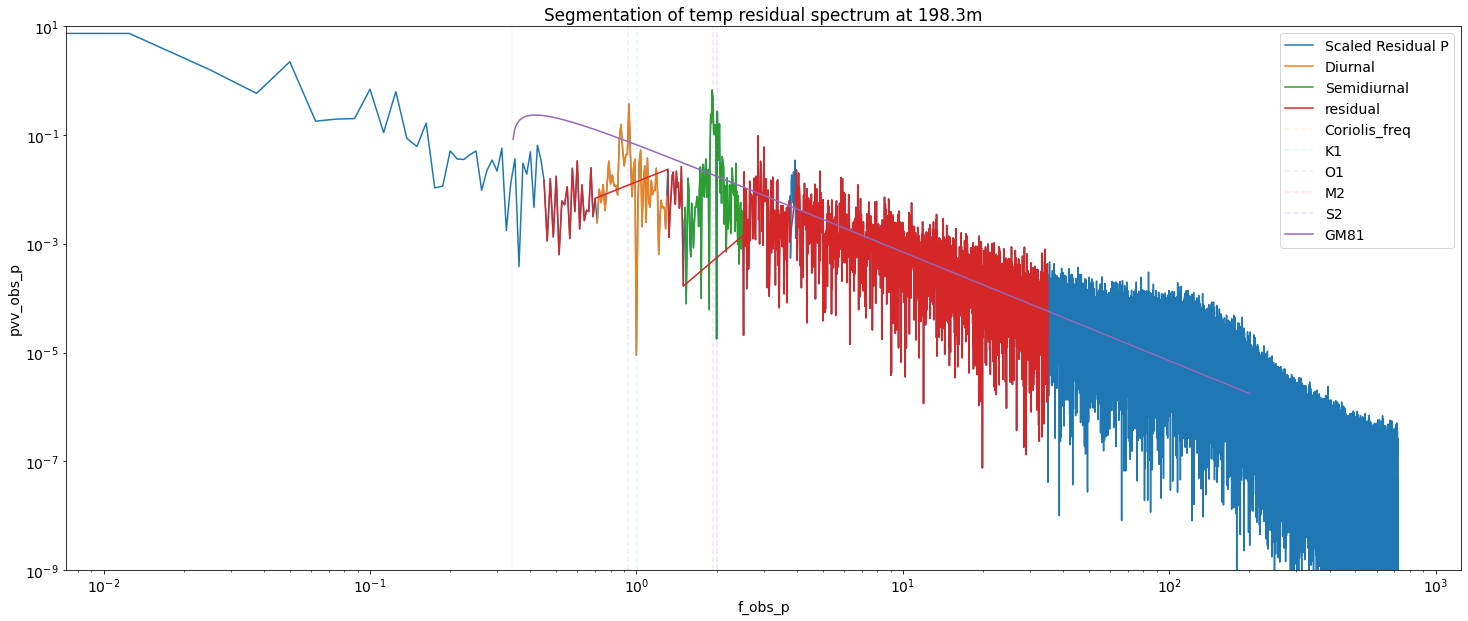

In [141]:
# total depth is ~400m
# interest_depth = 110.7
idx = Depths_P1.index(interest_depth)

plt.plot(F_p_P1[idx][0],P_p_P1[idx][0],label='Scaled Residual P')
# plt.plot(F_p_P1_modulated[idx][0],P_p_P1_modulated[idx][0],label='Processed & scaled Residual P')
plt.plot(F_p_P1_L1_peak[idx][0],P_p_P1_L1_peak[idx][0],label='Diurnal')
plt.plot(F_p_P1_L2_peak[idx][0],P_p_P1_L2_peak[idx][0],label='Semidiurnal')
plt.plot(F_p_P1_residual[idx][0],P_p_P1_residual[idx][0],label='residual')


for j in range(len(xcoords)):
    plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j],alpha=0.105)

# plt.plot(F_residual_w[idx],P_residual_w_raw[idx],label='Raw Obs Residual W')
# plt.plot(F_residual_w[idx],P_residual_w[idx],'-.',label='Scaled Residual W')
# plt.plot(F_residual_w_Modulated[idx],P_residual_w_Modulated[idx],'-.',label='Processed & scaled Residual W')
plt.plot(omg*86400,GM_spectrum/86400,label = 'GM81')
plt.legend()
plt.ylim(1e-9, 1e1)
# plt.xlim(0, 5)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Segmentation of temp residual spectrum at {}m'.format(interest_depth))

In [142]:
#whittle_total per points
whittle_total_M1L1_P1        = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1,                Soln_model_fit_list_P1_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P1      = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_diurnal_peak,   Soln_model_fit_list_P1_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P1  = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_semidiurnal_peak,Soln_model_fit_list_P1_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P1     = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_residual,        Soln_model_fit_list_P1_M1L1,M1L1_no_noise)

whittle_total_M1L2_P1        = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1,                 Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P1      = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_diurnal_peak,    Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P1  = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_semidiurnal_peak,Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P1     = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_residual,        Soln_model_fit_list_P1_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [143]:
#whittle_total per points
whittle_total_M1L1_P2        = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2,                Soln_model_fit_list_P2_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P2      = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_diurnal_peak,   Soln_model_fit_list_P2_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P2  = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_semidiurnal_peak,Soln_model_fit_list_P2_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P2     = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_residual,        Soln_model_fit_list_P2_M1L1,M1L1_no_noise)

whittle_total_M1L2_P2         = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2,                 Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P2      = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_diurnal_peak,    Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P2  = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_semidiurnal_peak,Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P2     = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_residual,        Soln_model_fit_list_P2_M1L2,M1L2_no_noise)

In [144]:
#whittle_total per points
whittle_total_M1L1_P3        = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3,                Soln_model_fit_list_P3_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P3      = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_diurnal_peak,   Soln_model_fit_list_P3_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P3  = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_semidiurnal_peak,Soln_model_fit_list_P3_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P3     = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_residual,        Soln_model_fit_list_P3_M1L1,M1L1_no_noise)

whittle_total_M1L2_P3        = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3,                 Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P3      = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_diurnal_peak,    Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P3  = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_semidiurnal_peak,Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P3     = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_residual,        Soln_model_fit_list_P3_M1L2,M1L2_no_noise)

In [145]:
#whittle_total per points
whittle_total_M1L1_P4        = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4,                Soln_model_fit_list_P4_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P4      = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_diurnal_peak,   Soln_model_fit_list_P4_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P4  = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_semidiurnal_peak,Soln_model_fit_list_P4_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P4     = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_residual,        Soln_model_fit_list_P4_M1L1,M1L1_no_noise)

whittle_total_M1L2_P4         = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4,                 Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P4      = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_diurnal_peak,    Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P4  = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_semidiurnal_peak,Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P4     = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_residual,        Soln_model_fit_list_P4_M1L2,M1L2_no_noise)

In [146]:
#whittle_total per points
whittle_total_M1L1_P5        = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5,                Soln_model_fit_list_P5_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P5      = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_diurnal_peak,   Soln_model_fit_list_P5_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P5  = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_semidiurnal_peak,Soln_model_fit_list_P5_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P5     = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_residual,        Soln_model_fit_list_P5_M1L1,M1L1_no_noise)

whittle_total_M1L2_P5         = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5,                 Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P5      = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_diurnal_peak,    Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P5  = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_semidiurnal_peak,Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P5     = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_residual,        Soln_model_fit_list_P5_M1L2,M1L2_no_noise)

In [147]:
#whittle_total per points
whittle_total_M1L1_P6        = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6,                Soln_model_fit_list_P6_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P6      = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6_diurnal_peak,   Soln_model_fit_list_P6_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P6  = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6_semidiurnal_peak,Soln_model_fit_list_P6_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P6     = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6_residual,        Soln_model_fit_list_P6_M1L1,M1L1_no_noise)

whittle_total_M1L2_P6         = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6,                 Soln_model_fit_list_P6_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P6      = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6_diurnal_peak,    Soln_model_fit_list_P6_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P6  = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6_semidiurnal_peak,Soln_model_fit_list_P6_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P6     = Optimisation.Cal_whittle_value_per_points(P_p_P6,Time_P6_Window,subset_p_P6_residual,        Soln_model_fit_list_P6_M1L2,M1L2_no_noise)

In [148]:
#whittle_total per points
whittle_total_M1L1_P7        = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7,                Soln_model_fit_list_P7_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P7      = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7_diurnal_peak,   Soln_model_fit_list_P7_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P7  = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7_semidiurnal_peak,Soln_model_fit_list_P7_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P7     = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7_residual,        Soln_model_fit_list_P7_M1L1,M1L1_no_noise)

whittle_total_M1L2_P7         = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7,                 Soln_model_fit_list_P7_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P7      = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7_diurnal_peak,    Soln_model_fit_list_P7_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P7  = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7_semidiurnal_peak,Soln_model_fit_list_P7_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P7     = Optimisation.Cal_whittle_value_per_points(P_p_P7,Time_P7_Window,subset_p_P7_residual,        Soln_model_fit_list_P7_M1L2,M1L2_no_noise)

In [149]:
#whittle_total per points
whittle_total_M1L1_P8        = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8,                Soln_model_fit_list_P8_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P8      = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8_diurnal_peak,   Soln_model_fit_list_P8_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P8  = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8_semidiurnal_peak,Soln_model_fit_list_P8_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P8     = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8_residual,        Soln_model_fit_list_P8_M1L1,M1L1_no_noise)

whittle_total_M1L2_P8         = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8,                 Soln_model_fit_list_P8_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P8      = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8_diurnal_peak,    Soln_model_fit_list_P8_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P8  = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8_semidiurnal_peak,Soln_model_fit_list_P8_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P8     = Optimisation.Cal_whittle_value_per_points(P_p_P8,Time_P8_Window,subset_p_P8_residual,        Soln_model_fit_list_P8_M1L2,M1L2_no_noise)

In [150]:
#whittle_total per points
whittle_total_M1L1_P9        = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9,                Soln_model_fit_list_P9_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P9      = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9_diurnal_peak,   Soln_model_fit_list_P9_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P9  = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9_semidiurnal_peak,Soln_model_fit_list_P9_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P9     = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9_residual,        Soln_model_fit_list_P9_M1L1,M1L1_no_noise)

whittle_total_M1L2_P9         = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9,                 Soln_model_fit_list_P9_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P9      = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9_diurnal_peak,    Soln_model_fit_list_P9_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P9  = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9_semidiurnal_peak,Soln_model_fit_list_P9_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P9     = Optimisation.Cal_whittle_value_per_points(P_p_P9,Time_P9_Window,subset_p_P9_residual,        Soln_model_fit_list_P9_M1L2,M1L2_no_noise)

In [151]:
#whittle_total per points
whittle_total_M1L1_P10        = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10,                Soln_model_fit_list_P10_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P10      = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10_diurnal_peak,   Soln_model_fit_list_P10_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P10  = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10_semidiurnal_peak,Soln_model_fit_list_P10_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P10     = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10_residual,        Soln_model_fit_list_P10_M1L1,M1L1_no_noise)

whittle_total_M1L2_P10         = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10,                 Soln_model_fit_list_P10_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P10      = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10_diurnal_peak,    Soln_model_fit_list_P10_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P10  = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10_semidiurnal_peak,Soln_model_fit_list_P10_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P10     = Optimisation.Cal_whittle_value_per_points(P_p_P10,Time_P10_Window,subset_p_P10_residual,        Soln_model_fit_list_P10_M1L2,M1L2_no_noise)

In [152]:
#whittle_total per points
whittle_total_M1L1_P11        = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11,                Soln_model_fit_list_P11_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P11      = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11_diurnal_peak,   Soln_model_fit_list_P11_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P11  = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11_semidiurnal_peak,Soln_model_fit_list_P11_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P11     = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11_residual,        Soln_model_fit_list_P11_M1L1,M1L1_no_noise)

whittle_total_M1L2_P11         = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11,                 Soln_model_fit_list_P11_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P11      = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11_diurnal_peak,    Soln_model_fit_list_P11_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P11  = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11_semidiurnal_peak,Soln_model_fit_list_P11_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P11     = Optimisation.Cal_whittle_value_per_points(P_p_P11,Time_P11_Window,subset_p_P11_residual,        Soln_model_fit_list_P11_M1L2,M1L2_no_noise)

In [153]:
#whittle_total per points
whittle_total_M1L1_P12        = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12,                Soln_model_fit_list_P12_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P12      = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12_diurnal_peak,   Soln_model_fit_list_P12_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P12  = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12_semidiurnal_peak,Soln_model_fit_list_P12_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P12     = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12_residual,        Soln_model_fit_list_P12_M1L1,M1L1_no_noise)

whittle_total_M1L2_P12         = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12,                 Soln_model_fit_list_P12_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P12      = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12_diurnal_peak,    Soln_model_fit_list_P12_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P12  = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12_semidiurnal_peak,Soln_model_fit_list_P12_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P12     = Optimisation.Cal_whittle_value_per_points(P_p_P12,Time_P12_Window,subset_p_P12_residual,        Soln_model_fit_list_P12_M1L2,M1L2_no_noise)

In [154]:
#whittle_total per points
whittle_total_M1L1_P13        = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13,                Soln_model_fit_list_P13_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P13      = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13_diurnal_peak,   Soln_model_fit_list_P13_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P13  = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13_semidiurnal_peak,Soln_model_fit_list_P13_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P13     = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13_residual,        Soln_model_fit_list_P13_M1L1,M1L1_no_noise)

whittle_total_M1L2_P13         = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13,                 Soln_model_fit_list_P13_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P13      = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13_diurnal_peak,    Soln_model_fit_list_P13_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P13  = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13_semidiurnal_peak,Soln_model_fit_list_P13_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P13     = Optimisation.Cal_whittle_value_per_points(P_p_P13,Time_P13_Window,subset_p_P13_residual,        Soln_model_fit_list_P13_M1L2,M1L2_no_noise)

In [155]:
#whittle_total per points
whittle_total_M1L1_P14        = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14,                Soln_model_fit_list_P14_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P14      = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14_diurnal_peak,   Soln_model_fit_list_P14_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P14  = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14_semidiurnal_peak,Soln_model_fit_list_P14_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P14     = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14_residual,        Soln_model_fit_list_P14_M1L1,M1L1_no_noise)

whittle_total_M1L2_P14         = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14,                 Soln_model_fit_list_P14_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P14      = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14_diurnal_peak,    Soln_model_fit_list_P14_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P14  = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14_semidiurnal_peak,Soln_model_fit_list_P14_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P14     = Optimisation.Cal_whittle_value_per_points(P_p_P14,Time_P14_Window,subset_p_P14_residual,        Soln_model_fit_list_P14_M1L2,M1L2_no_noise)

In [156]:
#whittle_total per points
whittle_total_M1L1_P15        = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15,                Soln_model_fit_list_P15_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P15      = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15_diurnal_peak,   Soln_model_fit_list_P15_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P15  = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15_semidiurnal_peak,Soln_model_fit_list_P15_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P15     = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15_residual,        Soln_model_fit_list_P15_M1L1,M1L1_no_noise)

whittle_total_M1L2_P15         = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15,                 Soln_model_fit_list_P15_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P15      = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15_diurnal_peak,    Soln_model_fit_list_P15_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P15  = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15_semidiurnal_peak,Soln_model_fit_list_P15_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P15     = Optimisation.Cal_whittle_value_per_points(P_p_P15,Time_P15_Window,subset_p_P15_residual,        Soln_model_fit_list_P15_M1L2,M1L2_no_noise)

In [157]:
#whittle_total per points
whittle_total_M1L1_P16        = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16,                Soln_model_fit_list_P16_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P16      = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16_diurnal_peak,   Soln_model_fit_list_P16_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P16  = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16_semidiurnal_peak,Soln_model_fit_list_P16_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P16     = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16_residual,        Soln_model_fit_list_P16_M1L1,M1L1_no_noise)

whittle_total_M1L2_P16         = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16,                 Soln_model_fit_list_P16_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P16      = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16_diurnal_peak,    Soln_model_fit_list_P16_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P16  = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16_semidiurnal_peak,Soln_model_fit_list_P16_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P16     = Optimisation.Cal_whittle_value_per_points(P_p_P16,Time_P16_Window,subset_p_P16_residual,        Soln_model_fit_list_P16_M1L2,M1L2_no_noise)

In [158]:
#whittle_total per points
whittle_total_M1L1_P17        = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17,                Soln_model_fit_list_P17_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P17      = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17_diurnal_peak,   Soln_model_fit_list_P17_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P17  = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17_semidiurnal_peak,Soln_model_fit_list_P17_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P17     = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17_residual,        Soln_model_fit_list_P17_M1L1,M1L1_no_noise)

whittle_total_M1L2_P17         = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17,                 Soln_model_fit_list_P17_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P17      = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17_diurnal_peak,    Soln_model_fit_list_P17_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P17  = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17_semidiurnal_peak,Soln_model_fit_list_P17_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P17     = Optimisation.Cal_whittle_value_per_points(P_p_P17,Time_P17_Window,subset_p_P17_residual,        Soln_model_fit_list_P17_M1L2,M1L2_no_noise)

## Construct a PD DataFrame that contain all the results

In [159]:
#M1L1
whittle_total_M1L1_df_P1        = Processing.Transfer_list_to_df(whittle_total_M1L1_P1,       Depths_P1,'whittle_total')
whittle_diurnal_M1L1_df_P1      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P1,     Depths_P1,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P1  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P1, Depths_P1,'whittle_semidiurnal')
whittle_residual_M1L1_df_P1     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P1,    Depths_P1,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P1 = pd.concat([whittle_total_M1L1_df_P1, 
                                whittle_diurnal_M1L1_df_P1, 
                                whittle_semidiurnal_M1L1_df_P1, 
                                whittle_residual_M1L1_df_P1 ], axis=1)

#M1L2
whittle_total_M1L2_df_P1        = Processing.Transfer_list_to_df(whittle_total_M1L2_P1,       Depths_P1,'whittle_total')
whittle_diurnal_M1L2_df_P1      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P1,     Depths_P1,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P1  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P1, Depths_P1,'whittle_semidiurnal')
whittle_residual_M1L2_df_P1     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P1,    Depths_P1,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P1 = pd.concat([whittle_total_M1L2_df_P1, 
                                whittle_diurnal_M1L2_df_P1, 
                                whittle_semidiurnal_M1L2_df_P1,
                                whittle_residual_M1L2_df_P1 ], axis=1)
whittle_df_M1L2_P1

whittle_total  whittle_diurnal  whittle_semidiurnal  whittle_residual
128.3       5.596297         1.417174             1.971922          5.783458
178.3       6.663727         2.686761             2.950561          6.849895
198.3       6.695488         2.796068             3.070341          6.877550
461.8       8.836490         3.202613             4.223945          9.080454
298.3       7.137533         3.306272             3.740965          7.311370
398.3       8.021116         3.390168             4.171147          8.223436
21.8        9.927105         3.083304             5.662589         10.182604
128.3       6.038955         1.902116             2.477746          6.223413
178.3       6.469771         2.103517             2.863169          6.659816
198.3       6.597027         2.424951             3.071313          6.781047
461.8       8.772519         3.201153             4.013786          9.019800
298.3       7.073766         2.889536             3.796399          7.250429
398.3       8.192679         3.156074             4.341391          8.402470
21.8        7.559690         2.816028             3.751151          7.762810

In [160]:
#M1L1
whittle_total_M1L1_df_P2        = Processing.Transfer_list_to_df(whittle_total_M1L1_P2,       Depths_P2,'whittle_total')
whittle_diurnal_M1L1_df_P2      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P2,     Depths_P2,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P2  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P2, Depths_P2,'whittle_semidiurnal')
whittle_residual_M1L1_df_P2     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P2,    Depths_P2,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P2 = pd.concat([whittle_total_M1L1_df_P2, 
                                whittle_diurnal_M1L1_df_P2, 
                                whittle_semidiurnal_M1L1_df_P2, 
                                whittle_residual_M1L1_df_P2 ], axis=1)

#M1L2
whittle_total_M1L2_df_P2        = Processing.Transfer_list_to_df(whittle_total_M1L2_P2,       Depths_P2,'whittle_total')
whittle_diurnal_M1L2_df_P2      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P2,     Depths_P2,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P2  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P2, Depths_P2,'whittle_semidiurnal')
whittle_residual_M1L2_df_P2     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P2,    Depths_P2,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P2 = pd.concat([whittle_total_M1L2_df_P2, 
                                whittle_diurnal_M1L2_df_P2, 
                                whittle_semidiurnal_M1L2_df_P2,
                                whittle_residual_M1L2_df_P2 ], axis=1)

In [161]:
#M1L1
whittle_total_M1L1_df_P3        = Processing.Transfer_list_to_df(whittle_total_M1L1_P3,       Depths_P3,'whittle_total')
whittle_diurnal_M1L1_df_P3      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P3,     Depths_P3,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P3  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P3, Depths_P3,'whittle_semidiurnal')
whittle_residual_M1L1_df_P3     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P3,    Depths_P3,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P3 = pd.concat([whittle_total_M1L1_df_P3, 
                                whittle_diurnal_M1L1_df_P3, 
                                whittle_semidiurnal_M1L1_df_P3, 
                                whittle_residual_M1L1_df_P3 ], axis=1)

#M1L2
whittle_total_M1L2_df_P3        = Processing.Transfer_list_to_df(whittle_total_M1L2_P3,       Depths_P3,'whittle_total')
whittle_diurnal_M1L2_df_P3      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P3,     Depths_P3,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P3  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P3, Depths_P3,'whittle_semidiurnal')
whittle_residual_M1L2_df_P3     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P3,    Depths_P3,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P3 = pd.concat([whittle_total_M1L2_df_P3, 
                                whittle_diurnal_M1L2_df_P3, 
                                whittle_semidiurnal_M1L2_df_P3,
                                whittle_residual_M1L2_df_P3 ], axis=1)

In [162]:
#M1L1
whittle_total_M1L1_df_P4        = Processing.Transfer_list_to_df(whittle_total_M1L1_P4,       Depths_P4,'whittle_total')
whittle_diurnal_M1L1_df_P4      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P4,     Depths_P4,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P4  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P4, Depths_P4,'whittle_semidiurnal')
whittle_residual_M1L1_df_P4     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P4,    Depths_P4,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P4 = pd.concat([whittle_total_M1L1_df_P4, 
                                whittle_diurnal_M1L1_df_P4, 
                                whittle_semidiurnal_M1L1_df_P4, 
                                whittle_residual_M1L1_df_P4 ], axis=1)

#M1L2
whittle_total_M1L2_df_P4        = Processing.Transfer_list_to_df(whittle_total_M1L2_P4,       Depths_P4,'whittle_total')
whittle_diurnal_M1L2_df_P4      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P4,     Depths_P4,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P4  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P4, Depths_P4,'whittle_semidiurnal')
whittle_residual_M1L2_df_P4     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P4,    Depths_P4,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P4 = pd.concat([whittle_total_M1L2_df_P4, 
                                whittle_diurnal_M1L2_df_P4, 
                                whittle_semidiurnal_M1L2_df_P4,
                                whittle_residual_M1L2_df_P4 ], axis=1)

In [163]:
#M1L1
whittle_total_M1L1_df_P5        = Processing.Transfer_list_to_df(whittle_total_M1L1_P5,       Depths_P5,'whittle_total')
whittle_diurnal_M1L1_df_P5      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P5,     Depths_P5,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P5  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P5, Depths_P5,'whittle_semidiurnal')
whittle_residual_M1L1_df_P5     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P5,    Depths_P5,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P5 = pd.concat([whittle_total_M1L1_df_P5, 
                                whittle_diurnal_M1L1_df_P5, 
                                whittle_semidiurnal_M1L1_df_P5, 
                                whittle_residual_M1L1_df_P5 ], axis=1)

#M1L2
whittle_total_M1L2_df_P5        = Processing.Transfer_list_to_df(whittle_total_M1L2_P5,       Depths_P5,'whittle_total')
whittle_diurnal_M1L2_df_P5      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P5,     Depths_P5,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P5  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P5, Depths_P5,'whittle_semidiurnal')
whittle_residual_M1L2_df_P5     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P5,    Depths_P5,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P5 = pd.concat([whittle_total_M1L2_df_P5, 
                                whittle_diurnal_M1L2_df_P5, 
                                whittle_semidiurnal_M1L2_df_P5,
                                whittle_residual_M1L2_df_P5 ], axis=1)

In [164]:
#M1L1
whittle_total_M1L1_df_P6        = Processing.Transfer_list_to_df(whittle_total_M1L1_P6,       Depths_P6,'whittle_total')
whittle_diurnal_M1L1_df_P6      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P6,     Depths_P6,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P6  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P6, Depths_P6,'whittle_semidiurnal')
whittle_residual_M1L1_df_P6     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P6,    Depths_P6,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P6 = pd.concat([whittle_total_M1L1_df_P6, 
                                whittle_diurnal_M1L1_df_P6, 
                                whittle_semidiurnal_M1L1_df_P6, 
                                whittle_residual_M1L1_df_P6 ], axis=1)

#M1L2
whittle_total_M1L2_df_P6        = Processing.Transfer_list_to_df(whittle_total_M1L2_P6,       Depths_P6,'whittle_total')
whittle_diurnal_M1L2_df_P6      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P6,     Depths_P6,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P6  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P6, Depths_P6,'whittle_semidiurnal')
whittle_residual_M1L2_df_P6     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P6,    Depths_P6,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P6 = pd.concat([whittle_total_M1L2_df_P6, 
                                whittle_diurnal_M1L2_df_P6, 
                                whittle_semidiurnal_M1L2_df_P6,
                                whittle_residual_M1L2_df_P6 ], axis=1)

In [165]:
#M1L1
whittle_total_M1L1_df_P7        = Processing.Transfer_list_to_df(whittle_total_M1L1_P7,       Depths_P7,'whittle_total')
whittle_diurnal_M1L1_df_P7      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P7,     Depths_P7,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P7  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P7, Depths_P7,'whittle_semidiurnal')
whittle_residual_M1L1_df_P7     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P7,    Depths_P7,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P7 = pd.concat([whittle_total_M1L1_df_P7, 
                                whittle_diurnal_M1L1_df_P7, 
                                whittle_semidiurnal_M1L1_df_P7, 
                                whittle_residual_M1L1_df_P7 ], axis=1)

#M1L2
whittle_total_M1L2_df_P7        = Processing.Transfer_list_to_df(whittle_total_M1L2_P7,       Depths_P7,'whittle_total')
whittle_diurnal_M1L2_df_P7      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P7,     Depths_P7,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P7  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P7, Depths_P7,'whittle_semidiurnal')
whittle_residual_M1L2_df_P7     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P7,    Depths_P7,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P7 = pd.concat([whittle_total_M1L2_df_P7, 
                                whittle_diurnal_M1L2_df_P7, 
                                whittle_semidiurnal_M1L2_df_P7,
                                whittle_residual_M1L2_df_P7 ], axis=1)

In [166]:
#M1L1
whittle_total_M1L1_df_P8        = Processing.Transfer_list_to_df(whittle_total_M1L1_P8,       Depths_P8,'whittle_total')
whittle_diurnal_M1L1_df_P8      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P8,     Depths_P8,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P8  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P8, Depths_P8,'whittle_semidiurnal')
whittle_residual_M1L1_df_P8     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P8,    Depths_P8,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P8 = pd.concat([whittle_total_M1L1_df_P8, 
                                whittle_diurnal_M1L1_df_P8, 
                                whittle_semidiurnal_M1L1_df_P8, 
                                whittle_residual_M1L1_df_P8 ], axis=1)

#M1L2
whittle_total_M1L2_df_P8        = Processing.Transfer_list_to_df(whittle_total_M1L2_P8,       Depths_P8,'whittle_total')
whittle_diurnal_M1L2_df_P8      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P8,     Depths_P8,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P8  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P8, Depths_P8,'whittle_semidiurnal')
whittle_residual_M1L2_df_P8     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P8,    Depths_P8,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P8 = pd.concat([whittle_total_M1L2_df_P8, 
                                whittle_diurnal_M1L2_df_P8, 
                                whittle_semidiurnal_M1L2_df_P8,
                                whittle_residual_M1L2_df_P8 ], axis=1)

In [167]:
#M1L1
whittle_total_M1L1_df_P9        = Processing.Transfer_list_to_df(whittle_total_M1L1_P9,       Depths_P9,'whittle_total')
whittle_diurnal_M1L1_df_P9      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P9,     Depths_P9,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P9  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P9, Depths_P9,'whittle_semidiurnal')
whittle_residual_M1L1_df_P9     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P9,    Depths_P9,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P9 = pd.concat([whittle_total_M1L1_df_P9, 
                                whittle_diurnal_M1L1_df_P9, 
                                whittle_semidiurnal_M1L1_df_P9, 
                                whittle_residual_M1L1_df_P9 ], axis=1)

#M1L2
whittle_total_M1L2_df_P9        = Processing.Transfer_list_to_df(whittle_total_M1L2_P9,       Depths_P9,'whittle_total')
whittle_diurnal_M1L2_df_P9      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P9,     Depths_P9,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P9  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P9, Depths_P9,'whittle_semidiurnal')
whittle_residual_M1L2_df_P9     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P9,    Depths_P9,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P9 = pd.concat([whittle_total_M1L2_df_P9, 
                                whittle_diurnal_M1L2_df_P9, 
                                whittle_semidiurnal_M1L2_df_P9,
                                whittle_residual_M1L2_df_P9 ], axis=1)

In [168]:
#M1L1
whittle_total_M1L1_df_P10        = Processing.Transfer_list_to_df(whittle_total_M1L1_P10,       Depths_P10,'whittle_total')
whittle_diurnal_M1L1_df_P10      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P10,     Depths_P10,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P10  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P10, Depths_P10,'whittle_semidiurnal')
whittle_residual_M1L1_df_P10     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P10,    Depths_P10,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P10 = pd.concat([whittle_total_M1L1_df_P10, 
                                whittle_diurnal_M1L1_df_P10, 
                                whittle_semidiurnal_M1L1_df_P10, 
                                whittle_residual_M1L1_df_P10 ], axis=1)

#M1L2
whittle_total_M1L2_df_P10        = Processing.Transfer_list_to_df(whittle_total_M1L2_P10,       Depths_P10,'whittle_total')
whittle_diurnal_M1L2_df_P10      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P10,     Depths_P10,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P10  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P10, Depths_P10,'whittle_semidiurnal')
whittle_residual_M1L2_df_P10     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P10,    Depths_P10,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P10 = pd.concat([whittle_total_M1L2_df_P10, 
                                whittle_diurnal_M1L2_df_P10, 
                                whittle_semidiurnal_M1L2_df_P10,
                                whittle_residual_M1L2_df_P10 ], axis=1)

In [169]:
#M1L1
whittle_total_M1L1_df_P11        = Processing.Transfer_list_to_df(whittle_total_M1L1_P11,       Depths_P11,'whittle_total')
whittle_diurnal_M1L1_df_P11      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P11,     Depths_P11,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P11  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P11, Depths_P11,'whittle_semidiurnal')
whittle_residual_M1L1_df_P11     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P11,    Depths_P11,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P11 = pd.concat([whittle_total_M1L1_df_P11, 
                                whittle_diurnal_M1L1_df_P11, 
                                whittle_semidiurnal_M1L1_df_P11, 
                                whittle_residual_M1L1_df_P11 ], axis=1)

#M1L2
whittle_total_M1L2_df_P11        = Processing.Transfer_list_to_df(whittle_total_M1L2_P11,       Depths_P11,'whittle_total')
whittle_diurnal_M1L2_df_P11      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P11,     Depths_P11,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P11  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P11, Depths_P11,'whittle_semidiurnal')
whittle_residual_M1L2_df_P11     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P11,    Depths_P11,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P11 = pd.concat([whittle_total_M1L2_df_P11, 
                                whittle_diurnal_M1L2_df_P11, 
                                whittle_semidiurnal_M1L2_df_P11,
                                whittle_residual_M1L2_df_P11 ], axis=1)

In [170]:
#M1L1
whittle_total_M1L1_df_P12        = Processing.Transfer_list_to_df(whittle_total_M1L1_P12,       Depths_P12,'whittle_total')
whittle_diurnal_M1L1_df_P12      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P12,     Depths_P12,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P12  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P12, Depths_P12,'whittle_semidiurnal')
whittle_residual_M1L1_df_P12     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P12,    Depths_P12,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P12 = pd.concat([whittle_total_M1L1_df_P12, 
                                whittle_diurnal_M1L1_df_P12, 
                                whittle_semidiurnal_M1L1_df_P12, 
                                whittle_residual_M1L1_df_P12 ], axis=1)

#M1L2
whittle_total_M1L2_df_P12        = Processing.Transfer_list_to_df(whittle_total_M1L2_P12,       Depths_P12,'whittle_total')
whittle_diurnal_M1L2_df_P12      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P12,     Depths_P12,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P12  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P12, Depths_P12,'whittle_semidiurnal')
whittle_residual_M1L2_df_P12     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P12,    Depths_P12,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P12 = pd.concat([whittle_total_M1L2_df_P12, 
                                whittle_diurnal_M1L2_df_P12, 
                                whittle_semidiurnal_M1L2_df_P12,
                                whittle_residual_M1L2_df_P12 ], axis=1)

In [171]:
#M1L1
whittle_total_M1L1_df_P13        = Processing.Transfer_list_to_df(whittle_total_M1L1_P13,       Depths_P13,'whittle_total')
whittle_diurnal_M1L1_df_P13      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P13,     Depths_P13,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P13  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P13, Depths_P13,'whittle_semidiurnal')
whittle_residual_M1L1_df_P13     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P13,    Depths_P13,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P13 = pd.concat([whittle_total_M1L1_df_P13, 
                                whittle_diurnal_M1L1_df_P13, 
                                whittle_semidiurnal_M1L1_df_P13, 
                                whittle_residual_M1L1_df_P13 ], axis=1)

#M1L2
whittle_total_M1L2_df_P13        = Processing.Transfer_list_to_df(whittle_total_M1L2_P13,       Depths_P13,'whittle_total')
whittle_diurnal_M1L2_df_P13      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P13,     Depths_P13,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P13  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P13, Depths_P13,'whittle_semidiurnal')
whittle_residual_M1L2_df_P13     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P13,    Depths_P13,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P13 = pd.concat([whittle_total_M1L2_df_P13, 
                                whittle_diurnal_M1L2_df_P13, 
                                whittle_semidiurnal_M1L2_df_P13,
                                whittle_residual_M1L2_df_P13 ], axis=1)

In [172]:
#M1L1
whittle_total_M1L1_df_P14        = Processing.Transfer_list_to_df(whittle_total_M1L1_P14,       Depths_P14,'whittle_total')
whittle_diurnal_M1L1_df_P14      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P14,     Depths_P14,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P14  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P14, Depths_P14,'whittle_semidiurnal')
whittle_residual_M1L1_df_P14     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P14,    Depths_P14,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P14 = pd.concat([whittle_total_M1L1_df_P14, 
                                whittle_diurnal_M1L1_df_P14, 
                                whittle_semidiurnal_M1L1_df_P14, 
                                whittle_residual_M1L1_df_P14 ], axis=1)

#M1L2
whittle_total_M1L2_df_P14        = Processing.Transfer_list_to_df(whittle_total_M1L2_P14,       Depths_P14,'whittle_total')
whittle_diurnal_M1L2_df_P14      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P14,     Depths_P14,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P14  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P14, Depths_P14,'whittle_semidiurnal')
whittle_residual_M1L2_df_P14     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P14,    Depths_P14,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P14 = pd.concat([whittle_total_M1L2_df_P14, 
                                whittle_diurnal_M1L2_df_P14, 
                                whittle_semidiurnal_M1L2_df_P14,
                                whittle_residual_M1L2_df_P14 ], axis=1)

In [173]:
#M1L1
whittle_total_M1L1_df_P15        = Processing.Transfer_list_to_df(whittle_total_M1L1_P15,       Depths_P15,'whittle_total')
whittle_diurnal_M1L1_df_P15      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P15,     Depths_P15,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P15  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P15, Depths_P15,'whittle_semidiurnal')
whittle_residual_M1L1_df_P15     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P15,    Depths_P15,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P15 = pd.concat([whittle_total_M1L1_df_P15, 
                                whittle_diurnal_M1L1_df_P15, 
                                whittle_semidiurnal_M1L1_df_P15, 
                                whittle_residual_M1L1_df_P15 ], axis=1)

#M1L2
whittle_total_M1L2_df_P15        = Processing.Transfer_list_to_df(whittle_total_M1L2_P15,       Depths_P15,'whittle_total')
whittle_diurnal_M1L2_df_P15      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P15,     Depths_P15,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P15  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P15, Depths_P15,'whittle_semidiurnal')
whittle_residual_M1L2_df_P15     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P15,    Depths_P15,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P15 = pd.concat([whittle_total_M1L2_df_P15, 
                                whittle_diurnal_M1L2_df_P15, 
                                whittle_semidiurnal_M1L2_df_P15,
                                whittle_residual_M1L2_df_P15 ], axis=1)

In [174]:
#M1L1
whittle_total_M1L1_df_P16        = Processing.Transfer_list_to_df(whittle_total_M1L1_P16,       Depths_P16,'whittle_total')
whittle_diurnal_M1L1_df_P16      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P16,     Depths_P16,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P16  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P16, Depths_P16,'whittle_semidiurnal')
whittle_residual_M1L1_df_P16     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P16,    Depths_P16,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P16 = pd.concat([whittle_total_M1L1_df_P16, 
                                whittle_diurnal_M1L1_df_P16, 
                                whittle_semidiurnal_M1L1_df_P16, 
                                whittle_residual_M1L1_df_P16 ], axis=1)

#M1L2
whittle_total_M1L2_df_P16        = Processing.Transfer_list_to_df(whittle_total_M1L2_P16,       Depths_P16,'whittle_total')
whittle_diurnal_M1L2_df_P16      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P16,     Depths_P16,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P16  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P16, Depths_P16,'whittle_semidiurnal')
whittle_residual_M1L2_df_P16     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P16,    Depths_P16,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P16 = pd.concat([whittle_total_M1L2_df_P16, 
                                whittle_diurnal_M1L2_df_P16, 
                                whittle_semidiurnal_M1L2_df_P16,
                                whittle_residual_M1L2_df_P16 ], axis=1)

In [175]:
#M1L1
whittle_total_M1L1_df_P17        = Processing.Transfer_list_to_df(whittle_total_M1L1_P17,       Depths_P17,'whittle_total')
whittle_diurnal_M1L1_df_P17      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P17,     Depths_P17,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P17  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P17, Depths_P17,'whittle_semidiurnal')
whittle_residual_M1L1_df_P17     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P17,    Depths_P17,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P17 = pd.concat([whittle_total_M1L1_df_P17, 
                                whittle_diurnal_M1L1_df_P17, 
                                whittle_semidiurnal_M1L1_df_P17, 
                                whittle_residual_M1L1_df_P17 ], axis=1)

#M1L2
whittle_total_M1L2_df_P17        = Processing.Transfer_list_to_df(whittle_total_M1L2_P17,       Depths_P17,'whittle_total')
whittle_diurnal_M1L2_df_P17      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P17,     Depths_P17,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P17  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P17, Depths_P17,'whittle_semidiurnal')
whittle_residual_M1L2_df_P17     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P17,    Depths_P17,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P17 = pd.concat([whittle_total_M1L2_df_P17, 
                                whittle_diurnal_M1L2_df_P17, 
                                whittle_semidiurnal_M1L2_df_P17,
                                whittle_residual_M1L2_df_P17 ], axis=1)

In [176]:
whittle_df_final_M1L1 = pd.concat([whittle_df_M1L1_P1,
                                   whittle_df_M1L1_P2, 
                                   whittle_df_M1L1_P3,
                                   whittle_df_M1L1_P4,
                                   whittle_df_M1L1_P5,
                                   whittle_df_M1L1_P6,
                                   whittle_df_M1L1_P7, 
                                   whittle_df_M1L1_P8,
                                   whittle_df_M1L1_P9,
                                   whittle_df_M1L1_P10,
                                   whittle_df_M1L1_P11,
                                   whittle_df_M1L1_P12, 
                                   whittle_df_M1L1_P13,
                                   whittle_df_M1L1_P14,
                                   whittle_df_M1L1_P15,
                                   whittle_df_M1L1_P16,
                                   whittle_df_M1L1_P17,])

whittle_df_final_M1L2 = pd.concat([whittle_df_M1L2_P1,
                                   whittle_df_M1L2_P2, 
                                   whittle_df_M1L2_P3,
                                   whittle_df_M1L2_P4,
                                   whittle_df_M1L2_P5,
                                   whittle_df_M1L2_P6,
                                   whittle_df_M1L2_P7, 
                                   whittle_df_M1L2_P8,
                                   whittle_df_M1L2_P9,
                                   whittle_df_M1L2_P10,
                                   whittle_df_M1L2_P11,
                                   whittle_df_M1L2_P12, 
                                   whittle_df_M1L2_P13,
                                   whittle_df_M1L2_P14,
                                   whittle_df_M1L2_P15,
                                   whittle_df_M1L2_P16,
                                   whittle_df_M1L2_P17,])

In [177]:
#M1L1
Soln_model_fit_df_P1_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P1_M1L1,Depths_P1, 'solution')
Soln_model_fit_df_P2_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P2_M1L1,Depths_P2, 'solution')
Soln_model_fit_df_P3_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P3_M1L1,Depths_P3, 'solution')
Soln_model_fit_df_P4_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P4_M1L1,Depths_P4, 'solution')
Soln_model_fit_df_P5_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P5_M1L1,Depths_P5, 'solution')
Soln_model_fit_df_P6_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P6_M1L1,Depths_P6, 'solution')
Soln_model_fit_df_P7_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P7_M1L1,Depths_P7, 'solution')
Soln_model_fit_df_P8_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P8_M1L1,Depths_P8, 'solution')
Soln_model_fit_df_P9_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P9_M1L1,Depths_P9, 'solution')
Soln_model_fit_df_P10_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P10_M1L1,Depths_P10, 'solution')
Soln_model_fit_df_P11_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P11_M1L1,Depths_P11, 'solution')
Soln_model_fit_df_P12_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P12_M1L1,Depths_P12, 'solution')
Soln_model_fit_df_P13_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P13_M1L1,Depths_P13, 'solution')
Soln_model_fit_df_P14_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P14_M1L1,Depths_P14, 'solution')
Soln_model_fit_df_P15_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P15_M1L1,Depths_P15, 'solution')
Soln_model_fit_df_P16_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P16_M1L1,Depths_P16, 'solution')
Soln_model_fit_df_P17_M1L1   = Processing.Transfer_list_to_df(Soln_model_fit_list_P17_M1L1,Depths_P17, 'solution')


#Assemble all period
Soln_model_fit_df_final_M1L1 = pd.concat([Soln_model_fit_df_P1_M1L1,
                                          Soln_model_fit_df_P2_M1L1,
                                          Soln_model_fit_df_P3_M1L1,
                                          Soln_model_fit_df_P4_M1L1,
                                          Soln_model_fit_df_P5_M1L1,
                                          Soln_model_fit_df_P6_M1L1,
                                          Soln_model_fit_df_P7_M1L1,
                                          Soln_model_fit_df_P8_M1L1,
                                          Soln_model_fit_df_P9_M1L1,
                                          Soln_model_fit_df_P10_M1L1,
                                          Soln_model_fit_df_P11_M1L1,
                                          Soln_model_fit_df_P12_M1L1,
                                          Soln_model_fit_df_P13_M1L1,
                                          Soln_model_fit_df_P14_M1L1,
                                          Soln_model_fit_df_P15_M1L1,
                                          Soln_model_fit_df_P16_M1L1,
                                          Soln_model_fit_df_P17_M1L1,])

In [178]:
#M1L2
Soln_model_fit_df_P1_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P1_M1L2,Depths_P1, 'solution')
Soln_model_fit_df_P2_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P2_M1L2,Depths_P2, 'solution')
Soln_model_fit_df_P3_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P3_M1L2,Depths_P3, 'solution')
Soln_model_fit_df_P4_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P4_M1L2,Depths_P4, 'solution')
Soln_model_fit_df_P5_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P5_M1L2,Depths_P5, 'solution')
Soln_model_fit_df_P6_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P6_M1L2,Depths_P6, 'solution')
Soln_model_fit_df_P7_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P7_M1L2,Depths_P7, 'solution')
Soln_model_fit_df_P8_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P8_M1L2,Depths_P8, 'solution')
Soln_model_fit_df_P9_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P9_M1L2,Depths_P9, 'solution')
Soln_model_fit_df_P10_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P10_M1L2,Depths_P10, 'solution')
Soln_model_fit_df_P11_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P11_M1L2,Depths_P11, 'solution')
Soln_model_fit_df_P12_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P12_M1L2,Depths_P12, 'solution')
Soln_model_fit_df_P13_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P13_M1L2,Depths_P13, 'solution')
Soln_model_fit_df_P14_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P14_M1L2,Depths_P14, 'solution')
Soln_model_fit_df_P15_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P15_M1L2,Depths_P15, 'solution')
Soln_model_fit_df_P16_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P16_M1L2,Depths_P16, 'solution')
Soln_model_fit_df_P17_M1L2   = Processing.Transfer_list_to_df(Soln_model_fit_list_P17_M1L2,Depths_P17, 'solution')


#Assemble all period
Soln_model_fit_df_final_M1L2 = pd.concat([Soln_model_fit_df_P1_M1L2,
                                          Soln_model_fit_df_P2_M1L2,
                                          Soln_model_fit_df_P3_M1L2,
                                          Soln_model_fit_df_P4_M1L2,
                                          Soln_model_fit_df_P5_M1L2,
                                          Soln_model_fit_df_P6_M1L2,
                                          Soln_model_fit_df_P7_M1L2,
                                          Soln_model_fit_df_P8_M1L2,
                                          Soln_model_fit_df_P9_M1L2,
                                          Soln_model_fit_df_P10_M1L2,
                                          Soln_model_fit_df_P11_M1L2,
                                          Soln_model_fit_df_P12_M1L2,
                                          Soln_model_fit_df_P13_M1L2,
                                          Soln_model_fit_df_P14_M1L2,
                                          Soln_model_fit_df_P15_M1L2,
                                          Soln_model_fit_df_P16_M1L2,
                                          Soln_model_fit_df_P17_M1L2,])

In [179]:
#M1L1
final_df_M1L1 = Processing.Finalise_df(Soln_model_fit_df_final_M1L1, M1L1_parameter_name, whittle_df_final_M1L1, 
                                       'ITFTIS','M1L1',final_df)
#M1L2
final_df_M1L2 = Processing.Finalise_df(Soln_model_fit_df_final_M1L2, M1L2_parameter_name, whittle_df_final_M1L2, 
                                       'ITFTIS','M1L2',final_df)

final_df_combined = pd.concat([final_df_M1L2,final_df_M1L1])
final_df_combined.to_csv('ITFTIS Model fit parameters.csv', index=False)
final_df_combined

site  depth  start_date    end_date  year  mean_temp   season  \
0    ITFTIS  -21.8  2010-06-30  2010-09-18  2010  27.448549  Aug-Oct   
1    ITFTIS -128.3  2010-06-30  2010-09-18  2010  20.464117  Aug-Oct   
2    ITFTIS -178.3  2010-06-30  2010-09-18  2010  16.826827  Aug-Oct   
3    ITFTIS -198.3  2010-06-30  2010-09-18  2010  15.901794  Aug-Oct   
4    ITFTIS -298.3  2010-06-30  2010-09-18  2010  11.347148  Aug-Oct   
..      ...    ...         ...         ...   ...        ...      ...   
397  ITFTIS -176.5  2018-10-22  2019-01-10  2018  17.144615  Nov-Jan   
398  ITFTIS -296.5  2018-10-22  2019-01-10  2018  11.260655  Nov-Jan   
399  ITFTIS -346.5  2018-10-22  2019-01-10  2018  10.055115  Nov-Jan   
400  ITFTIS -396.5  2018-10-22  2019-01-10  2018   9.210274  Nov-Jan   
401  ITFTIS -457.3  2018-10-22  2019-01-10  2018   8.444574  Nov-Jan   

    model_type η_matern1 ν_matern1  ...   ℓ_peak1   η_peak2    ℓ_peak2  \
0         M1L2  0.001938       2.5  ...  0.583819  0.058475  11.651643   
1         M1L2  0.620103   0.88915  ...   6.03371  0.368984   4.414146   
2         M1L2  0.383891  0.926441  ...  4.227495   0.25579   6.365206   
3         M1L2  0.372556  0.915643  ...  4.682833  0.259151   7.911826   
4         M1L2  0.301386  0.916974  ...  9.903929  0.129576   7.591804   
..         ...       ...       ...  ...       ...       ...        ...   
397       M1L1  0.398784       NaN  ...       NaN       NaN        NaN   
398       M1L1   0.26362       NaN  ...       NaN       NaN        NaN   
399       M1L1  0.217321       NaN  ...       NaN       NaN        NaN   
400       M1L1   0.18402       NaN  ...       NaN       NaN        NaN   
401       M1L1  0.175654       NaN  ...       NaN       NaN        NaN   

    whittle_total  whittle_diurnal  whittle_semidiurnal  whittle_residual  \
0        9.927105         3.083304             5.662589         10.182604   
1        5.596297         1.417174             1.971922          5.783458   
2        6.663727         2.686761             2.950561          6.849895   
3        6.695488         2.796068             3.070341          6.877550   
4        7.137533         3.306272             3.740965          7.311370   
..            ...              ...                  ...               ...   
397      6.552602         0.890205             2.889114          6.768120   
398      7.277863         2.318583             4.028703          7.468003   
399      7.679599         2.138515             4.275173          7.885146   
400      8.202989         0.891277             4.187543          8.459455   
401      8.588132         2.116885             4.319850          8.836923   

     α_matern1      eta2     ℓ_exp2  
0          NaN       NaN        NaN  
1          NaN       NaN        NaN  
2          NaN       NaN        NaN  
3          NaN       NaN        NaN  
4          NaN       NaN        NaN  
..         ...       ...        ...  
397   1.161964  0.260523   5.609201  
398   1.105921  0.147214       15.0  
399   1.116052  0.133373  10.095818  
400   1.214061  0.130638   4.177595  
401   1.340961  0.136346   6.311652  

[804 rows x 21 columns]

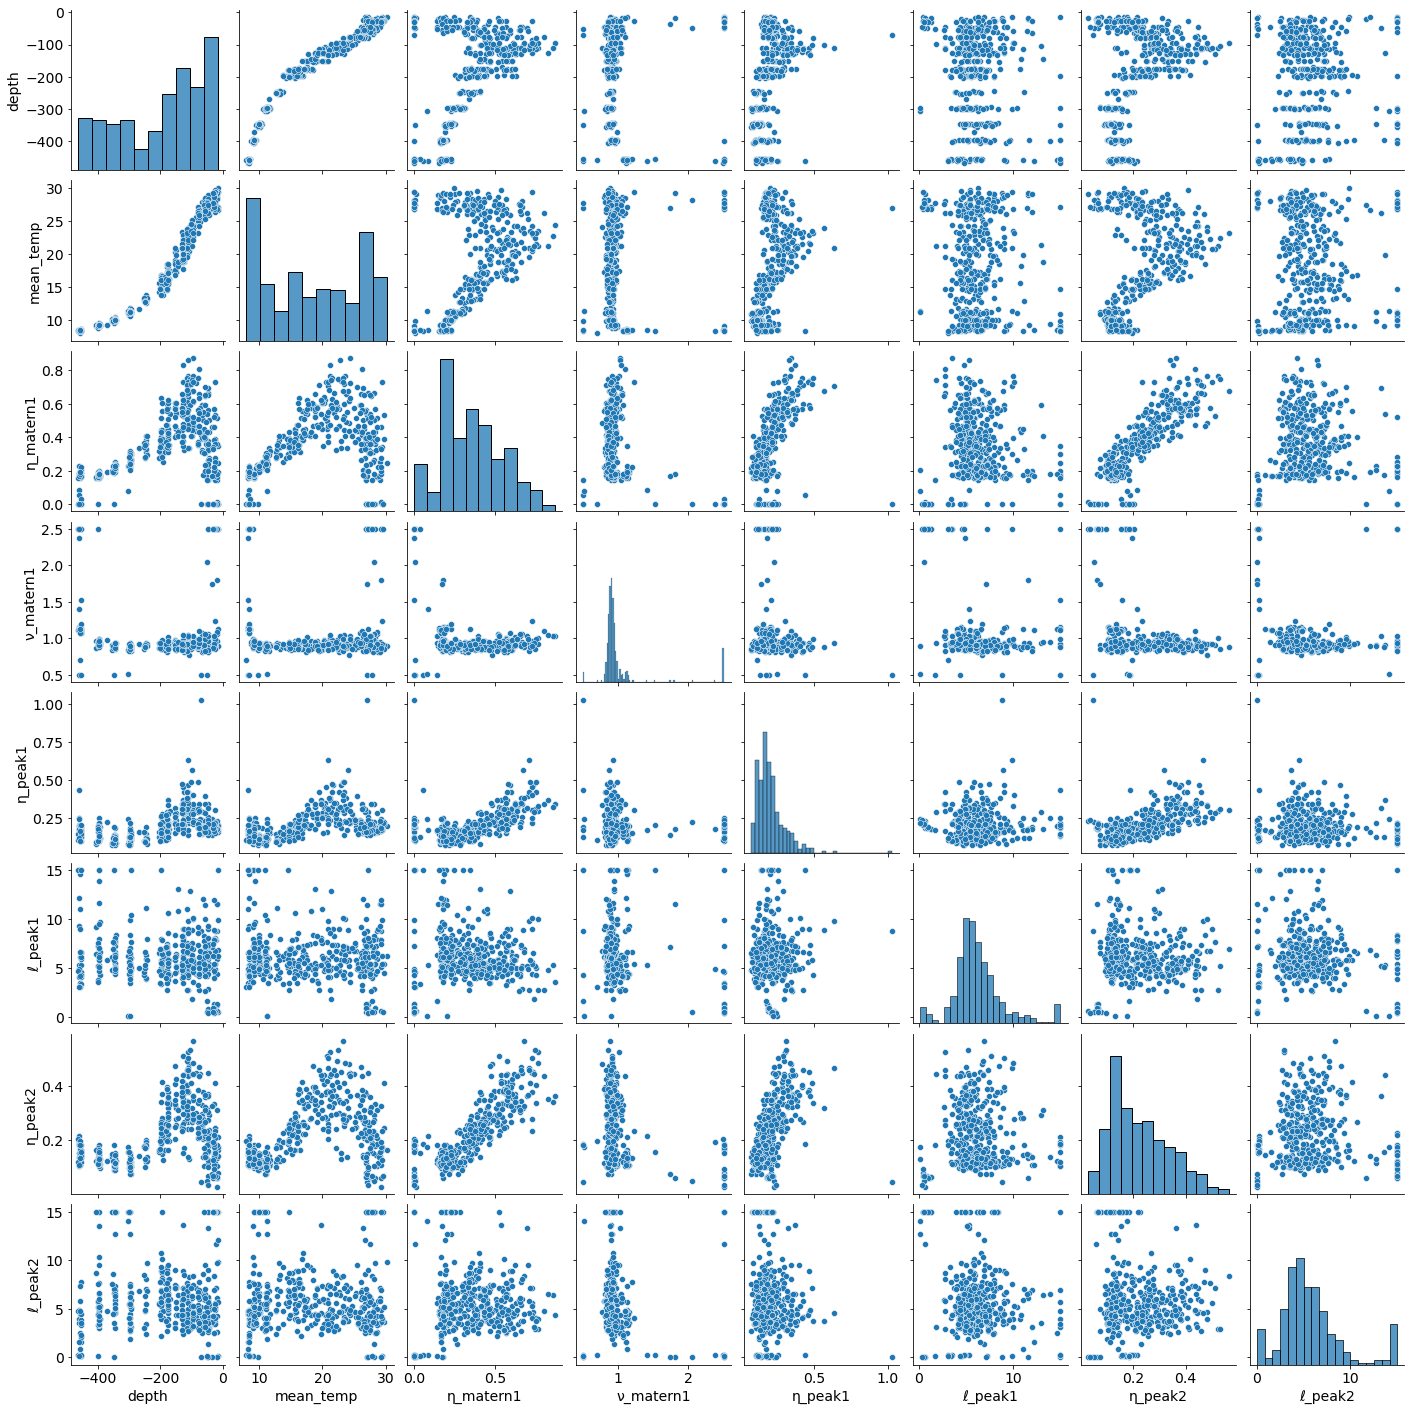

In [180]:
import seaborn as sns
#pair plot for parameter
sns.pairplot(final_df_M1L2.iloc[:, [1] + list(range(5, 14))])
plt.show()